# Analysis Code Definition

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import copy

import prettytable

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
binary_data = pd.read_csv('../data/uptodate_binary.csv')
numerical_data = pd.read_csv('../data/uptodate_numerical.csv')

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/2712892919.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  binary_data = pd.read_csv('../data/uptodate_binary.csv')
/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/2712892919.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  numerical_data = pd.read_csv('../data/uptodate_numerical.csv')


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

In [16]:
def plot_top_k_correlations(feature, matrix, k=10):
    """
    Plots the top-k features most correlated with the given feature.

    Parameters:
        feature (str): The feature to compare against.
        k (int): Number of top correlated features to show.
        matrix (pd.DataFrame): Correlation matrix (default: cov_matrix).
    """
    if feature not in matrix.columns:
        raise ValueError(f"Feature '{feature}' not found in correlation matrix.")

    # Get correlations, drop self, drop NaN
    corr_series = matrix[feature].drop(labels=[feature]).dropna()
    # corr_series = matrix[feature].drop(feature).dropna()
    # Take absolute value for sorting, but keep sign for plotting
    top_k = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)[:k]

    # Color mapping: negative = blue, positive = red, intensity by abs value
    colors = []
    for v in top_k:
        if v < 0:
            colors.append((0.2, 0.2, 1.0, min(0.3 + abs(v), 1.0)))
        else:
            colors.append((1.0, 0.2, 0.2, min(0.3 + abs(v), 1.0)))

    plt.rcParams['font.family'] = 'AppleGothic'
    plt.rcParams['font.size'] = 15
    plt.figure(figsize=(10, 10))
    ax = top_k.plot(kind='bar', color=colors)
    plt.title(f"Top {k} features correlated with '{feature}'")
    plt.ylabel("Correlation coefficient")
    plt.xlabel("Feature")
    plt.tight_layout()

    # Add value labels on each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=10, rotation=0, xytext=(0, 3 if height >= 0 else -12), textcoords='offset points')

    plt.show()

In [5]:
drop_features = ['idx', 'Year', 'Semester']

def preprocess(nd):
    df = nd.select_dtypes(include=['number'])
    for feature in drop_features:
        if feature in df.columns:
            df = df.drop(columns=feature)
    return df

def filter_rows_by_columns(nd, columns, value):
    """
    Returns a DataFrame with rows where all specified columns have the given value.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list of str): List of column names to check.
        value: The value to match in the specified columns.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    df = preprocess(nd)
    mask = (df[columns] == value).all(axis=1)
    return df[mask]

def draw_covariance_matrix(nd):
    # Calculate covariance matrix
    df = preprocess(nd)
    cov_matrix = df.cov()
    # print(cov_matrix)

    # Plot heatmap
    plt.rcParams['font.family'] = 'AppleGothic'
    # plt.rcParams['font.size'] = 1
    plt.figure(figsize=(20, 15))
    # sns.set(font='Malgun Gothic', rc={'axes.unicode_minus':False}, style='white')
    sns.heatmap(cov_matrix, cmap='coolwarm', annot=False)
    plt.title('Covariance Matrix Heatmap')
    plt.show()

def draw_correlation_matrix(nd):
    # Calculate correlation matrix
    df = preprocess(nd)
    corr_matrix = df.corr()

    # Plot heatmap
    plt.rcParams['font.family'] = 'AppleGothic'
    # plt.rcParams['font.size'] = 1
    plt.figure(figsize=(20, 15))
    # sns.set(font='Malgun Gothic', rc={'axes.unicode_minus':False}, style='white')
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

In [6]:
from itertools import product

def all_boolean_combinations(N):
    """
    Returns a list of all possible combinations of N boolean values.
    Each combination is a tuple of length N with True/False values.
    """
    return list(product([0.0, 1.0], repeat=N))

In [7]:
def check_cov_by_features(nd, features, patterns):
    max_value = 0.0
    max_df = None
    max_pattern = []

    for pattern in patterns:
        filtered_df = filter_rows_by_columns(nd, features, pattern)
        # num_data = filtered_df.select_dtypes(include=['number'])
        # num_data = num_data.drop(columns='idx')
        # num_data = num_data.drop(columns='Year')
        # num_data = num_data.drop(columns='Semester')

        # cov_matrix = num_data.cov()
        cov_matrix = filtered_df.cov()
        max_covariance = max(cov_matrix['course evaluation'])
        if max_covariance > max_value:
            max_value = max_covariance
            max_df = cov_matrix
            max_pattern = pattern

    draw_covariance_matrix(max_df)
    for feature, mp in zip(features, max_pattern):
        print(f'{feature} : {mp}')

    return max_df

def check_corr_by_features(nd, features, patterns, draw=True):
    max_value = 0.0
    max_df = None
    max_pattern = []
    max_len = 0

    for i, pattern in enumerate(patterns):
        filtered_df = filter_rows_by_columns(nd, features, pattern)
        if len(filtered_df) < 10:
            continue
        print(f'length of {pattern} : {len(filtered_df)}')
        # num_data = filtered_df.select_dtypes(include=['number'])
        # num_data = num_data.drop(columns='idx')
        # num_data = num_data.drop(columns='Year')
        # num_data = num_data.drop(columns='Semester')

        # corr_matrix = num_data.corr()
        corr_matrix = filtered_df.corr()
        corr_matrix.at['course evaluation', 'course evaluation'] = np.nan
        max_correlation = np.nanmax(list(map(abs, corr_matrix.iloc[0])))
        print(f'{pattern} : {max_correlation}')
        if max_correlation > max_value:
            max_value = max_correlation
            max_df = corr_matrix
            max_pattern = pattern
            max_len = len(filtered_df)

    if draw:
        draw_correlation_matrix(max_df)
    for feature, mp in zip(features, max_pattern):
        print(f'{feature} : {mp}')
    print(f'Data Instances matching the pattern : {max_len}')

    return max_df

In [8]:
def plot_corrs_single_feature(df1, df2, title1='Correlation Matrix 1', title2='Correlation Matrix 2'):
    """
    Plots two correlation matrices side by side for comparison.

    Parameters:
        df1 (pd.DataFrame): First DataFrame (numerical).
        df2 (pd.DataFrame): Second DataFrame (numerical).
        title1 (str): Title for the first plot.
        title2 (str): Title for the second plot.
    """
    # Preprocess to remove drop_features and keep only numerical columns
    def preprocess_for_corr(df):
        num_df = df.select_dtypes(include=['number'])
        for feature in drop_features:
            if feature in num_df.columns:
                num_df = num_df.drop(columns=feature)
        return num_df

    corr1 = preprocess_for_corr(df1).corr()
    corr2 = preprocess_for_corr(df2).corr()

    plt.rcParams['font.family'] = 'AppleGothic'
    fig, axes = plt.subplots(1, 2, figsize=(32, 14))
    sns.heatmap(corr1, cmap='coolwarm', annot=False, ax=axes[0])
    axes[0].set_title(title1)
    sns.heatmap(corr2, cmap='coolwarm', annot=False, ax=axes[1])
    axes[1].set_title(title2)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_top_k_side_by_side(corr1, corr2, feature, k=10, title1='Correlation Matrix 1', title2='Correlation Matrix 2'):
    """
    Plots the top-k features most correlated with the given feature from two correlation matrices, side by side.

    Parameters:
        corr1 (pd.DataFrame): First correlation matrix.
        corr2 (pd.DataFrame): Second correlation matrix.
        feature (str): The feature to compare against.
        k (int): Number of top correlated features to show.
        title1 (str): Title for the first plot.
        title2 (str): Title for the second plot.
    """
    def get_top_k(corr_matrix):
        if feature not in corr_matrix.columns:
            raise ValueError(f"Feature '{feature}' not found in correlation matrix.")
        corr_series = corr_matrix[feature].drop(labels=[feature]).dropna()
        top_k = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)[:k]
        return top_k

    top_k1 = get_top_k(corr1)
    top_k2 = get_top_k(corr2)

    def get_colors(series):
        colors = []
        for v in series:
            if v < 0:
                colors.append((0.2, 0.2, 1.0, min(0.3 + abs(v), 1.0)))
            else:
                colors.append((1.0, 0.2, 0.2, min(0.3 + abs(v), 1.0)))
        return colors

    colors1 = get_colors(top_k1)
    colors2 = get_colors(top_k2)

    plt.figure(figsize=(20, 8))
    ax1 = plt.subplot(1, 2, 1)
    top_k1.plot(kind='bar', color=colors1, ax=ax1)
    ax1.set_title(f"{title1}: Top {k} correlated with '{feature}' : False")
    ax1.set_ylabel("Correlation coefficient")
    ax1.set_xlabel("Feature")
    for p in ax1.patches:
        height = p.get_height()
        ax1.annotate(f'{height:.3f}', 
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom' if height >= 0 else 'top',
                     fontsize=10, rotation=0, xytext=(0, 3 if height >= 0 else -12), textcoords='offset points')

    ax2 = plt.subplot(1, 2, 2)
    top_k2.plot(kind='bar', color=colors2, ax=ax2)
    ax2.set_title(f"{title2}: Top {k} correlated with '{feature}' : True")
    ax2.set_ylabel("Correlation coefficient")
    ax2.set_xlabel("Feature")
    for p in ax2.patches:
        height = p.get_height()
        ax2.annotate(f'{height:.3f}', 
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom' if height >= 0 else 'top',
                     fontsize=10, rotation=0, xytext=(0, 3 if height >= 0 else -12), textcoords='offset points')

    plt.tight_layout()
    plt.show()

In [10]:
def check_single_feature(nd, feature):
    filtered_df = filter_rows_by_columns(nd, [feature], 0.0)
    print(f'length of False : {len(filtered_df)}')
    corr_matrix0 = filtered_df.corr()

    filtered_df = filter_rows_by_columns(nd, [feature], 1.0)
    print(f'length of True : {len(filtered_df)}')
    corr_matrix1 = filtered_df.corr()

    plot_corrs_single_feature(corr_matrix0, corr_matrix1, 'False', 'True')

In [21]:
def plot_top_k_partialcorr(feature_dict, feat_A, feat_B):
    """
    Visualizes the top-10 features from a dictionary in decreasing order.

    Parameters:
        feature_dict (dict): Dictionary with feature names as keys and numerical values as values.
        title (str): Title for the plot.
    """
    # Sort features by value in descending order and select top 10
    sorted_items = sorted(feature_dict.items(), key=lambda x: (-1) * x[1], reverse=True)[:10]
    features, values = zip(*sorted_items)

    title=f"Partial Correlation : {feat_A} ~ {feat_B}"

    plt.rcParams['font.family'] = 'AppleGothic'
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(features), y=list(values), palette='viridis')
    plt.xlabel('Confounding Variable')
    plt.xticks(rotation=90)
    plt.ylabel('Partial Correlation Value')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Code Definition

In [12]:
import numpy as np
import pandas as pd
import prettytable as pt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# from jqmcvi import base

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg

import tqdm


def load_data():
    data = pd.read_csv('../data/uptodate_binary.csv')
    # edit
    data = data.dropna()
    # data = data.drop(['월요일', '화요일', '수요일', '목요일', '금요일'], axis=1)

    # included_features = [f for f in data.columns if '수업구성요소' in f]
    # print(included_features)
    # data = data[included_features]

    # data = data[]
    # data = data.iloc[:1000]

    print(len(data))

    return data



def show_cluster_stats(clusters, silhouette_score=None, dbcv_s=None):
    raw_data = pd.read_csv('../data/uptodate_binary.csv').dropna()
    raw_data['cluster'] = clusters

    table = pt.PrettyTable(['cluster label', 'data instance count'])
    for i in range(-1, len(set(clusters)) - 1):
        table.add_row([i, len(raw_data[raw_data['cluster'] == i])])
    if silhouette_score is not None:
        print(f'Silhouette score : {silhouette_score}')
    if dbcv_s is not None:
        print(f'Silhouette score : {dbcv_s}')
    print(table)

def show_feature_stats(data, features, clusters, numerical=False, outlier=True):
    data['cluster'] = clusters

    info = ['idx', 'data instance count']
    info.extend(features)
    feature_stats = pt.PrettyTable(info)
    
    if outlier:
        for i in range(-1, len(set(clusters)) - 1):
            row = [i, len(data[data['cluster'] == i])]
            for feat in features:
                if not numerical:
                    row.append(len(data[(data['cluster'] == i) & (data[feat] == True)]))
                else:
                    temp = data[data['cluster'] == i]
                    # print(temp[feat])
                    row.append(sum(temp[feat]) / len(temp))
            feature_stats.add_row(row)
    else:
        for i in range(len(set(clusters))):
            row = [i, len(data[data['cluster'] == i])]
            for feat in features:
                if not numerical:
                    row.append(len(data[(data['cluster'] == i) & (data[feat] == True)]))
                else:
                    temp = data[data['cluster'] == i]
                    # print(temp[feat])
                    row.append(sum(temp[feat]) / len(temp))
            feature_stats.add_row(row)
    print(feature_stats)

def get_max_silhouette(table):
    max = -1 * np.inf
    max_eps = 0
    max_min_samples = 0

    try:
      silhouette_column_index = table.field_names.index('silhouette')

      # To get all values in the 'silhouette' column, iterate through the rows
      # silhouette_values = [row[silhouette_column_index] for row in table._rows]

      for row in table._rows:
          if row[0] == 0.1:
              continue
          if row[silhouette_column_index] > max:
              max = row[silhouette_column_index]
              max_eps = row[0]
              max_min_samples = row[1]

      # If you want a specific row's silhouette value (e.g., the first row):
      # first_row_silhouette = table._rows[0][silhouette_column_index]
      # print(f"Silhouette values: {silhouette_values}")

    except ValueError:
      print("Column 'silhouette' not found in the table.")

    print(f'max silhouette : {max}')
    print(f'max eps : {max_eps}')
    print(f'max min_samples : {max_min_samples}')

In [13]:
def shrink_values(ary):
    # print(ary[0])
    for i in range(len(ary)):
        ary[i] = ary[i] / 100
    return ary


# Clustering by Course Evaluation & Achievement Level

In [36]:
import numpy as np
import pandas as pd
import prettytable as pt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


import tqdm

binary_features = []

data = load_data()
# boolean_columns = ['course evaluation', 'achievement level']
boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns.extend([f for f in data.columns if '이수구분' in f])

data_boolean = data[boolean_columns]
# print(data_boolean.head())
data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))
print(data_boolean.shape)


eps_space = []
# for i in range(1, 10):
#     eps_space.append(i * 0.01)
for i in range(1, 10):
    eps_space.append(i * 0.1)
# eps_space.append(0.1)
# for i in range(1, 7):
    # eps_space.append(i)
min_samples_space = [5, 10, 15, 20, 25, 30, 35]

max_silhouette = 0
best_eps = 0
best_min_samples = 0
best_cluster_cnt = 0
best_dunn = 0

table = pt.PrettyTable()
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dunn index', 'cluster_cnt']
table.field_names = ['eps', 'min_samples', 'silhouette', 'cluster_cnt']

flag = False

for e in tqdm.tqdm(eps_space):
    for m in min_samples_space:
        try:
            dbscan = DBSCAN(
                eps=e,
                min_samples=m,
                metric='euclidean'  # Required for non-Euclidean metrics
            )
            clusters = dbscan.fit_predict(data_boolean)
            labels = set(clusters)

            silhouette_avg = silhouette_score(data_boolean, clusters)

            for_dunn = {}
            for i, c in enumerate(clusters):
                if c == -1:
                    continue
                if c not in for_dunn.keys():
                    for_dunn[c] = []
                for_dunn[c].append(data_boolean[i].astype(float))

            # dunn_index = base.dunn(list(for_dunn.values()))

            # info = [e, m, silhouette_avg, dunn_index, len(labels)]
            info = [e, m, silhouette_avg, len(labels)]
            table.add_row(info)
            # if silhouette_avg > max_silhouette:
            #     max_silhouette = silhouette_avg
            #     best_eps = e
            #     best_min_samples = m
            #     best_cluster_cnt = len(labels)
            #     best_dunn = dunn_index
        except:
            flag = True
            break
    if flag:
        break

print(table)

# print(f"The best eps is: {best_eps}")
# print(f"The best min_samples is: {best_min_samples}")
# print(f"The best silhouette score is: {max_silhouette}")
# print(f"The best cluster count is: {best_cluster_cnt}")
# print(f"The best dunn index is: {best_dunn}")


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/3882106720.py:19: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_binary.csv')


15380
(15380, 2)


 33%|███▎      | 3/9 [00:34<01:09, 11.53s/it]

+---------------------+-------------+---------------------+-------------+
|         eps         | min_samples |      silhouette     | cluster_cnt |
+---------------------+-------------+---------------------+-------------+
|         0.1         |      5      |  0.445994584315774  |     234     |
|         0.1         |      10     |  0.4168773559423005 |     185     |
|         0.1         |      15     |  0.3784668971296481 |     152     |
|         0.1         |      20     | 0.34995960299841244 |     134     |
|         0.1         |      25     |  0.3193422426418651 |     115     |
|         0.1         |      30     |  0.3071536903798415 |     111     |
|         0.1         |      35     | 0.27549723468297405 |      99     |
|         0.2         |      5      |  0.5991050047106782 |      2      |
|         0.2         |      10     |  0.5640197679595959 |      2      |
|         0.2         |      15     |  0.558734626429547  |      2      |
|         0.2         |      20     | 

In [39]:
data = load_data()
boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns.extend([f for f in data.columns if '이수구분' in f])

data_boolean = data[boolean_columns]
print(data_boolean.shape)
data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))

dbscan = DBSCAN(
    eps=0.1,
    min_samples=20,
    metric='euclidean'  # Required for non-Euclidean metrics
)
clusters = dbscan.fit_predict(data_boolean)

silhouette_avg = silhouette_score(data_boolean, clusters)

show_cluster_stats(clusters)

# info = ['idx', 'data instance count']
# included_features = ([f for f in data.columns if '수업구성요소' in f])
# info.extend(included_features)
# feature_stats = pt.PrettyTable(info)
# for i in range(-1, len(set(clusters))):
#     row = [i, len(raw_data[raw_data['cluster'] == i])]
#     for feat in included_features:
#         row.append(len(raw_data[(raw_data['cluster'] == i) & (raw_data[feat] == True)]))
#     feature_stats.add_row(row)
# print(feature_stats)

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/3882106720.py:19: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_binary.csv')


15380
(15380, 2)
+---------------+---------------------+
| cluster label | data instance count |
+---------------+---------------------+
|       -1      |         1323        |
|       0       |         271         |
|       1       |         156         |
|       2       |         446         |
|       3       |         316         |
|       4       |          91         |
|       5       |         150         |
|       6       |         600         |
|       7       |         498         |
|       8       |          65         |
|       9       |         123         |
|       10      |         220         |
|       11      |          85         |
|       12      |         199         |
|       13      |         281         |
|       14      |         275         |
|       15      |          30         |
|       16      |         296         |
|       17      |         345         |
|       18      |         330         |
|       19      |         129         |
|       20      |      

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/3882106720.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('../data/uptodate_binary.csv').dropna()


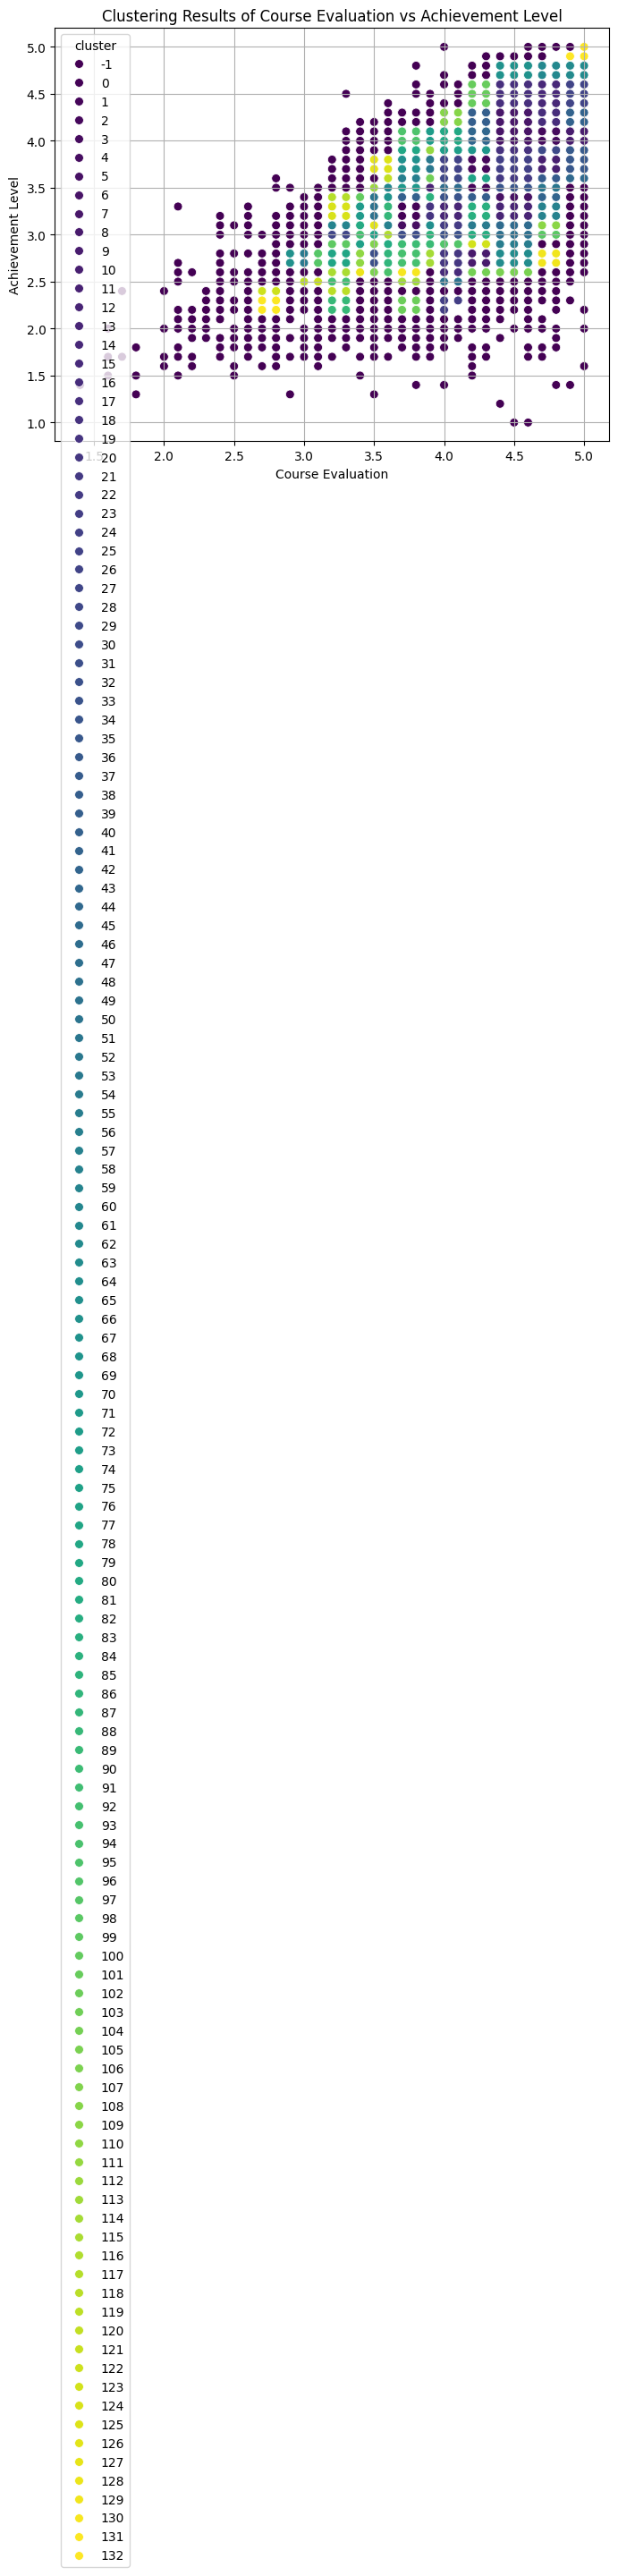

In [40]:
# prompt: I want to draw a plot visualizing the clustering results of 'data_boolean' which have 2 features. The x-axis will be the value of the first feature named 'course evaluation', and the y-axis will be the value of the second feature named 'achievement level'.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_boolean' contains the 2 features and 'clusters' contains the clustering labels
# and these variables are available from the preceding code.


# data = load_data()
# boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns.extend([f for f in data.columns if '이수구분' in f])
# data_boolean = data[boolean_columns]
# # print(data_boolean.head())
# data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))


# dbscan = DBSCAN(
#     eps=0.1,
#     min_samples=5,
#     metric='euclidean'  # Required for non-Euclidean metrics
# )
# clusters = dbscan.fit_predict(data_boolean)


# Create a DataFrame for plotting
xydata = data_boolean[:, :2]

plot_data = pd.DataFrame(xydata, columns=['course evaluation', 'achievement level'])
plot_data['cluster'] = clusters

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='course evaluation',
    y='achievement level',
    hue='cluster',
    data=plot_data,
    palette='viridis', # You can choose other color palettes
    legend='full',
    s=50 # Marker size
)
plt.title('Clustering Results of Course Evaluation vs Achievement Level')
plt.xlabel('Course Evaluation')
plt.ylabel('Achievement Level')
plt.grid(True)
plt.show()


# Clustering by 이수구분

In [ ]:
# import dbcv

import tqdm

from sklearn.metrics import jaccard_score


data = load_data()
boolean_columns = [f for f in data.columns if '이수구분' in f]

data_boolean = data[boolean_columns]
# print(data_boolean.head())

# edit
# data_boolean = data_boolean.astype({col: int for col in data_boolean.select_dtypes(include='bool').columns})

data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))
# print([type(d) for d in list(data_boolean[0])])
print(data_boolean.shape)


eps_space = []
# for i in range(1, 10):
#     eps_space.append(i * 0.01)
# for i in range(1, 10):
    # eps_space.append(i * 0.1)
eps_space.append(0.1)
for i in range(1, 7):
    eps_space.append(i)
# min_samples_space = [5, 10, 15, 20, 25, 30, 35]
min_samples_space = [5]

max_silhouette = 0
best_eps = 0
best_min_samples = 0
best_cluster_cnt = 0
best_dunn = 0

table = pt.PrettyTable()
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dunn index', 'cluster_cnt']
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dbcv', 'cluster_cnt']
table.field_names = ['eps', 'min_samples', 'silhouette', 'cluster_cnt']

flag = False

for e in tqdm.tqdm(eps_space):
    for m in min_samples_space:
        try:
            dbscan = DBSCAN(
                eps=e,
                min_samples=m,
                # metric=jaccard_distance  # Required for non-Euclidean metrics
                metric='manhattan'
            )
            clusters = dbscan.fit_predict(data_boolean)
            labels = set(clusters)

            silhouette_avg = silhouette_score(data_boolean, clusters)
            # dbcv_score = dbcv.dbcv(data_boolean, clusters, check_duplicates=False)


            # dunn_index = base.dunn(list(for_dunn.values()))

            # info = [e, m, silhouette_avg, dunn_index, len(labels)]
            # info = [e, m, silhouette_avg, dbcv_score, len(labels)]
            info = [e, m, silhouette_avg, len(labels)]
            table.add_row(info)
        except Exception as e:
            print(e)
            flag = True
            break
    if flag:
        break


print(table)



/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/3882106720.py:19: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_binary.csv')


15380


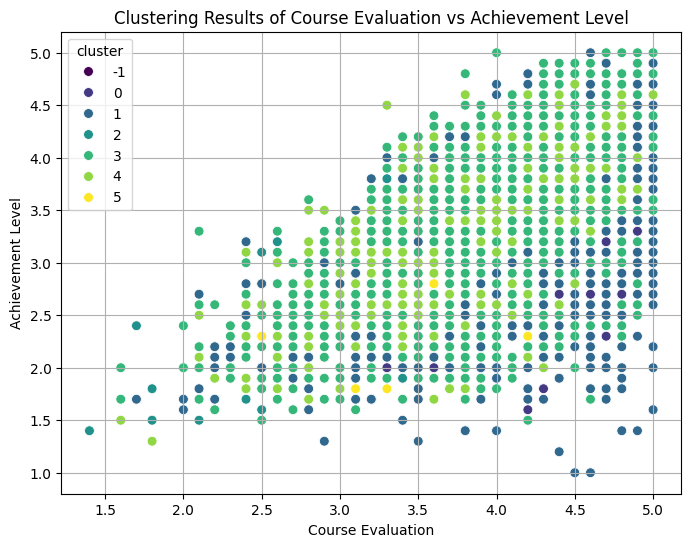

In [32]:
# prompt: I want to draw a plot visualizing the clustering results of 'data_boolean' which have 2 features. The x-axis will be the value of the first feature named 'course evaluation', and the y-axis will be the value of the second feature named 'achievement level'.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_boolean' contains the 2 features and 'clusters' contains the clustering labels
# and these variables are available from the preceding code.

data = load_data()

boolean_columns = [f for f in data.columns if '이수구분' in f]

data_boolean = data[boolean_columns]

# print(data_boolean.iloc[0])

dbscan = DBSCAN(
    eps=0.1,
    min_samples=5,
    # metric=jaccard_distance  # Required for non-Euclidean metrics
    metric='manhattan'
)
clusters = dbscan.fit_predict(data_boolean)
labels = set(clusters)


# Create a DataFrame for plotting
xydata = data[['course evaluation', 'achievement level']]

plot_data = pd.DataFrame(xydata, columns=['course evaluation', 'achievement level'])
plot_data['cluster'] = clusters
# print(clusters)

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='course evaluation',
    y='achievement level',
    hue='cluster',
    data=plot_data,
    palette='viridis', # You can choose other color palettes
    legend='full',
    s=50 # Marker size
)
plt.title('Clustering Results of Course Evaluation vs Achievement Level')
plt.xlabel('Course Evaluation')
plt.ylabel('Achievement Level')
plt.grid(True)
plt.show()


In [33]:
test = numerical_data.dropna()
test['cluster'] = clusters
each_cluster = {}
for c in list(set(clusters)):
    each_cluster[c] = test[test['cluster'] == c]

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/1545124775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cluster'] = clusters


In [110]:
x = 'course evaluation'
y = 'achievement level'
covar = 'teaching ability'

print(f'x = {x}, y = {y}, covar = {covar}')
for c in list(set(clusters)):
    print(f'Cluster {c}')
    print(pg.partial_corr(data=each_cluster[c], x=x, y=y, covar=covar, method='pearson'))

x = course evaluation, y = achievement level, covar = teaching ability
Cluster 0
           n         r        CI95%         p-val
pearson  310  0.297558  [0.19, 0.4]  9.788003e-08
Cluster 1
            n         r         CI95%         p-val
pearson  6230  0.195945  [0.17, 0.22]  5.915932e-55
Cluster 2
           n         r         CI95%         p-val
pearson  482  0.310275  [0.23, 0.39]  3.411364e-12
Cluster 3
            n         r         CI95%         p-val
pearson  5862  0.183797  [0.16, 0.21]  1.071188e-45
Cluster 4
            n         r        CI95%         p-val
pearson  2353  0.235716  [0.2, 0.27]  4.672518e-31
Cluster 5
           n         r          CI95%     p-val
pearson  139  0.117742  [-0.05, 0.28]  0.169018
Cluster -1
         n         r        CI95%    p-val
pearson  4 -0.398517  [-1.0, 1.0]  0.73905


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/effsize.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(nx - 3)


In [111]:
x = 'teaching ability'
y = 'achievement level'
covar = 'course evaluation'

print(f'x = {x}, y = {y}, covar = {covar}')
for c in list(set(clusters)):
    print(f'Cluster {c}')
    print(pg.partial_corr(data=each_cluster[c], x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = achievement level, covar = course evaluation
Cluster 0
           n         r         CI95%         p-val
pearson  310  0.644298  [0.57, 0.71]  1.235311e-37
Cluster 1
            n         r         CI95%  p-val
pearson  6230  0.608287  [0.59, 0.62]    0.0
Cluster 2
           n         r         CI95%         p-val
pearson  482  0.459602  [0.39, 0.53]  1.640206e-26
Cluster 3
            n         r         CI95%  p-val
pearson  5862  0.597807  [0.58, 0.61]    0.0
Cluster 4
            n        r         CI95%          p-val
pearson  2353  0.53931  [0.51, 0.57]  1.250843e-177
Cluster 5
           n         r         CI95%         p-val
pearson  139  0.632308  [0.52, 0.72]  8.960491e-17
Cluster -1
         n        r        CI95%     p-val
pearson  4  0.55908  [-1.0, 1.0]  0.622309


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/effsize.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(nx - 3)


In [112]:
x = 'teaching ability'
y = 'course evaluation'
covar = 'achievement level'

print(f'x = {x}, y = {y}, covar = {covar}')
for c in list(set(clusters)):
    print(f'Cluster {c}')
    print(pg.partial_corr(data=each_cluster[c], x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = course evaluation, covar = achievement level
Cluster 0
           n         r         CI95%     p-val
pearson  310  0.228032  [0.12, 0.33]  0.000052
Cluster 1
            n         r         CI95%          p-val
pearson  6230  0.412473  [0.39, 0.43]  1.660234e-254
Cluster 2
           n         r         CI95%         p-val
pearson  482  0.527928  [0.46, 0.59]  7.148562e-36
Cluster 3
            n         r         CI95%  p-val
pearson  5862  0.470602  [0.45, 0.49]    0.0
Cluster 4
            n         r         CI95%          p-val
pearson  2353  0.494245  [0.46, 0.52]  3.953954e-145
Cluster 5
           n         r         CI95%         p-val
pearson  139  0.551676  [0.42, 0.66]  2.336094e-12
Cluster -1
         n         r        CI95%     p-val
pearson  4  0.952009  [-1.0, 1.0]  0.198029


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/effsize.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(nx - 3)


In [ ]:
for c in list(set(clusters)):
    print(f'Cluster {c}')
    draw_correlation_matrix(each_cluster[c])

In [29]:
show_cluster_stats(clusters)

+---------------+---------------------+
| cluster label | data instance count |
+---------------+---------------------+
|       -1      |          4          |
|       0       |         310         |
|       1       |         6230        |
|       2       |         482         |
|       3       |         5862        |
|       4       |         2353        |
|       5       |         139         |
+---------------+---------------------+


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_16479/4096260183.py:36: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('../data/uptodate_binary.csv').dropna()


In [33]:
features = [f for f in data.columns if '이수구분' in f]
show_feature_stats(test, features, clusters, False, True)

+-----+---------------------+---------------+-----------------------+-----------------+-------------------+-------------------+---------------------+-------------------+
| idx | data instance count | 이수구분.교직 | 이수구분.교직(비사대) | 이수구분.군사학 | 이수구분.전공선택 | 이수구분.전공필수 | 이수구분.학문의기초 | 이수구분.학부공통 |
+-----+---------------------+---------------+-----------------------+-----------------+-------------------+-------------------+---------------------+-------------------+
|  -1 |          4          |       0       |           4           |        0        |         0         |         0         |          0          |         0         |
|  0  |         310         |      310      |           0           |        0        |         0         |         0         |          0          |         0         |
|  1  |         6230        |       0       |           0           |        0        |         0         |         0         |          0          |         0         |
|  2  |         482         |      

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_16479/4096260183.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = clusters


Cluster 0


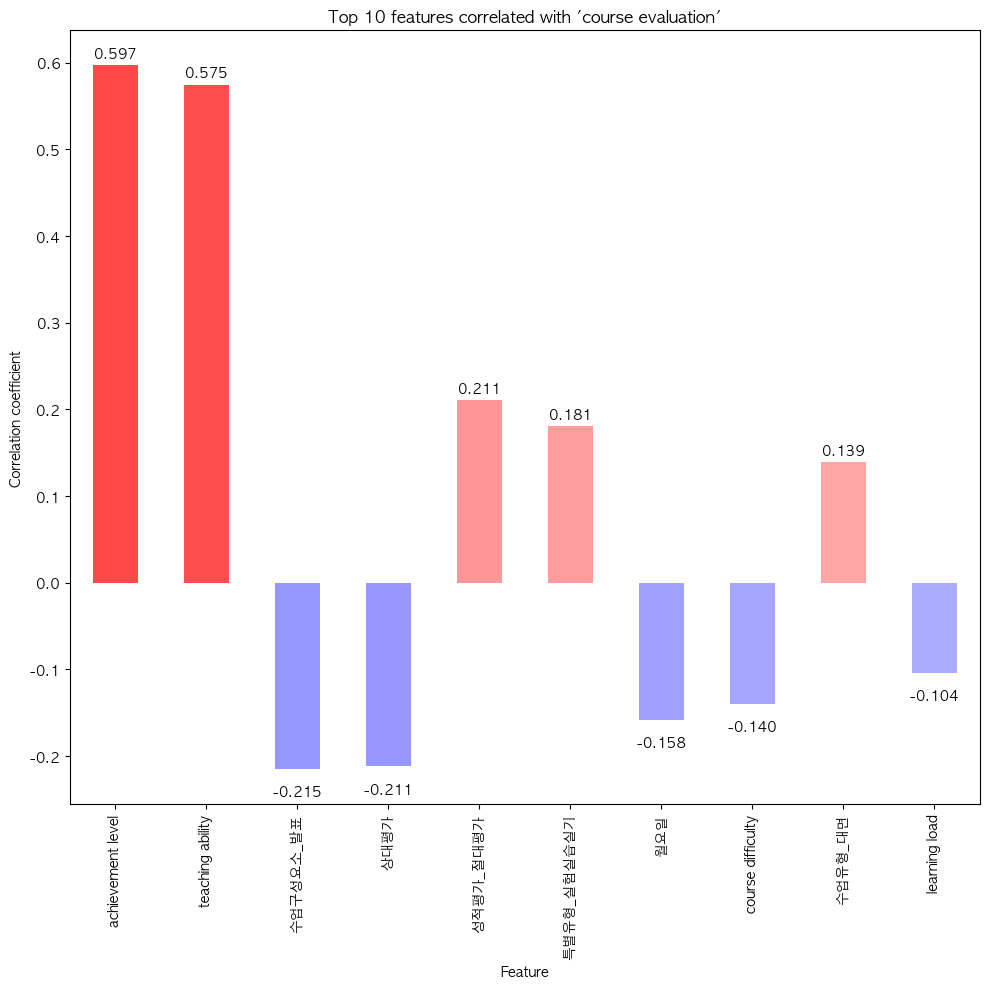

Cluster 1


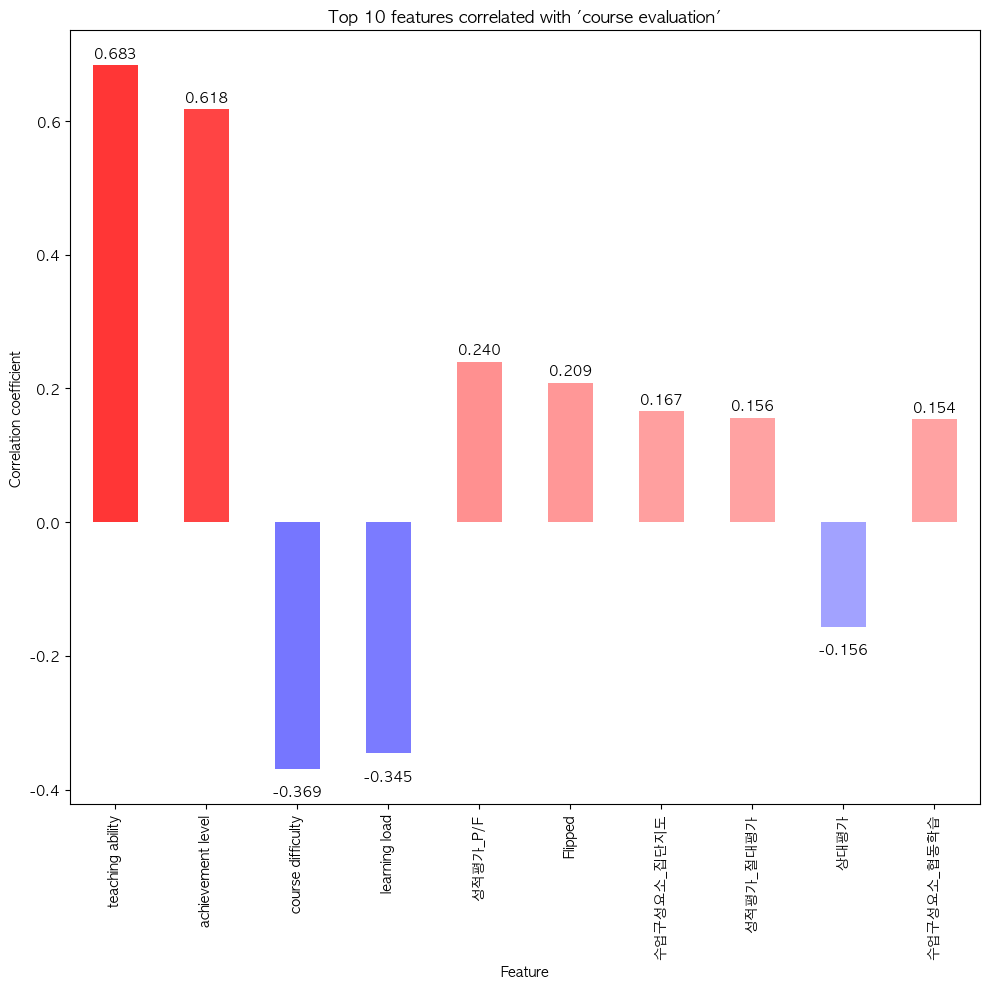

Cluster 2


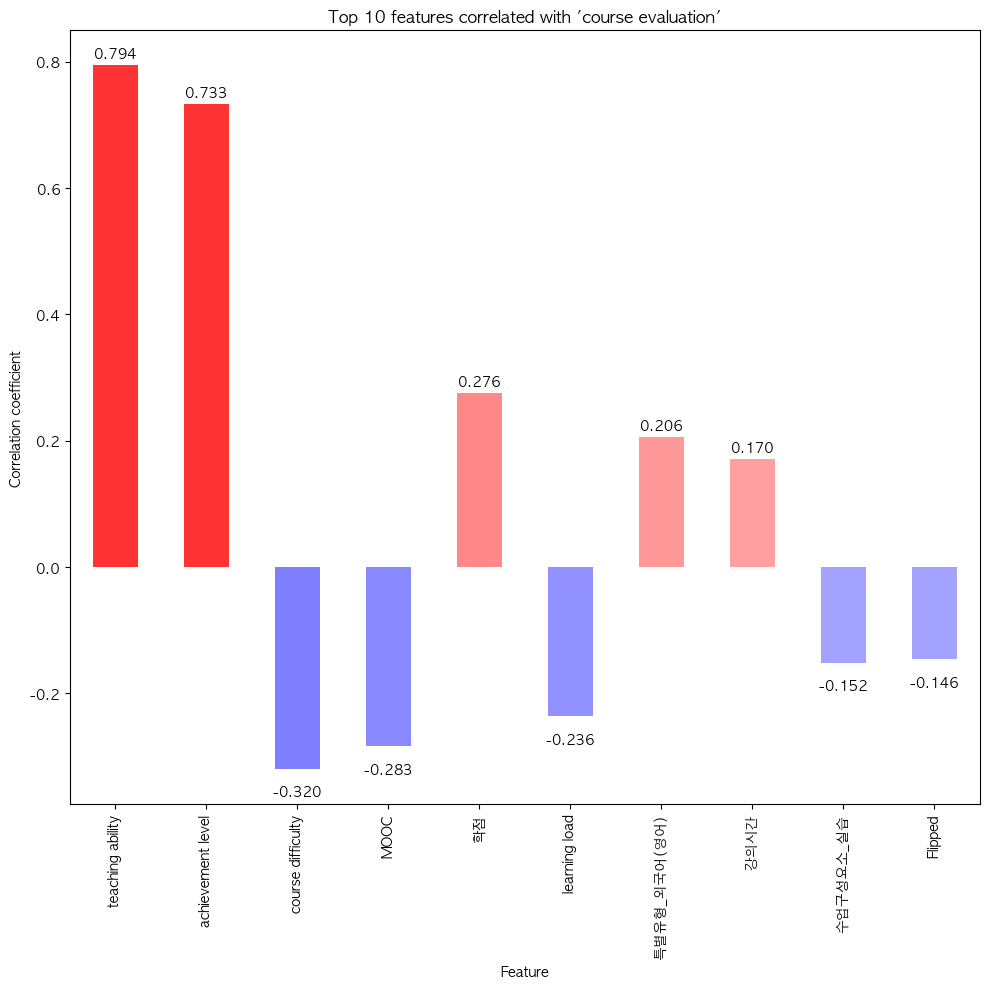

Cluster 3


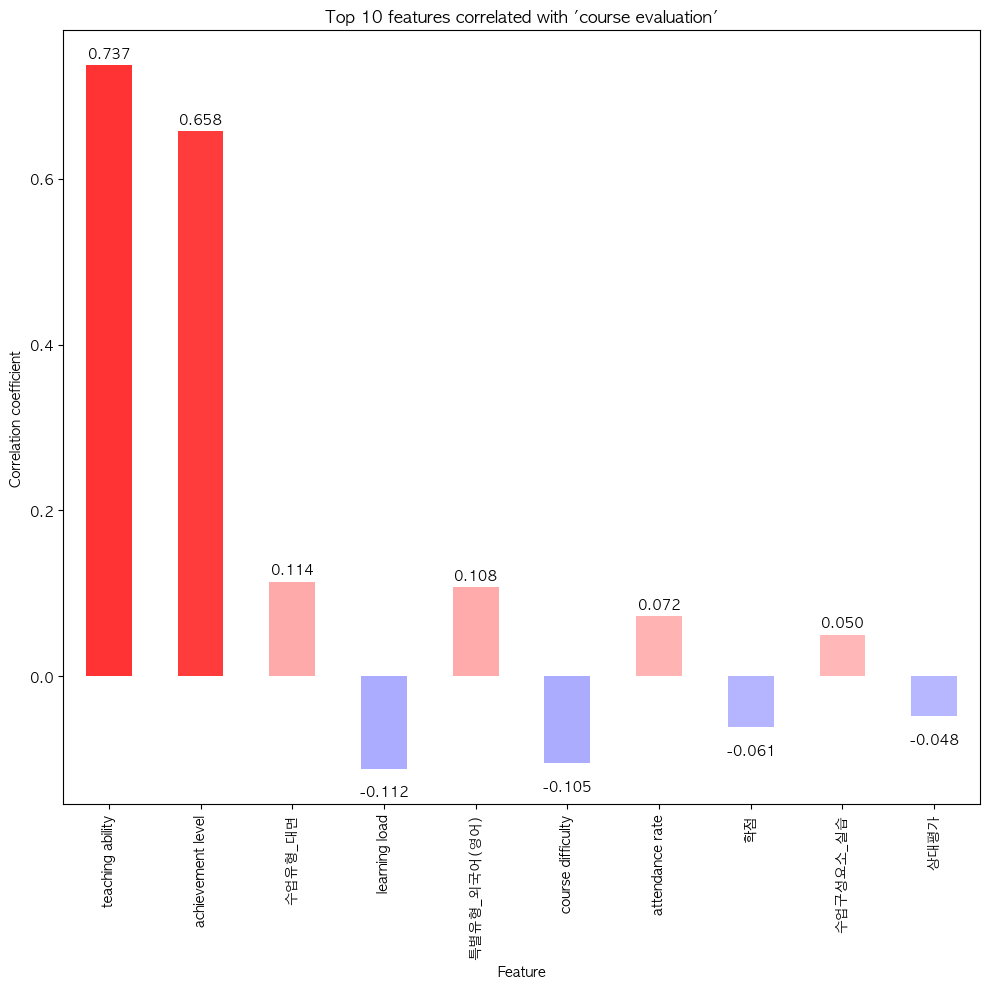

Cluster 4


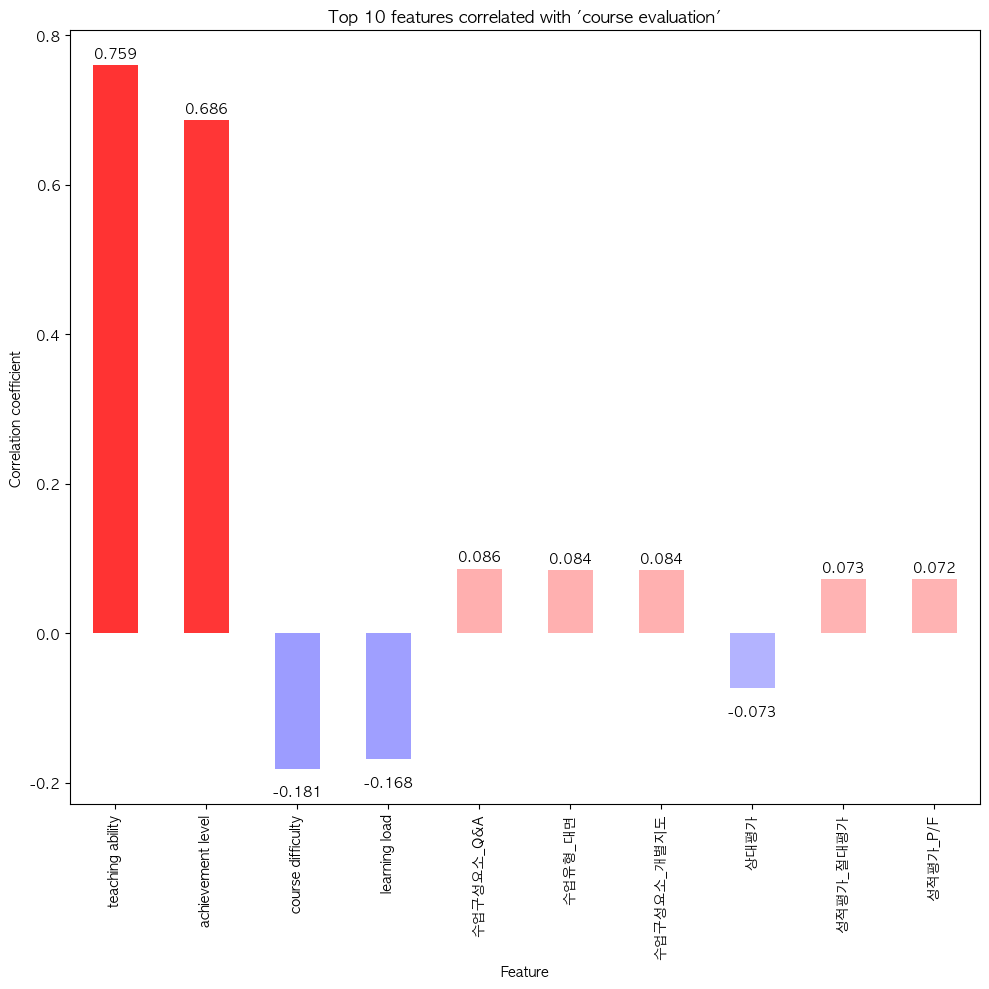

Cluster 5


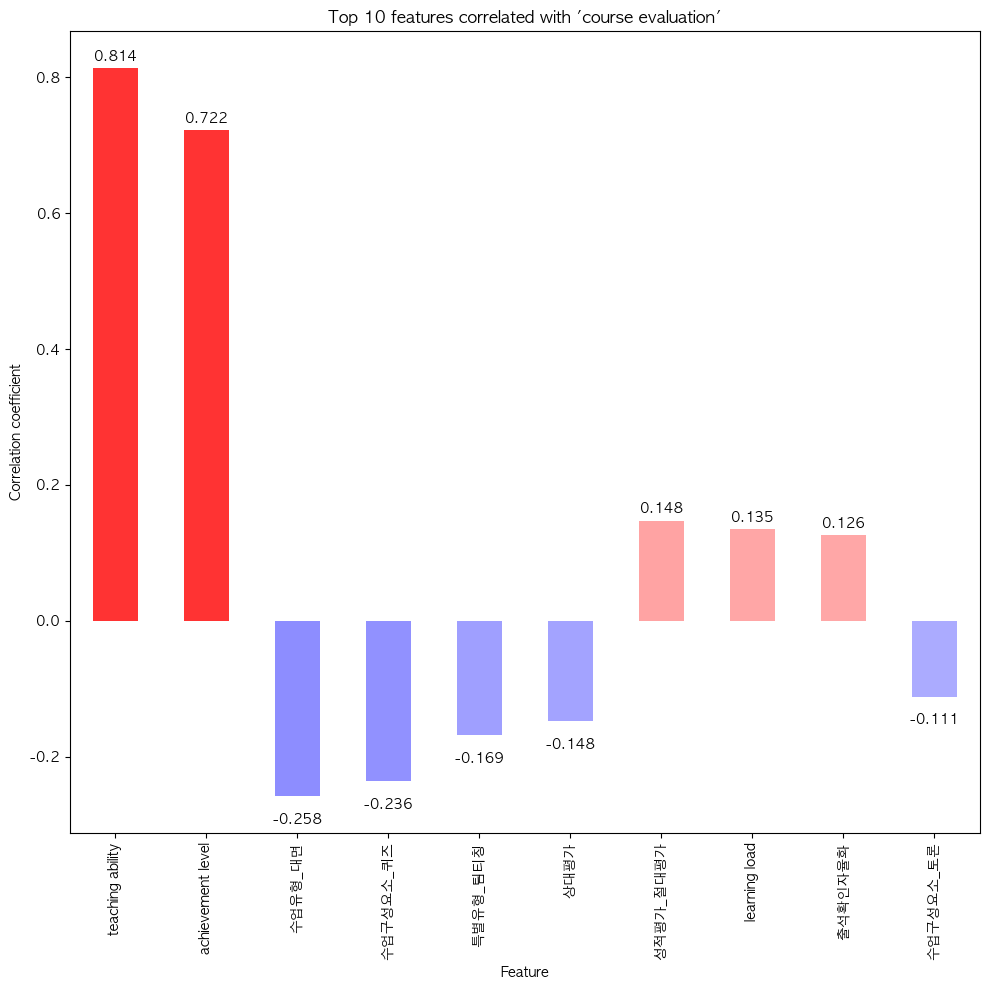

Cluster -1


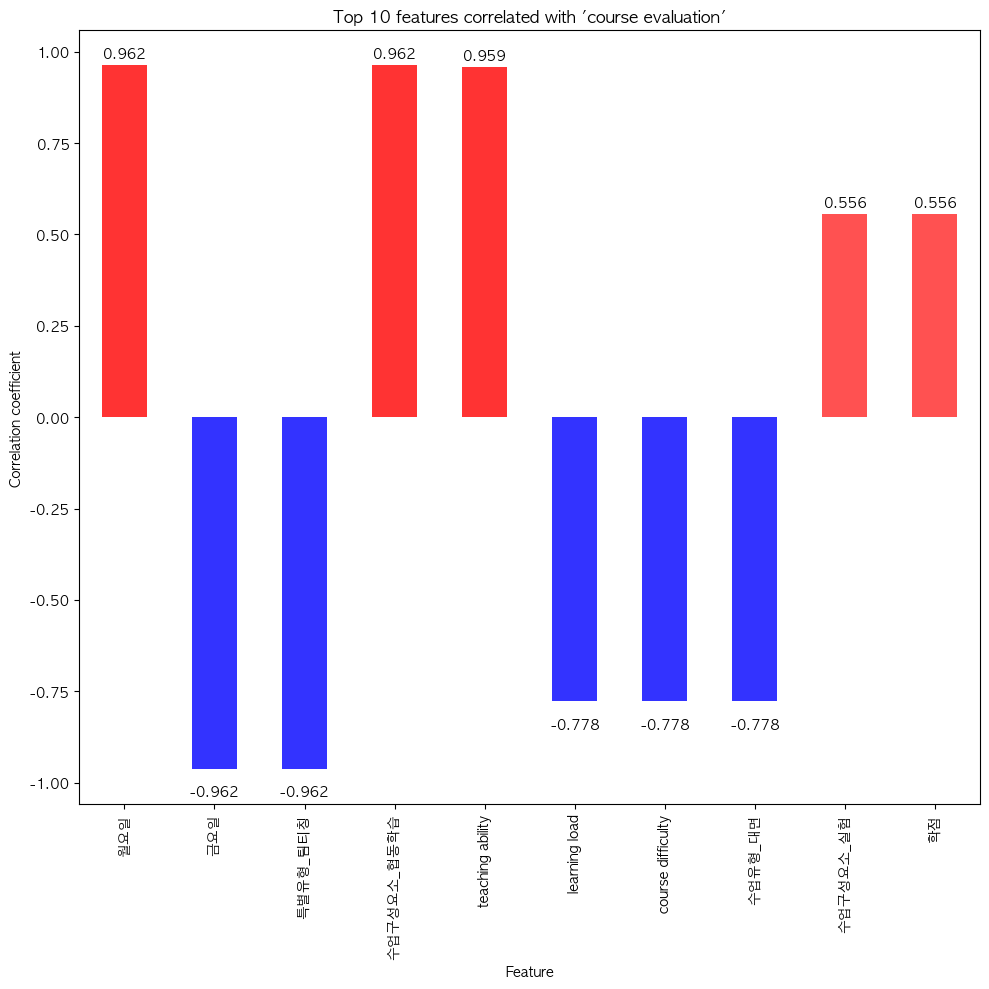

In [47]:
# print(each_cluster[3].columns)
for c in list(set(clusters)):
    print(f'Cluster {c}')
    plot_top_k_correlations('course evaluation', preprocess(each_cluster[c]).corr())

Cluster 0


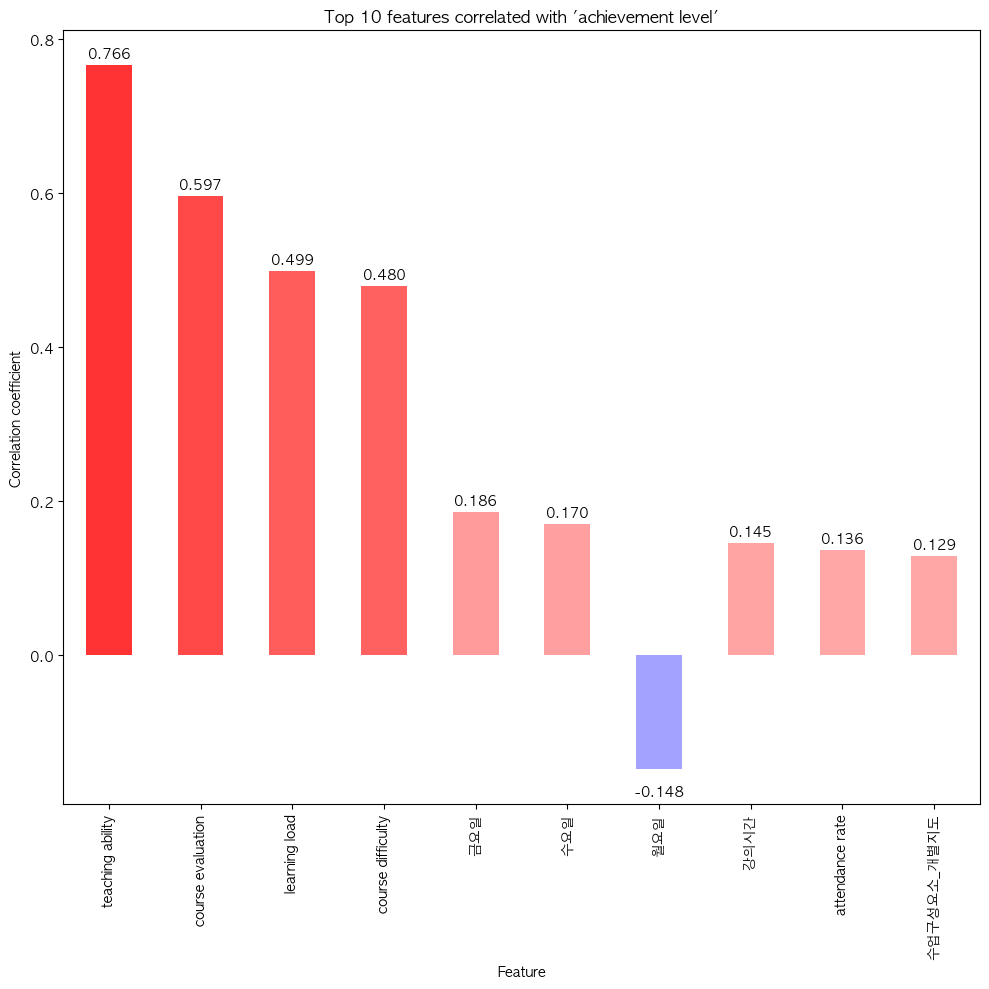

Cluster 1


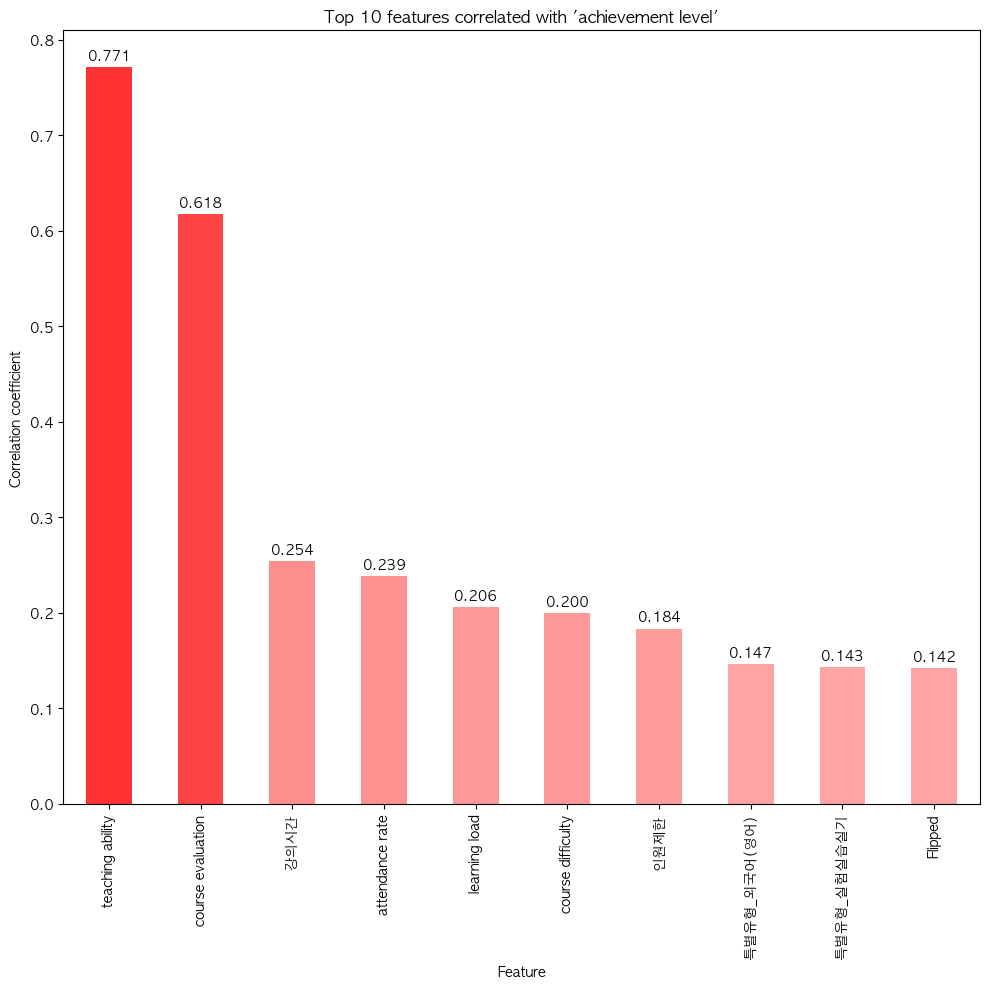

Cluster 2


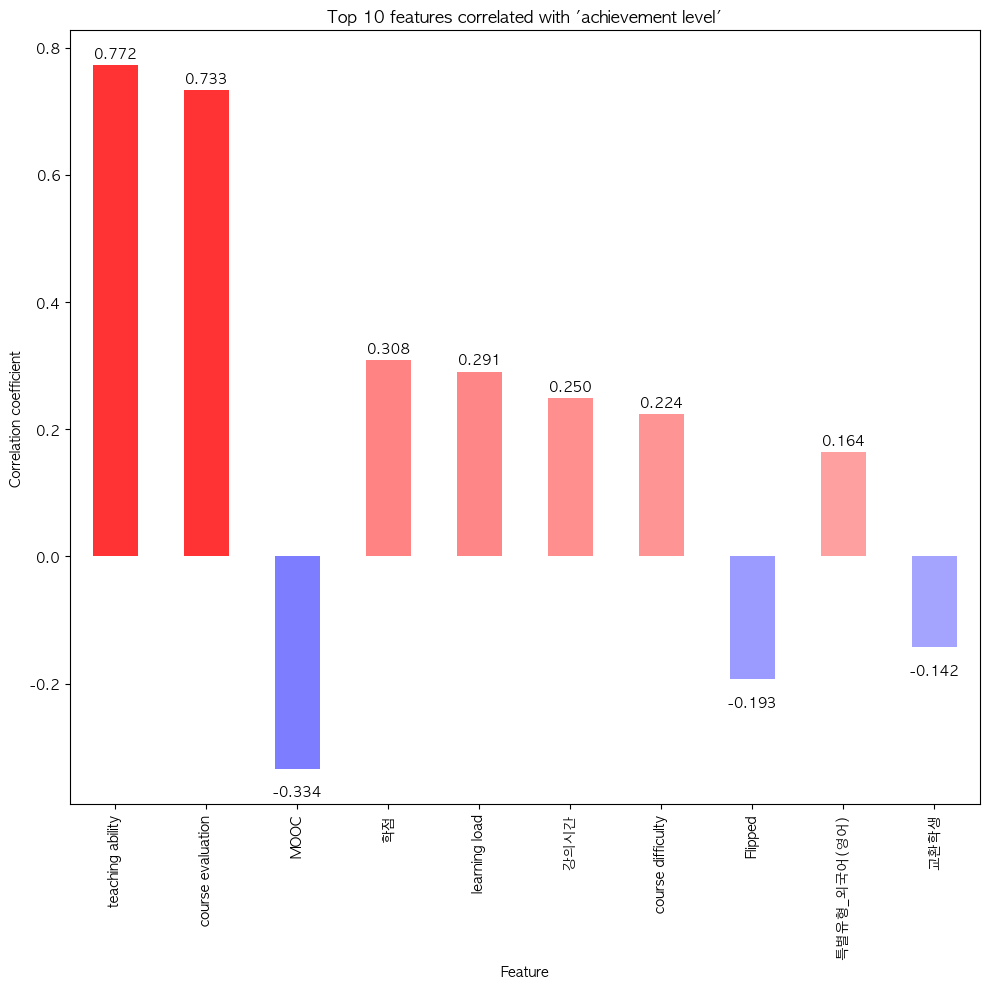

Cluster 3


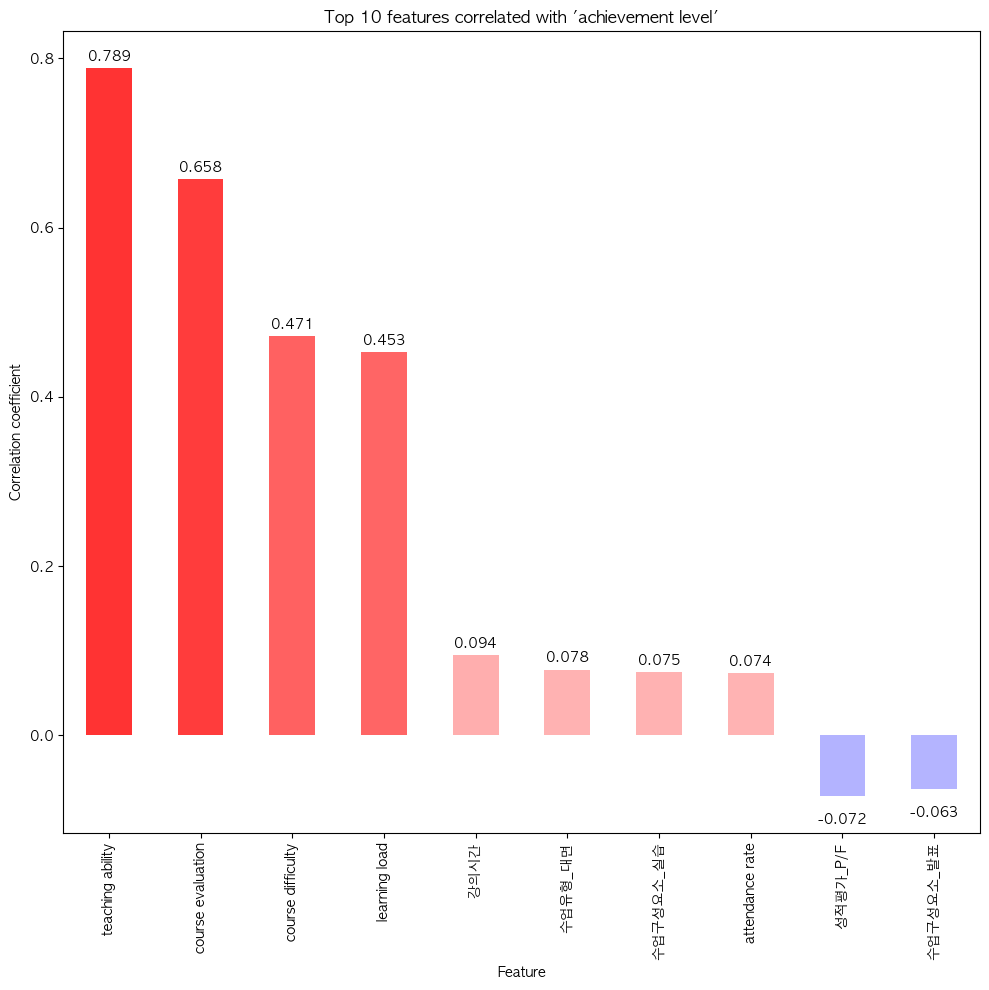

Cluster 4


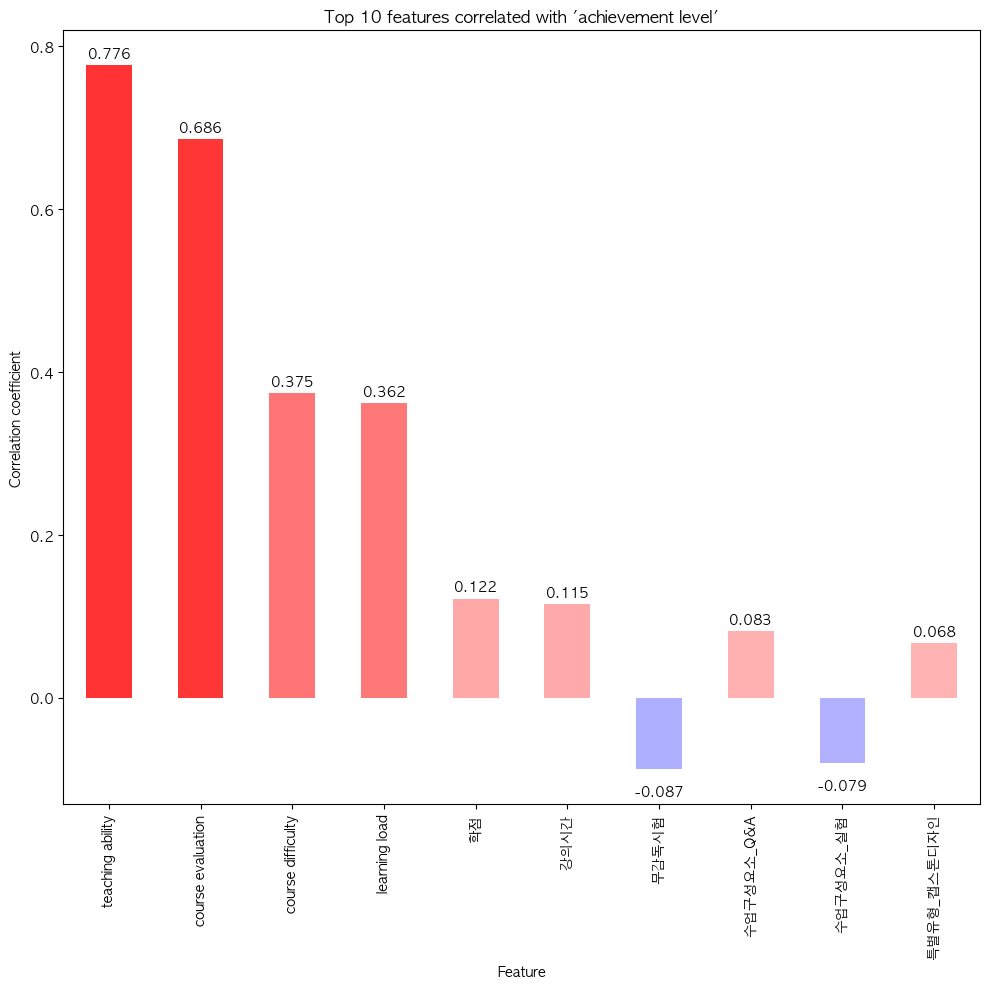

Cluster 5


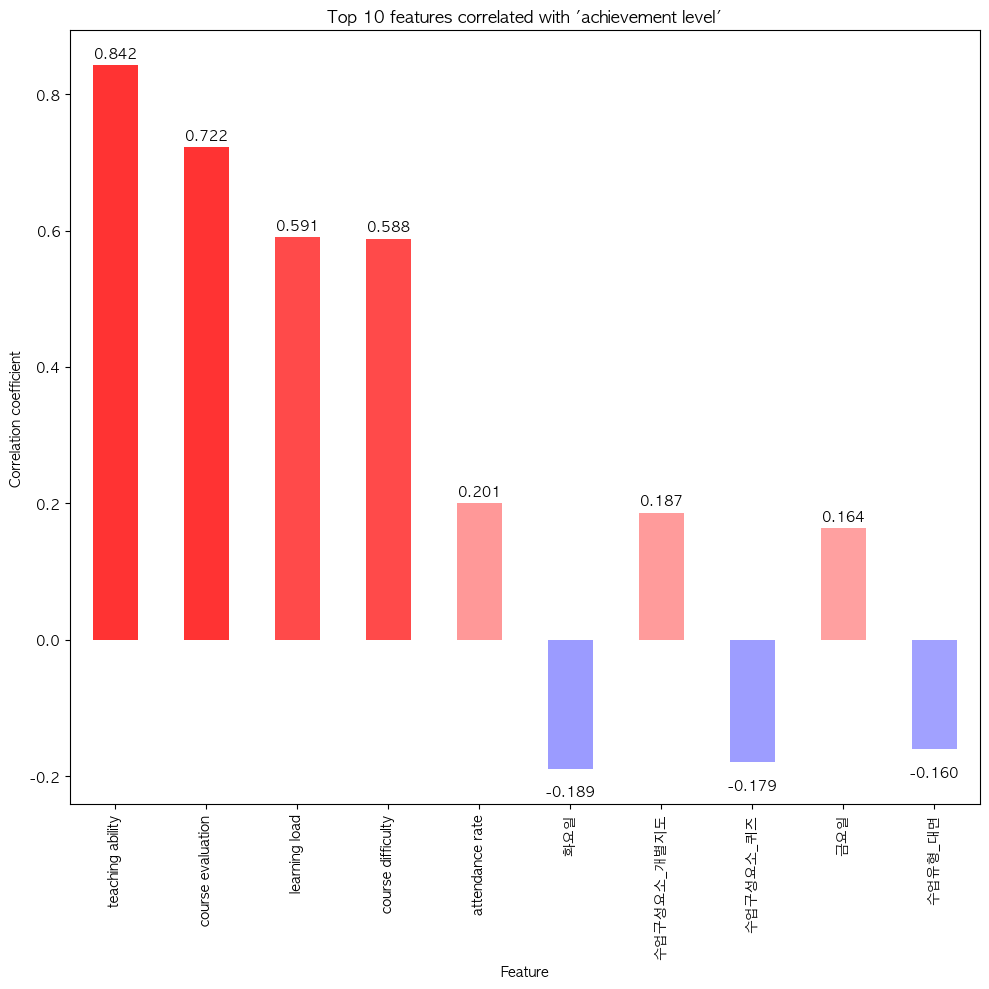

Cluster -1


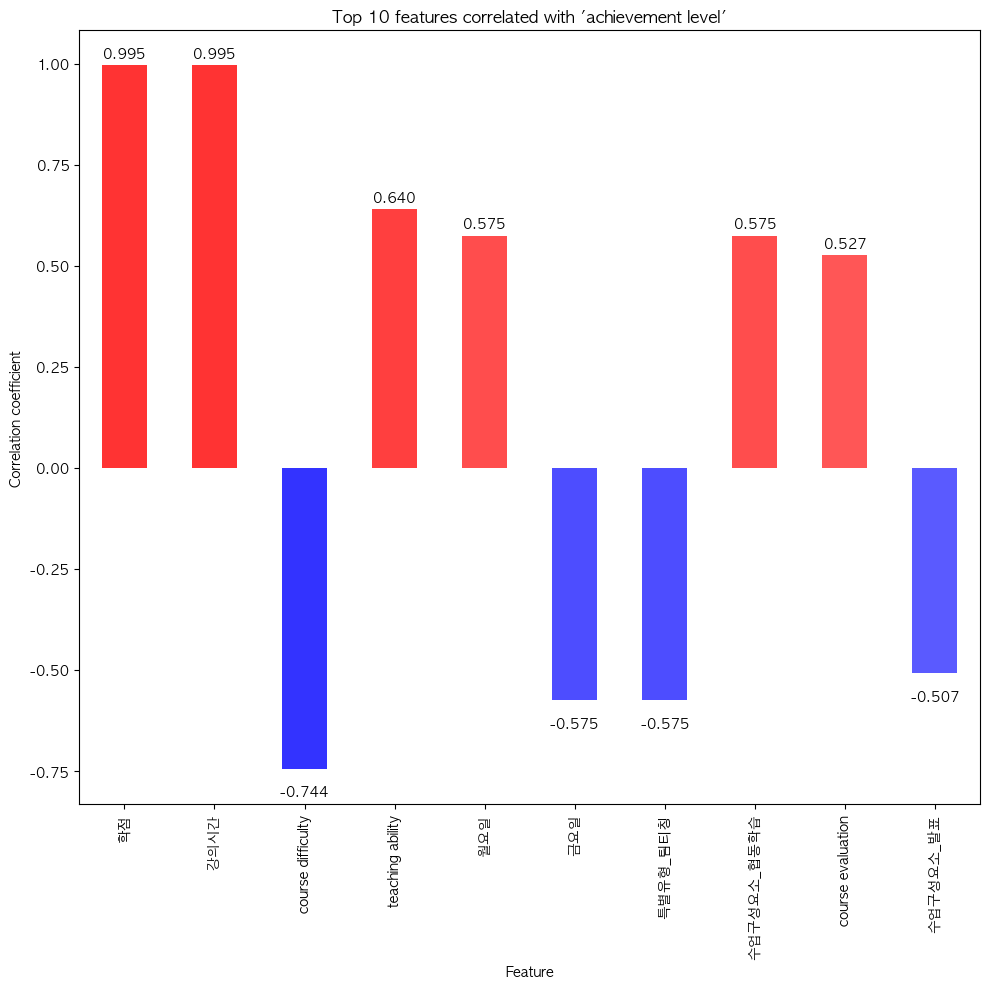

In [48]:
# print(each_cluster[3].columns)
for c in list(set(clusters)):
    print(f'Cluster {c}')
    plot_top_k_correlations('achievement level', preprocess(each_cluster[c]).corr())

Cluster 0


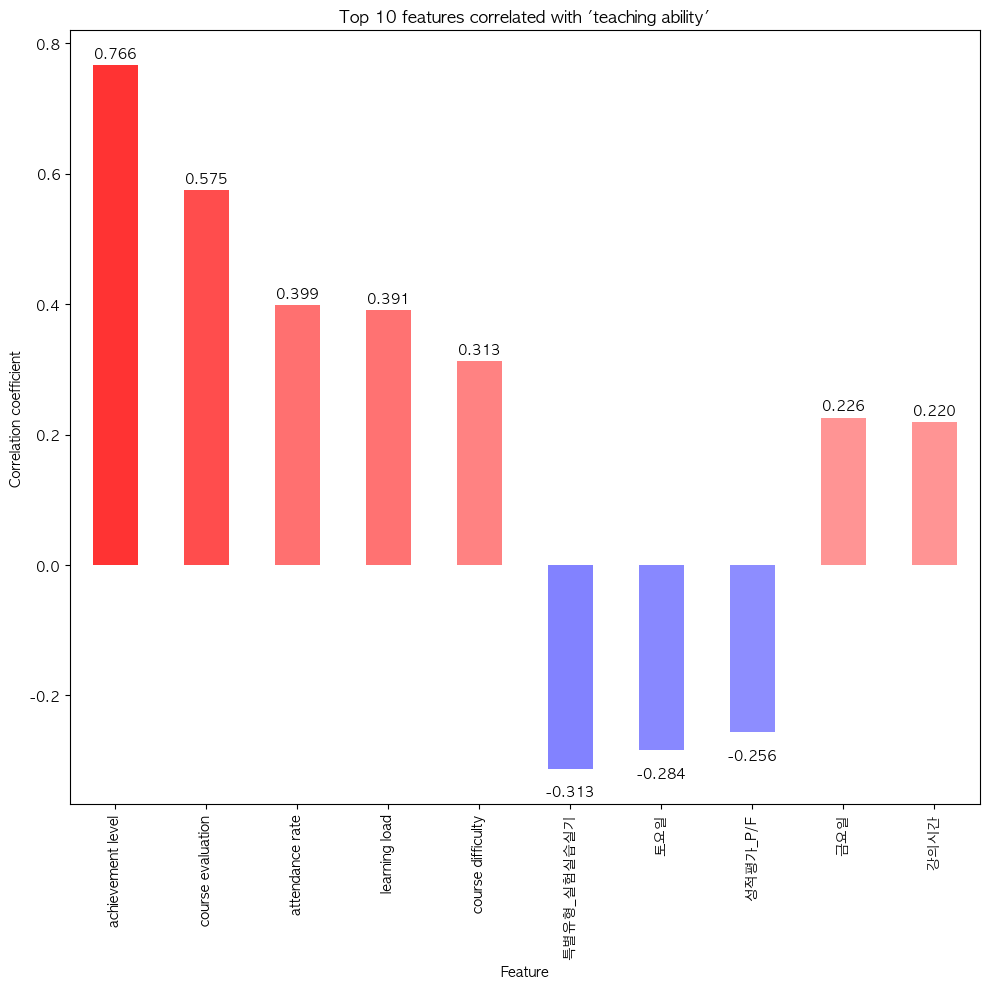

Cluster 1


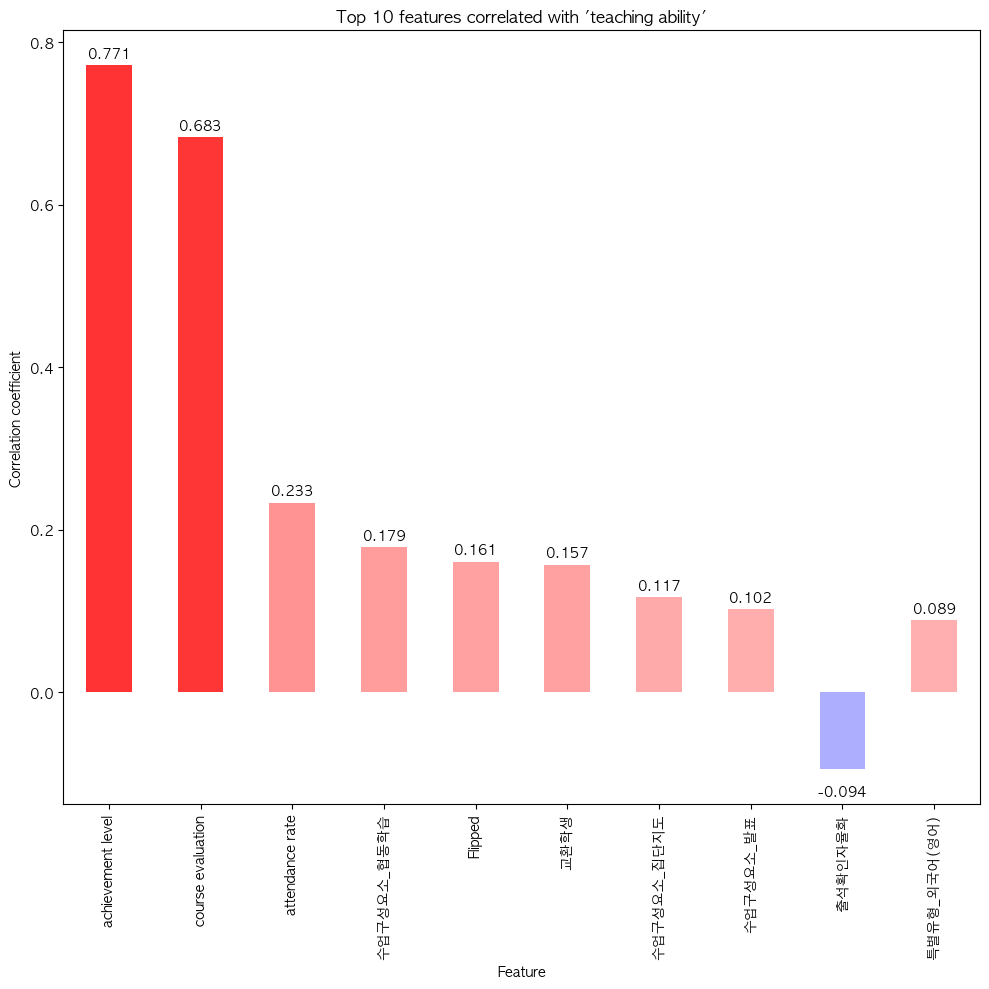

Cluster 2


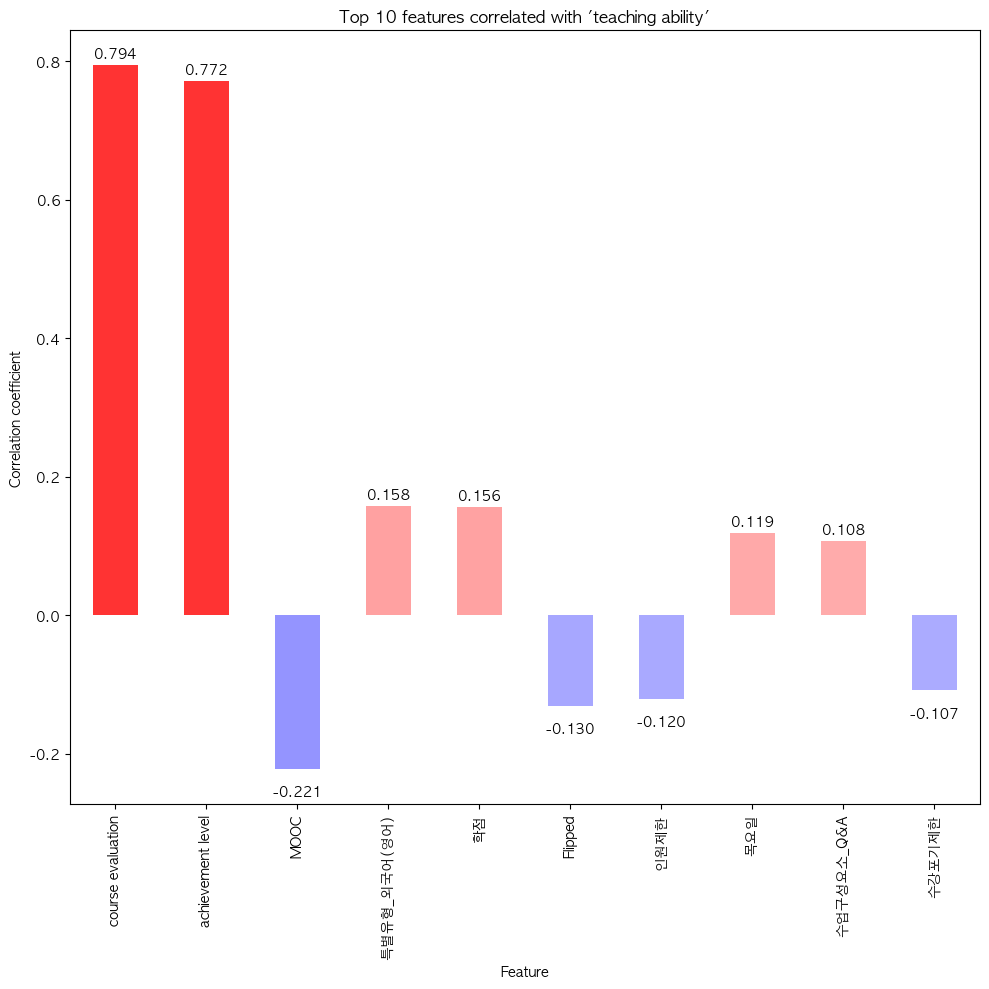

Cluster 3


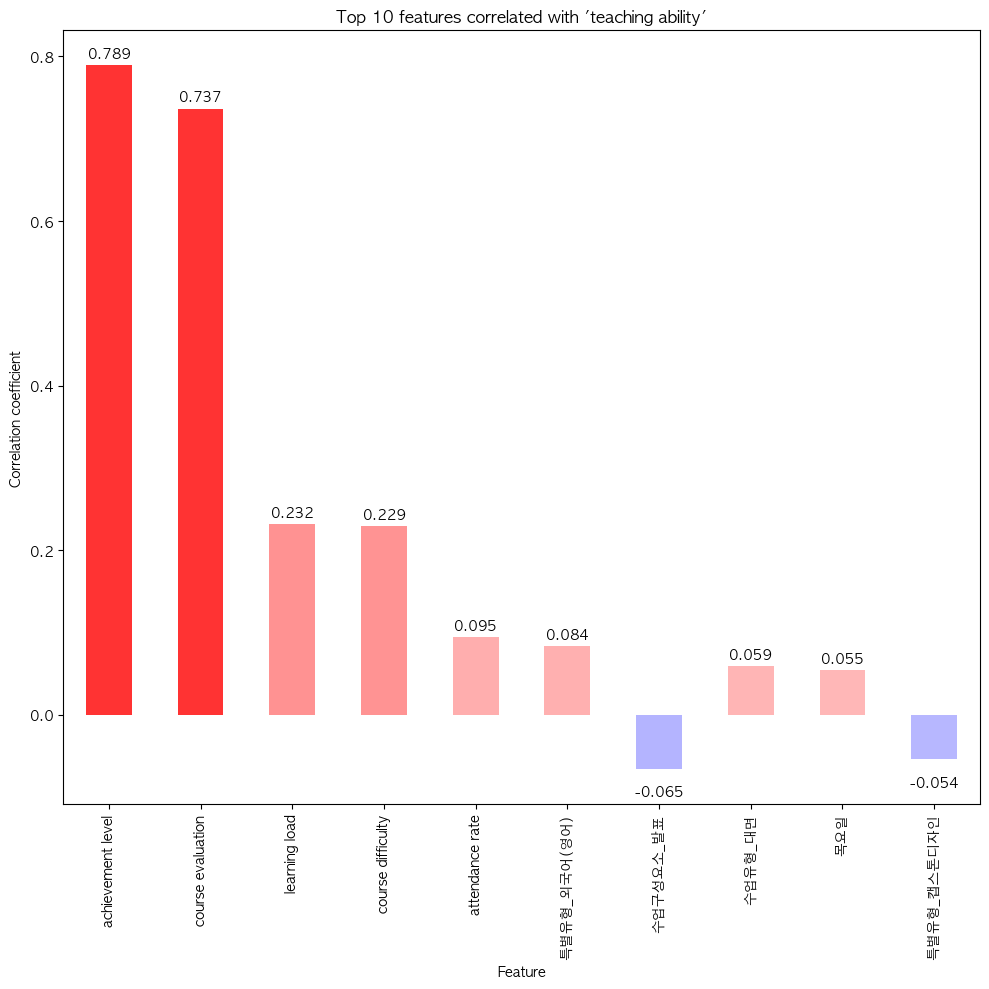

Cluster 4


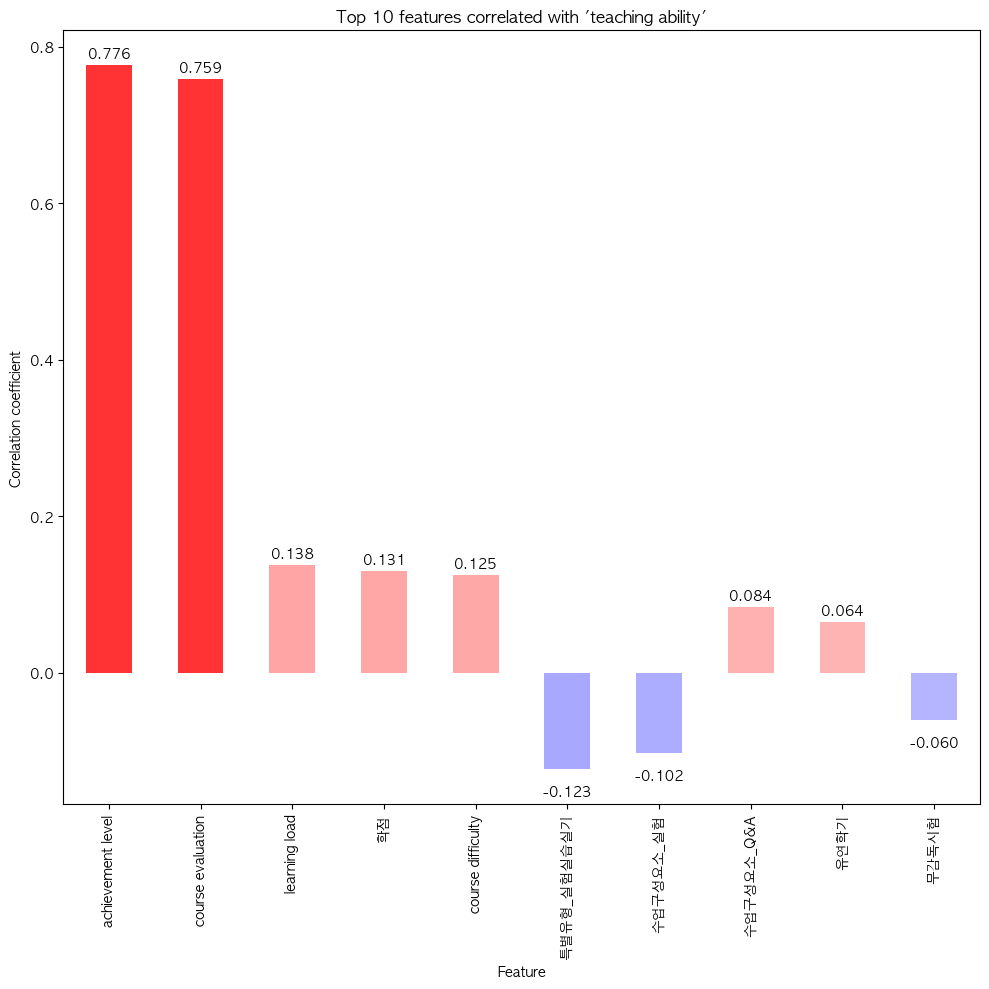

Cluster 5


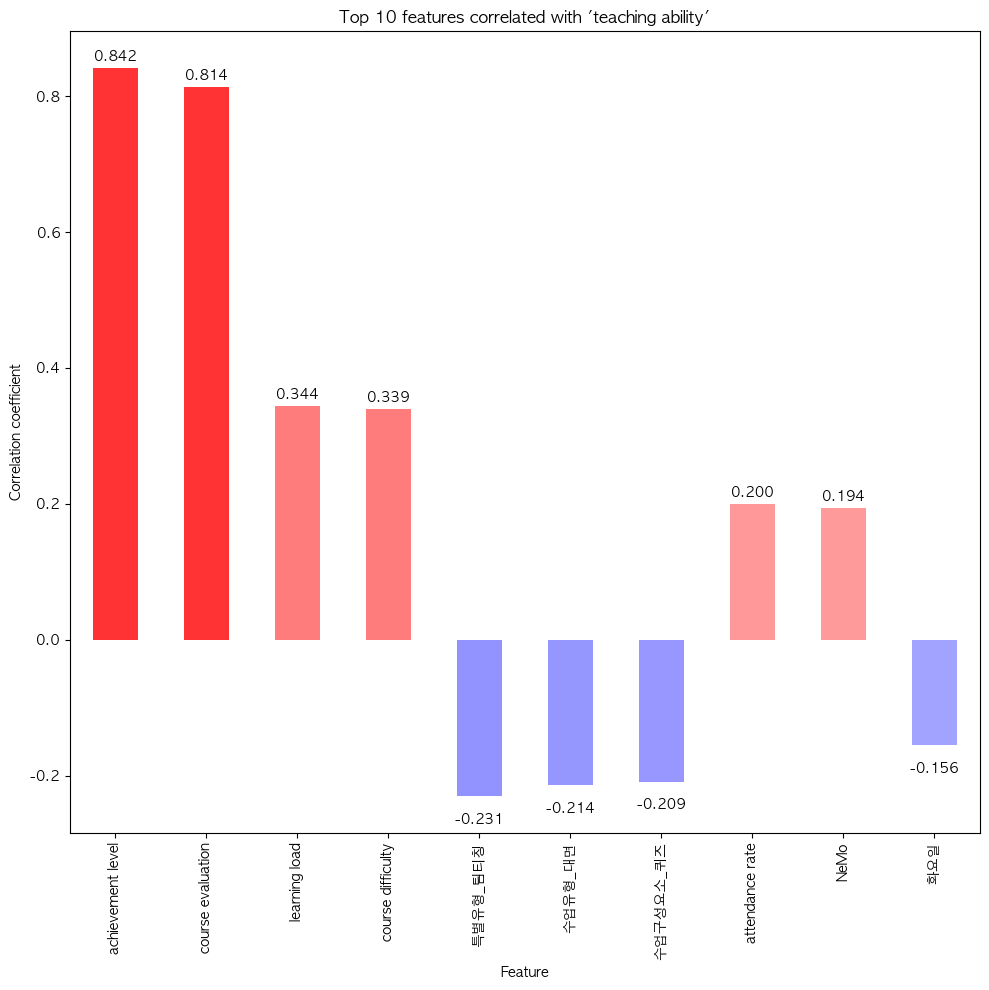

Cluster -1


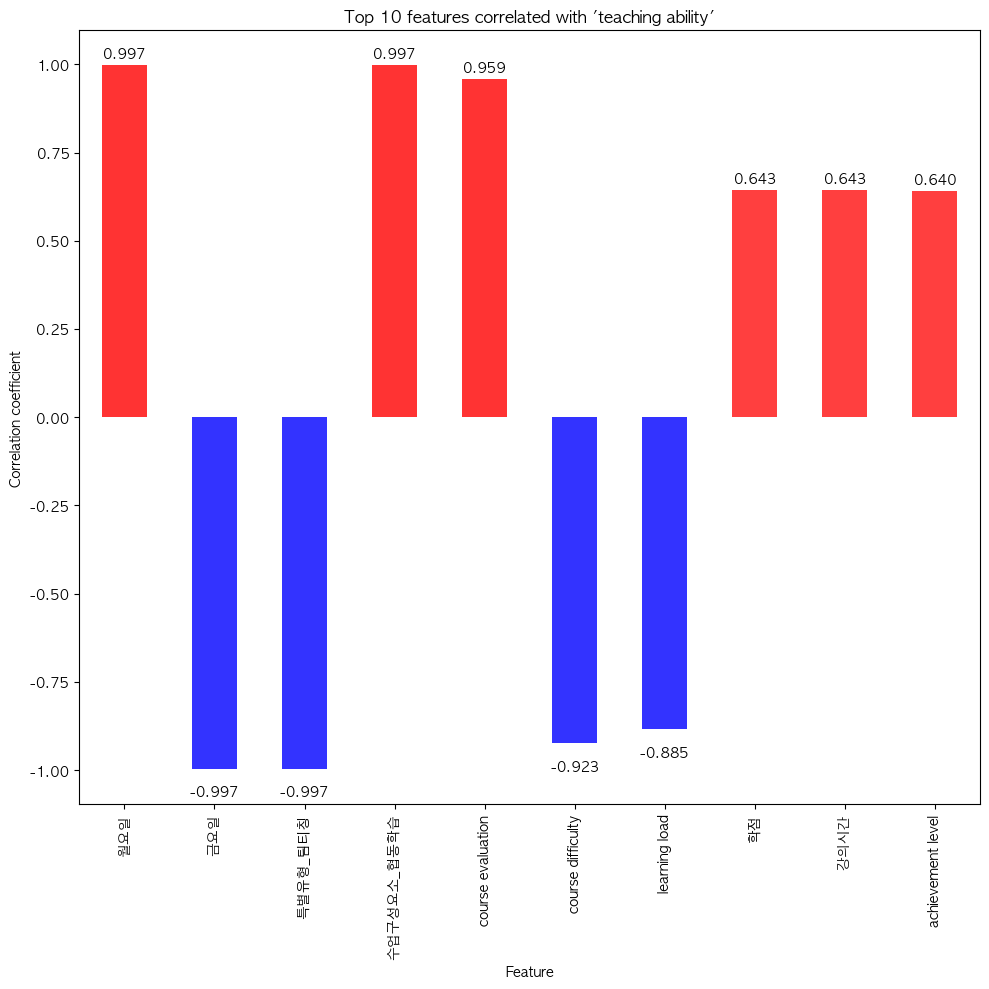

In [113]:
for c in list(set(clusters)):
    print(f'Cluster {c}')
    plot_top_k_correlations('teaching ability', preprocess(each_cluster[c]).corr())

In [35]:
cluster2feature = {
    0 : '이수구분.교직', 
    1 : '이수구분.없음', 
    2 : '이수구분.학문의기초', 
    3 : '이수구분.전공선택', 
    4 : '이수구분.전공필수', 
    5 : '이수구분.학부공통', 
    -1 : 'Outlier', 
}

# idx_s = list(data.columns).index('course evaluation')
# idx_e = list(data.columns).index('')

features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']

for c, df in each_cluster.items():
    print(f'Cluster label {c} : {cluster2feature[c]}')
    temp = copy.deepcopy(df)
    temp['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in temp['recommendation rate']]
    temp = temp[features]
    
    desc = temp.describe().T[['mean', '50%', 'std']]
    desc.rename(columns={'50%': 'median'}, inplace=True)
    print(desc[['mean', 'median', 'std']])
    print()

Cluster label 0 : 이수구분.교직
                         mean  median       std
course evaluation    4.291935   4.400  0.441349
attendance rate      0.865323   1.000  0.211442
learning load        2.861613   2.900  0.757173
course difficulty    2.599355   2.600  0.596646
teaching ability     3.841290   4.000  0.712013
achievement level    3.430000   3.600  0.631101
recommendation rate  0.519381   0.526  0.200091

Cluster label 1 : 이수구분.없음
                         mean  median       std
course evaluation    4.222761     4.3  0.509457
attendance rate      0.845425     1.0  0.212921
learning load        3.099294     3.2  0.788319
course difficulty    2.825538     2.8  0.671925
teaching ability     3.880417     4.0  0.675647
achievement level    3.514446     3.6  0.597880
recommendation rate  0.499725     0.5  0.203745

Cluster label 2 : 이수구분.학문의기초
                         mean  median       std
course evaluation    3.996473  4.1000  0.606692
attendance rate      0.784232  0.7500  0.244737
learn

# Clustering by 수업구성요소

In [65]:
list(data.columns).index('수업구성요소_Q&A')
data.iloc[0, 49:]

수업구성요소_Q&A      True
수업구성요소_개별지도    False
수업구성요소_발표       True
수업구성요소_실습       True
수업구성요소_실험      False
수업구성요소_이론강의     True
수업구성요소_집단지도     True
수업구성요소_퀴즈       True
수업구성요소_토론       True
수업구성요소_협동학습     True
성적평가_P/F       False
성적평가_절대평가      False
Name: 0, dtype: object

In [ ]:
# import dbcv

import tqdm

from sklearn.metrics import jaccard_score

data = load_data()
# boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns.extend([f for f in data.columns if '이수구분' in f])
# boolean_columns = [f for f in data.columns if '이수구분' in f]


# data_boolean = data[boolean_columns]
data_boolean = data.iloc[:, 49:]
# print(data_boolean.head())

# edit
# data_boolean = data_boolean.astype({col: int for col in data_boolean.select_dtypes(include='bool').columns})

data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))
# print([type(d) for d in list(data_boolean[0])])
print(data_boolean.shape)


eps_space = []
# for i in range(1, 10):
#     eps_space.append(i * 0.01)
# for i in range(1, 10):
    # eps_space.append(i * 0.1)
eps_space.append(0.1)
for i in range(1, 10):
    eps_space.append(i)
# min_samples_space = [5, 10, 15, 20, 25, 30, 35]
min_samples_space = [5]

max_silhouette = 0
best_eps = 0
best_min_samples = 0
best_cluster_cnt = 0
best_dunn = 0

table = pt.PrettyTable()
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dunn index', 'cluster_cnt']
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dbcv', 'cluster_cnt']
table.field_names = ['eps', 'min_samples', 'silhouette', 'cluster_cnt']

flag = False

for e in tqdm.tqdm(eps_space):
    for m in min_samples_space:
        try:
            dbscan = DBSCAN(
                eps=e,
                min_samples=m,
                # metric=jaccard_distance  # Required for non-Euclidean metrics
                metric='manhattan'
            )
            clusters = dbscan.fit_predict(data_boolean)
            labels = set(clusters)

            silhouette_avg = silhouette_score(data_boolean, clusters)
            # dbcv_score = dbcv.dbcv(data_boolean, clusters, check_duplicates=False)


            # dunn_index = base.dunn(list(for_dunn.values()))

            # info = [e, m, silhouette_avg, dunn_index, len(labels)]
            # info = [e, m, silhouette_avg, dbcv_score, len(labels)]
            info = [e, m, silhouette_avg, len(labels)]
            table.add_row(info)
        except Exception as e:
            print(e)
            flag = True
            break
    if flag:
        break


print(table)



<ipython-input-4-0c262767a7cb>:14: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


15380
(15380, 12)


 20%|██        | 2/10 [00:31<02:04, 15.58s/it]

Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
+-----+-------------+---------------------+-------------+
| eps | min_samples |      silhouette     | cluster_cnt |
+-----+-------------+---------------------+-------------+
| 0.1 |      5      |  0.9355675522569029 |     239     |
|  1  |      5      | 0.24675940093654458 |      3      |
+-----+-------------+---------------------+-------------+


In [12]:
dbscan = DBSCAN(
    eps=1,
    min_samples=5,
    # metric=jaccard_distance  # Required for non-Euclidean metrics
    metric='manhattan'
)
clusters = dbscan.fit_predict(data_boolean)

show_cluster_stats(clusters)

+---------------+---------------------+
| cluster label | data instance count |
+---------------+---------------------+
|       -1      |          7          |
|       0       |        15368        |
|       1       |          5          |
+---------------+---------------------+


<ipython-input-4-0c262767a7cb>:33: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('./uptodate_binary.csv').dropna()


In [8]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='manhattan')
test = clusterer.fit(data_boolean)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
test.labels_

array([155, 158,  29, ..., 329, 355, 325])

# Clustering by Numerical Data(KLUE 강의평점들)

In [17]:
data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data.iloc[0]

15380


<ipython-input-4-0c262767a7cb>:14: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


course evaluation      0.760
attendance rate        0.750
learning load          0.640
course difficulty      0.520
teaching ability       0.560
achievement level      0.660
recommendation rate    0.083
Name: 0, dtype: float64

In [18]:
import dbcv

import tqdm

from sklearn.metrics import jaccard_score

data = load_data()
# boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns = ['course evaluation', 'achievement level']
# boolean_columns.extend([f for f in data.columns if '이수구분' in f])
# boolean_columns = [f for f in data.columns if '이수구분' in f]


# data_boolean = data[boolean_columns]
# data_boolean = data.iloc[:, 49:]
# print(data_boolean.head())
data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]

data_boolean = data

# edit
# data_boolean = data_boolean.astype({col: int for col in data_boolean.select_dtypes(include='bool').columns})

# data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))
# print([type(d) for d in list(data_boolean[0])])
print(data_boolean.shape)


eps_space = []
# for i in range(1, 10):
#     eps_space.append(i * 0.01)
for i in range(1, 10):
    eps_space.append(i * 0.1)
# eps_space.append(0.1)
for i in range(1, 10):
    eps_space.append(i)
# min_samples_space = [5, 10, 15, 20, 25, 30, 35]
min_samples_space = [5]

max_silhouette = 0
best_eps = 0
best_min_samples = 0
best_cluster_cnt = 0
best_dunn = 0

table = pt.PrettyTable()
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dunn index', 'cluster_cnt']
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dbcv', 'cluster_cnt']
table.field_names = ['eps', 'min_samples', 'silhouette', 'cluster_cnt']

flag = False

for e in tqdm.tqdm(eps_space):
    for m in min_samples_space:
        try:
            dbscan = DBSCAN(
                eps=e,
                min_samples=m,
                # metric=jaccard_distance  # Required for non-Euclidean metrics
                metric='euclidean'
            )
            clusters = dbscan.fit_predict(data_boolean)
            labels = set(clusters)

            silhouette_avg = silhouette_score(data_boolean, clusters)
            # dbcv_score = dbcv.dbcv(data_boolean, clusters, check_duplicates=False)


            # dunn_index = base.dunn(list(for_dunn.values()))

            # info = [e, m, silhouette_avg, dunn_index, len(labels)]
            # info = [e, m, silhouette_avg, dbcv_score, len(labels)]
            info = [e, m, silhouette_avg, len(labels)]
            table.add_row(info)
        except Exception as e:
            print(e)
            flag = True
            break
    if flag:
        break


print(table)



<ipython-input-4-0c262767a7cb>:14: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


15380


<ipython-input-4-0c262767a7cb>:14: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


15380
(15380, 7)


 17%|█▋        | 3/18 [00:25<02:07,  8.49s/it]

Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
+---------------------+-------------+----------------------+-------------+
|         eps         | min_samples |      silhouette      | cluster_cnt |
+---------------------+-------------+----------------------+-------------+
|         0.1         |      5      | -0.11570888194726799 |      19     |
|         0.2         |      5      | 0.13105891502476852  |      6      |
| 0.30000000000000004 |      5      | 0.45416122491818994  |      2      |
+---------------------+-------------+----------------------+-------------+


In [83]:
data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]

data_boolean = data

dbscan = DBSCAN(
    eps=0.2,
    min_samples=5,
    # metric=jaccard_distance  # Required for non-Euclidean metrics
    metric='euclidean'
)
clusters = dbscan.fit_predict(data_boolean)

show_cluster_stats(clusters)

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_16479/1813310369.py:19: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_binary.csv')


15380
+---------------+---------------------+
| cluster label | data instance count |
+---------------+---------------------+
|       -1      |          59         |
|       0       |         4512        |
|       1       |         6733        |
|       2       |         1213        |
|       3       |         2728        |
|       4       |         135         |
+---------------+---------------------+


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_16479/1813310369.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('../data/uptodate_binary.csv').dropna()


In [87]:
data = load_data()

# features = [f for f in data.columns if ('이수구분' in f or '수업구성요소' in f)]
# features = [f for f in data.columns if ('이수구분' in f)]
features = [f for f in data.columns if ('수업구성요소' in f)]

# show_feature_stats(data_boolean, features, clusters, True)
show_feature_stats(data, features, clusters, False)

15380
+-----+---------------------+------------------+-----------------------+-------------------+-------------------+-------------------+-----------------------+-----------------------+-------------------+-------------------+-----------------------+
| idx | data instance count | 수업구성요소_Q&A | 수업구성요소_개별지도 | 수업구성요소_발표 | 수업구성요소_실습 | 수업구성요소_실험 | 수업구성요소_이론강의 | 수업구성요소_집단지도 | 수업구성요소_퀴즈 | 수업구성요소_토론 | 수업구성요소_협동학습 |
+-----+---------------------+------------------+-----------------------+-------------------+-------------------+-------------------+-----------------------+-----------------------+-------------------+-------------------+-----------------------+
|  -1 |          59         |        5         |           12          |         7         |         10        |         1         |           39          |           11          |         8         |         7         |           5           |
|  0  |         4512        |       969        |          673          |        1813       |        

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_16479/862301514.py:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_binary.csv')


In [88]:
# data = load_data()

# features = [f for f in data.columns if ('이수구분' in f or '수업구성요소' in f)]
# features = [f for f in data.columns if ('이수구분' in f)]
# features = [f for f in data.columns if ('수업구성요소' in f)]
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']

show_feature_stats(data_boolean, features, clusters, True)
# show_feature_stats(data, features, clusters, False)

+-----+---------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+
| idx | data instance count | course evaluation  |  attendance rate   |   learning load    |  course difficulty  |  teaching ability  | achievement level  | recommendation rate |
+-----+---------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+
|  -1 |          59         | 0.7976271186440678 | 0.2457627118644068 | 0.454237288135593  | 0.45830508474576265 | 0.6074576271186442 | 0.5491525423728815 | 0.41035593220338973 |
|  0  |         4512        | 0.8207579787234327 |        0.75        | 0.6738031914893604 |  0.6205230496453805 | 0.7493882978723502 | 0.7034441489361664 |  0.4578905141843992 |
|  1  |         6733        | 0.8406445863656694 |        1.0         | 0.667304321996137  |  0.608542997

In [94]:
features = ['course evaluation', 'attendance rate', 'learning load', 'course difficulty', 'teaching ability', 'achievement level', 'recommendation rate']

test = load_data()
test['clusters'] = clusters
each_cluster = {}
for c in list(set(clusters)):
    each_cluster[c] = test[test['clusters'] == c]

# plt.figure(figsize=(12, 6))
# for feature in features:
#     sns.kdeplot(each_cluster[0][feature], label=feature, fill=True, alpha=0.3)
# plt.title('Distribution of Numerical Features')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.show()


15380


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_16479/3882106720.py:19: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_binary.csv')


In [ ]:
# data = load_data

x = 'course evaluation'
y = 'achievement level'
covar = 'teaching ability'

print(f'x = {x}, y = {y}, covar = {covar}')
for c in list(set(clusters)):
    print(f'Cluster {c}')
    print(pg.partial_corr(data=each_cluster[c], x=x, y=y, covar=covar, method='pearson'))

x = course evaluation, y = achievement level, covar = teaching ability
Cluster 0
            n         r         CI95%         p-val
pearson  4512  0.189536  [0.16, 0.22]  9.410863e-38
Cluster 1
            n        r         CI95%         p-val
pearson  6733  0.24439  [0.22, 0.27]  3.971309e-92
Cluster 2
            n         r          CI95%     p-val
pearson  1213 -0.031092  [-0.09, 0.03]  0.279446
Cluster 3
            n         r         CI95%     p-val
pearson  2728  0.092611  [0.06, 0.13]  0.000001
Cluster 4
           n         r         CI95%     p-val
pearson  135  0.190851  [0.02, 0.35]  0.027181
Cluster -1
          n         r         CI95%     p-val
pearson  59  0.266646  [0.01, 0.49]  0.043042


In [ ]:
# data = load_data

x = 'teaching ability'
y = 'achievement level'
covar = 'course evaluation'

print(f'x = {x}, y = {y}, covar = {covar}')
for c in list(set(clusters)):
    print(f'Cluster {c}')
    print(pg.partial_corr(data=each_cluster[c], x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = achievement level, covar = course evaluation
Cluster 0
            n         r         CI95%  p-val
pearson  4512  0.561929  [0.54, 0.58]    0.0
Cluster 1
            n         r         CI95%  p-val
pearson  6733  0.541679  [0.52, 0.56]    0.0
Cluster 2
            n         r         CI95%          p-val
pearson  1213  0.695643  [0.67, 0.72]  5.150224e-176
Cluster 3
            n        r         CI95%          p-val
pearson  2728  0.63051  [0.61, 0.65]  3.415482e-302
Cluster 4
           n        r        CI95%         p-val
pearson  135  0.60016  [0.48, 0.7]  1.804127e-14
Cluster -1
          n         r         CI95%    p-val
pearson  59  0.374071  [0.13, 0.58]  0.00382


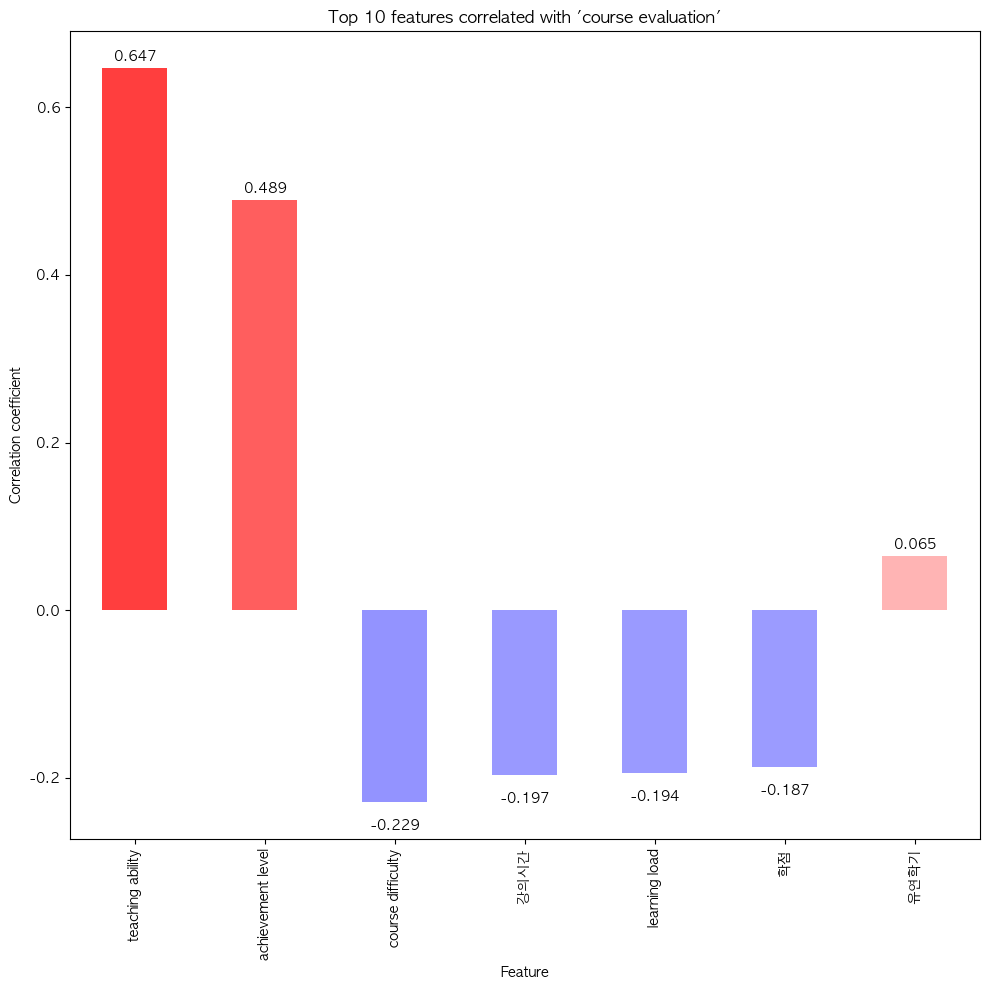

In [103]:
# pre = preprocess(each_cluster[2])
plot_top_k_correlations('course evaluation', preprocess(each_cluster[2]).corr())

[0 1 0 ... 0 0 1]


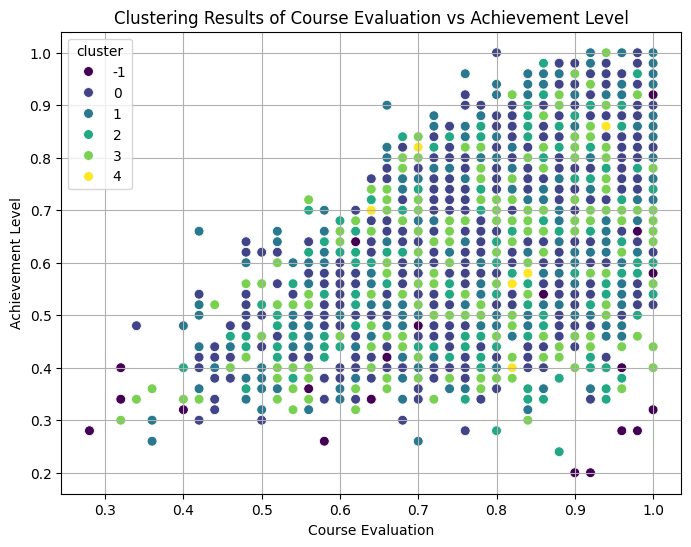

In [41]:

# Create a DataFrame for plotting
xydata = data[['course evaluation', 'achievement level']]

plot_data = pd.DataFrame(xydata, columns=['course evaluation', 'achievement level'])
plot_data['cluster'] = clusters
print(clusters)

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='course evaluation',
    y='achievement level',
    hue='cluster',
    data=plot_data,
    palette='viridis', # You can choose other color palettes
    legend='full',
    s=50 # Marker size
)
plt.title('Clustering Results of Course Evaluation vs Achievement Level')
plt.xlabel('Course Evaluation')
plt.ylabel('Achievement Level')
plt.grid(True)
plt.show()


# kMeans

In [45]:
import dbcv

import tqdm

from sklearn.metrics import jaccard_score

data = load_data()
boolean_columns = [f for f in data.columns if '이수구분' in f]

data_boolean = data[boolean_columns]

data_boolean = np.array([data_boolean.iloc[i] for i in range(len(data_boolean))]).reshape(-1, len(data_boolean.iloc[0]))
print(data_boolean.shape)

n_cluster_space = []
for i in range(2, 10):
    n_cluster_space.append(i)

max_silhouette = 0
best_eps = 0
best_min_samples = 0
best_cluster_cnt = 0
best_dunn = 0

table = pt.PrettyTable()
# table.field_names = ['eps', 'min_samples', 'silhouette', 'dunn index', 'cluster_cnt']
# table.field_names = ['eps', 'min_samples', 'silhouette', 'cluster_cnt']
table.field_names = ['n_clusters', 'silhouette']

flag = False

for n in tqdm.tqdm(n_cluster_space):
    try:
        # dbscan = DBSCAN(
        #     eps=e,
        #     min_samples=m,
        #     # metric=jaccard_distance  # Required for non-Euclidean metrics
        #     metric='manhattan'
        # )
        clusterer = KMeans(n_clusters=n)
        clusters = clusterer.fit_predict(data_boolean)

        # clusters = dbscan.fit_predict(data_boolean)
        # clusters = dbscan.fit_predict(data_boolean)
        # labels = set(clusters)

        silhouette_avg = silhouette_score(data_boolean, clusters)


        # dunn_index = base.dunn(list(for_dunn.values()))

        # info = [e, m, silhouette_avg, dunn_index, len(labels)]
        info = [n, silhouette_avg]
        table.add_row(info)
    except Exception as e:
        print(e)
        flag = True
        break



print(table)



<ipython-input-44-3cc943ca5755>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


15380
(15380, 7)


 75%|███████▌  | 6/8 [00:20<00:06,  3.15s/it]/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 88%|████████▊ | 7/8 [00:23<00:03,  3.08s/it]/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 8/8 [00:26<00:00,  3.34s/it]

+------------+--------------------+
| n_clusters |     silhouette     |
+------------+--------------------+
|     2      | 0.7274375823575713 |
|     3      | 0.9049716292436848 |
|     4      | 0.9522468444152217 |
|     5      | 0.9667901030882347 |
|     6      | 0.9995562327347064 |
|     7      |        1.0         |
|     8      |        1.0         |
|     9      |        1.0         |
+------------+--------------------+


In [75]:
clusterer = KMeans(n_clusters=7)
clusters = clusterer.fit_predict(data_boolean)


show_cluster_stats(clusters)

+---------------+---------------------+
| cluster label | data instance count |
+---------------+---------------------+
|       -1      |          0          |
|       0       |         1262        |
|       1       |         839         |
|       2       |         3724        |
|       3       |         1852        |
|       4       |         3539        |
|       5       |         2138        |
+---------------+---------------------+


<ipython-input-53-86ac9d110395>:36: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('./uptodate_binary.csv').dropna()


In [76]:
data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]

data_boolean = data

show_feature_stats(data_boolean, features, clusters, True, False)

temp = list(data.columns)
features = [t for t in temp if '이수구분' in t]

show_feature_stats(data_boolean, features, clusters, False, False)

<ipython-input-53-86ac9d110395>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


15380
+-----+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
| idx | data instance count | course evaluation  |   attendance rate   |   learning load    | course difficulty  |  teaching ability  | achievement level  | recommendation rate |
+-----+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|  0  |         1262        | 0.8787004754358173 |  0.5750792393026941 | 0.7130586370839931 | 0.6609350237717916 | 0.8474484944532492 | 0.7798573692551504 |  0.5807218700475438 |
|  1  |         839         | 0.7978069129916561 | 0.47497020262216927 | 0.5515137067938025 | 0.5152562574493439 | 0.652562574493445  | 0.5912514898688914 |  0.3784755661501787 |
|  2  |         3724        | 0.8253007518797251 |  0.8803705692803437 | 0.7129001074113855 | 0.655

In [77]:
data = load_data()

features = [f for f in data.columns if '이수구분' in f]
print(features)
show_feature_stats(data, features, clusters, False, False)

15380
['이수구분.교직', '이수구분.교직(비사대)', '이수구분.군사학', '이수구분.전공선택', '이수구분.전공필수', '이수구분.학문의기초', '이수구분.학부공통']
+-----+---------------------+---------------+-----------------------+-----------------+-------------------+-------------------+---------------------+-------------------+
| idx | data instance count | 이수구분.교직 | 이수구분.교직(비사대) | 이수구분.군사학 | 이수구분.전공선택 | 이수구분.전공필수 | 이수구분.학문의기초 | 이수구분.학부공통 |
+-----+---------------------+---------------+-----------------------+-----------------+-------------------+-------------------+---------------------+-------------------+
|  0  |         1262        |       0       |           0           |        0        |         0         |        758        |          0          |         0         |
|  1  |         839         |       0       |           0           |        0        |         0         |         0         |          0          |         0         |
|  2  |         3724        |       0       |           0           |        0        |        3724       

<ipython-input-53-86ac9d110395>:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


{np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)}


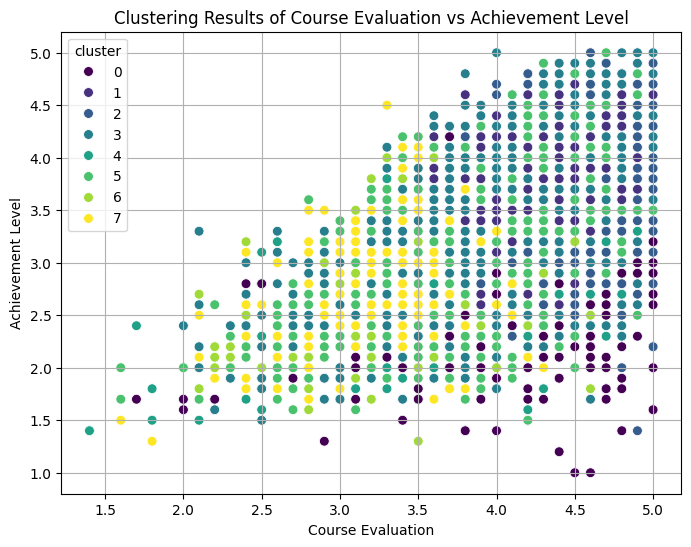

In [68]:
clusterer = KMeans(n_clusters=8)
clusters = clusterer.fit_predict(data_boolean)


xydata = data[['course evaluation', 'achievement level']]

plot_data = pd.DataFrame(xydata, columns=['course evaluation', 'achievement level'])
plot_data['cluster'] = clusters
print(set(clusters))

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='course evaluation',
    y='achievement level',
    hue='cluster',
    data=plot_data,
    palette='viridis', # You can choose other color palettes
    legend='full',
    s=50 # Marker size
)
plt.title('Clustering Results of Course Evaluation vs Achievement Level')
plt.xlabel('Course Evaluation')
plt.ylabel('Achievement Level')
plt.grid(True)
plt.show()

# Check Correlation

In [ ]:
x = 'course evaluation'
y = 'achievement level'
covar = 'teaching ability'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

In [ ]:
x = 'course evaluation'
y = 'achievement level'
covar = 'teaching ability'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

x = course evaluation, y = achievement level, covar = teaching ability
             n         r         CI95%          p-val
pearson  15380  0.174297  [0.16, 0.19]  3.582459e-105


In [ ]:
x = 'teaching ability'
y = 'achievement level'
covar = 'course evaluation'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = achievement level, covar = course evaluation
             n        r         CI95%  p-val
pearson  15380  0.58291  [0.57, 0.59]    0.0


In [ ]:
x = 'teaching ability'
y = 'course evaluation'
covar = 'achievement level'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = course evaluation, covar = achievement level
             n         r         CI95%  p-val
pearson  15380  0.476823  [0.46, 0.49]    0.0


In [23]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
na_counts = data.isna().sum()
# print(na_counts)
data = data.dropna()
# print(data.shape)
data = preprocess(data)

print(data.shape)

(15380, 51)


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/4290406976.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


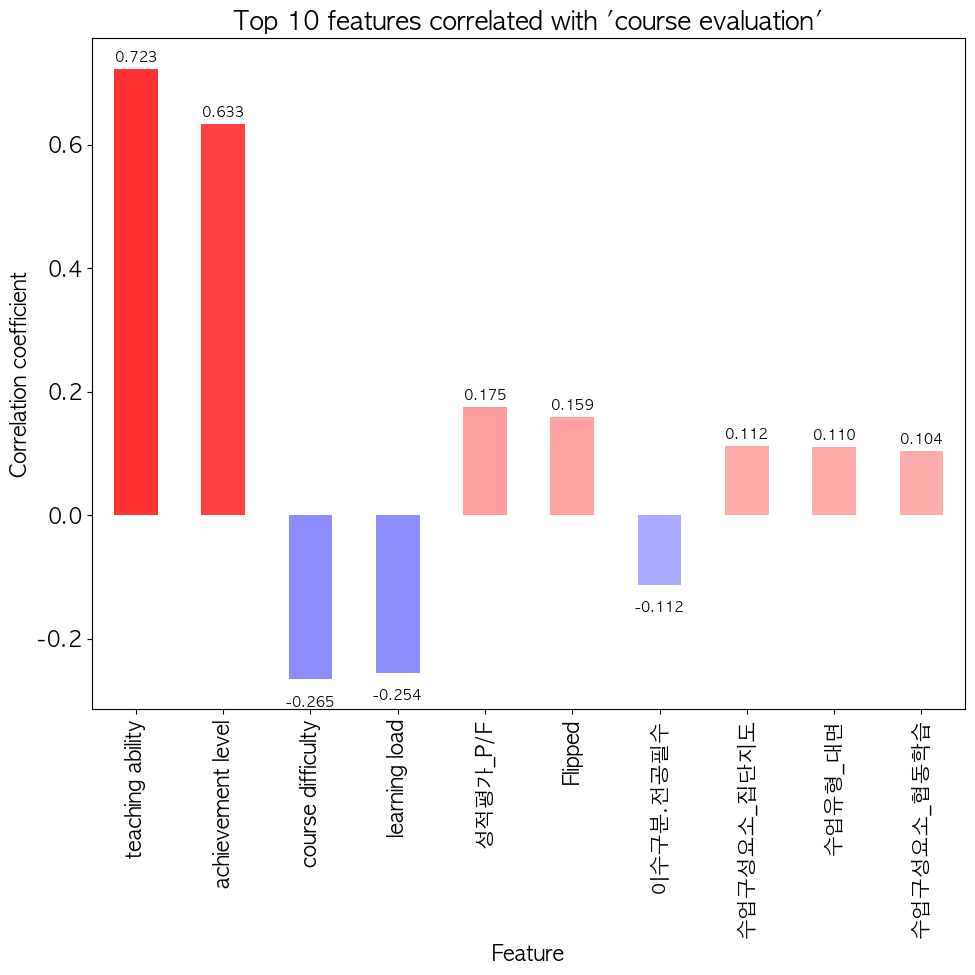

In [24]:
plot_top_k_correlations('course evaluation', data.corr())

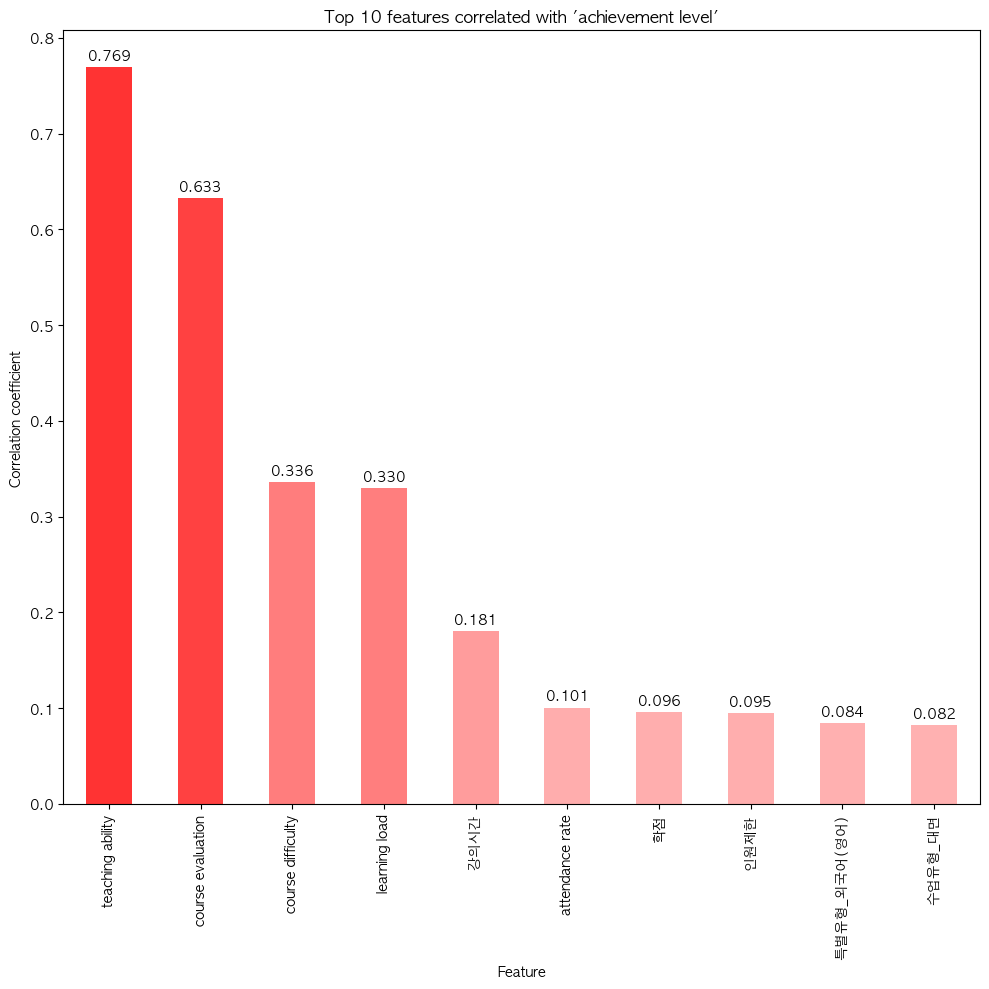

In [ ]:
plot_top_k_correlations('achievement level', data.corr())

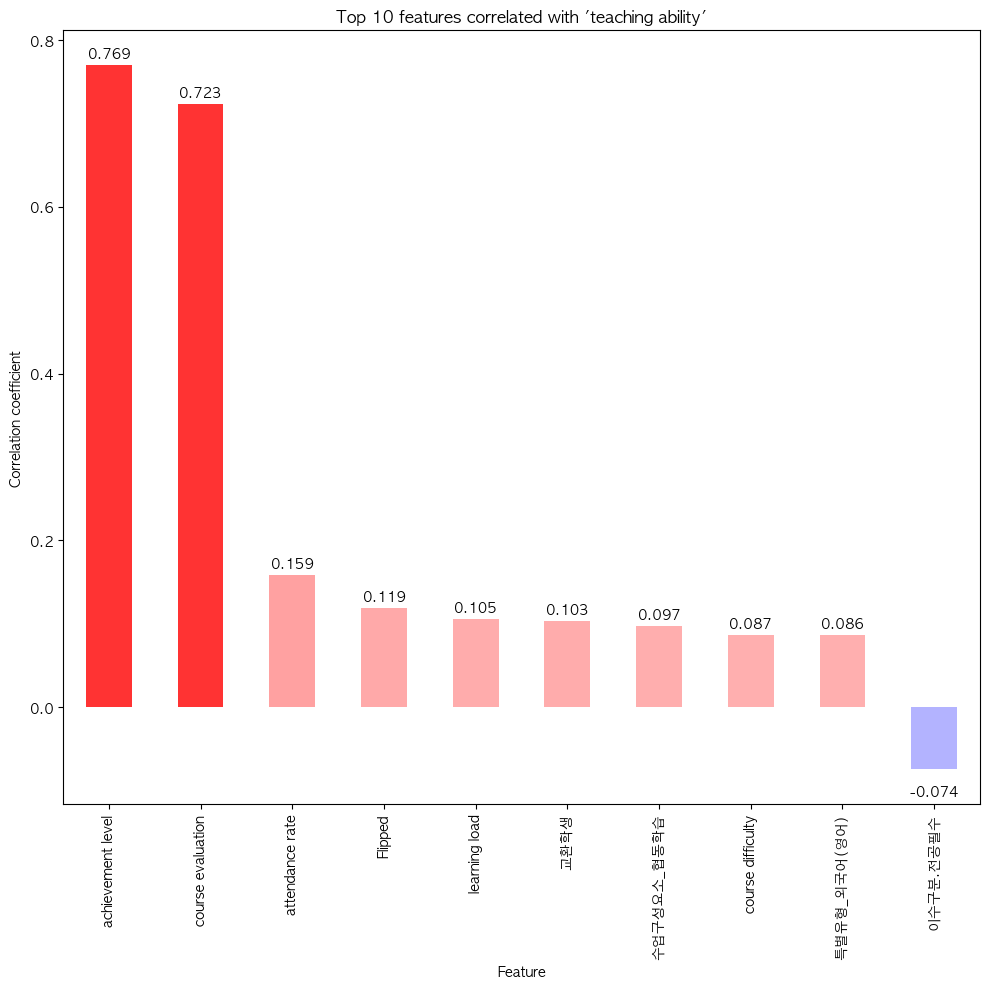

In [ ]:
plot_top_k_correlations('teaching ability', data.corr())

In [ ]:
x = 'course evaluation'
y = 'achievement level'
covar = 'teaching ability'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

x = course evaluation, y = achievement level, covar = teaching ability
             n         r         CI95%          p-val
pearson  15380  0.174297  [0.16, 0.19]  3.582459e-105


In [ ]:
x = 'teaching ability'
y = 'achievement level'
covar = 'course evaluation'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = achievement level, covar = course evaluation
             n        r         CI95%  p-val
pearson  15380  0.58291  [0.57, 0.59]    0.0


In [ ]:
x = 'teaching ability'
y = 'course evaluation'
covar = 'achievement level'

print(f'x = {x}, y = {y}, covar = {covar}')
print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))

x = teaching ability, y = course evaluation, covar = achievement level
             n         r         CI95%  p-val
pearson  15380  0.476823  [0.46, 0.49]    0.0


# Check Correlation (with Normalized Values)

In [25]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)

# draw_correlation_matrix(data.corr())

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/1584387021.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


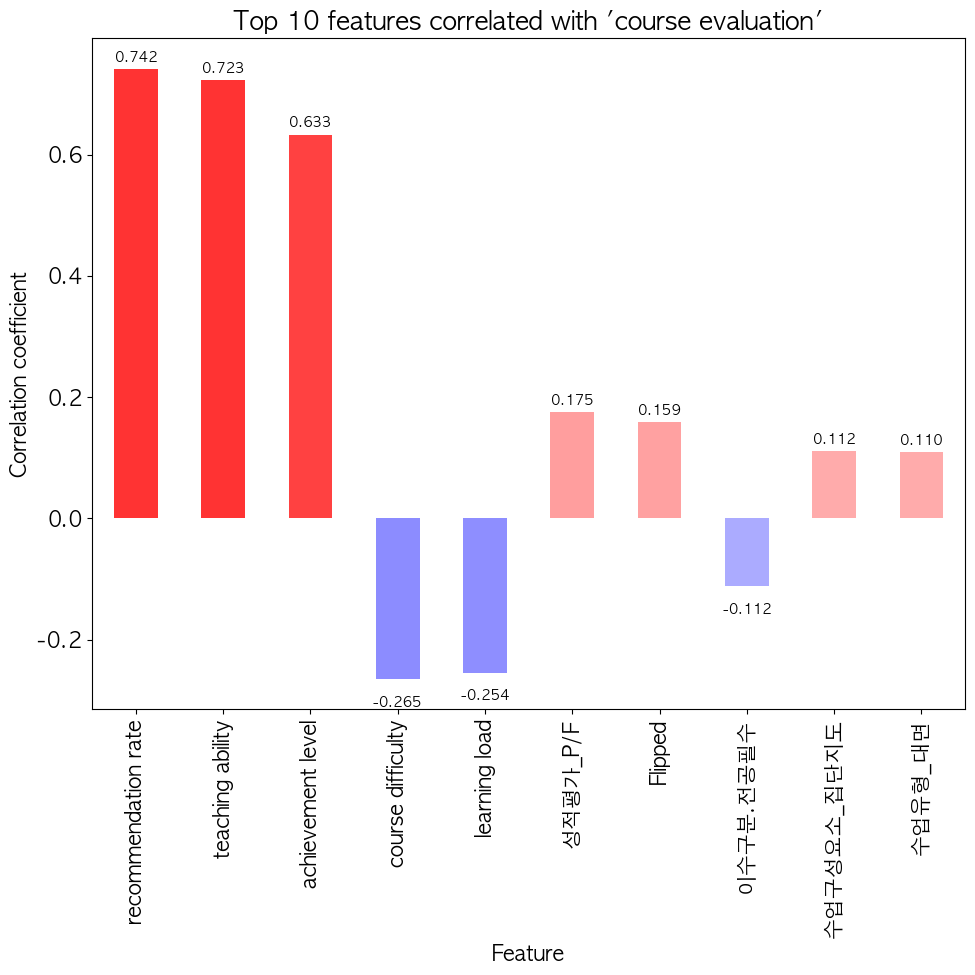

In [26]:
plot_top_k_correlations('course evaluation', data.corr())

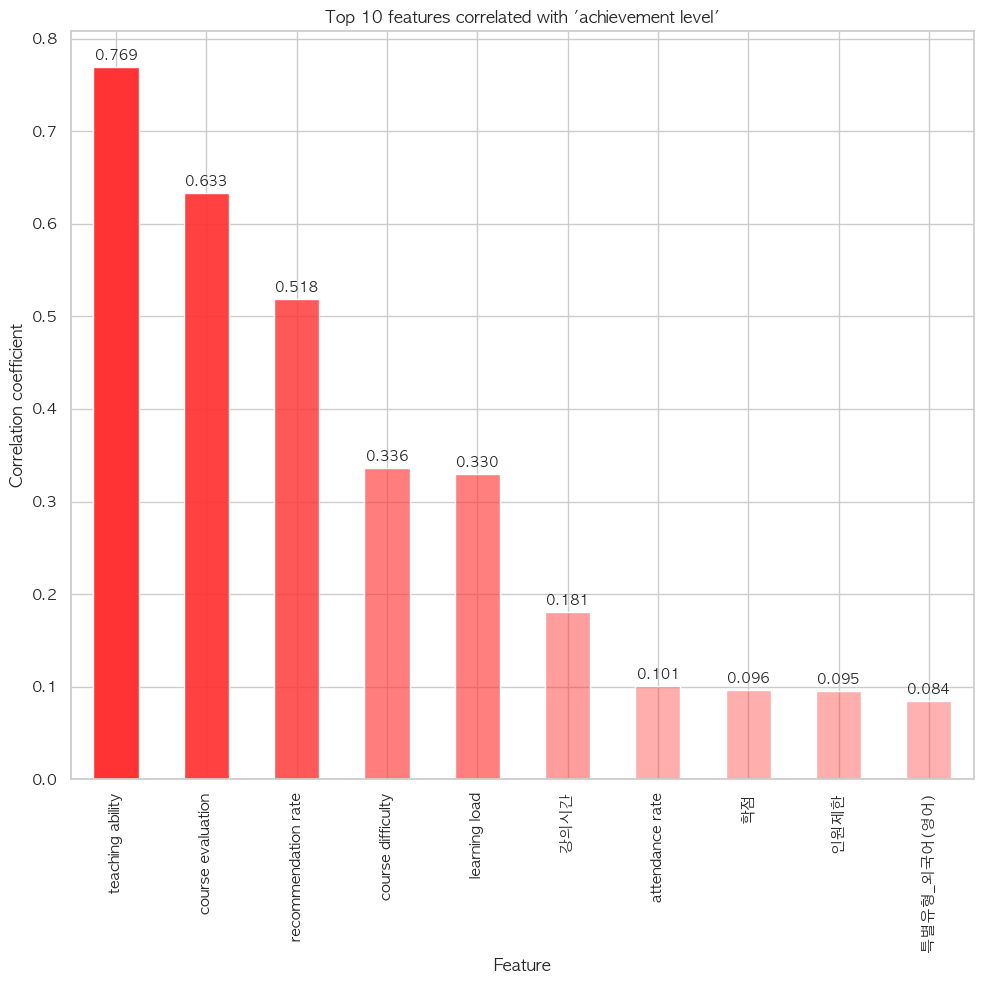

In [145]:
plot_top_k_correlations('achievement level', data.corr())

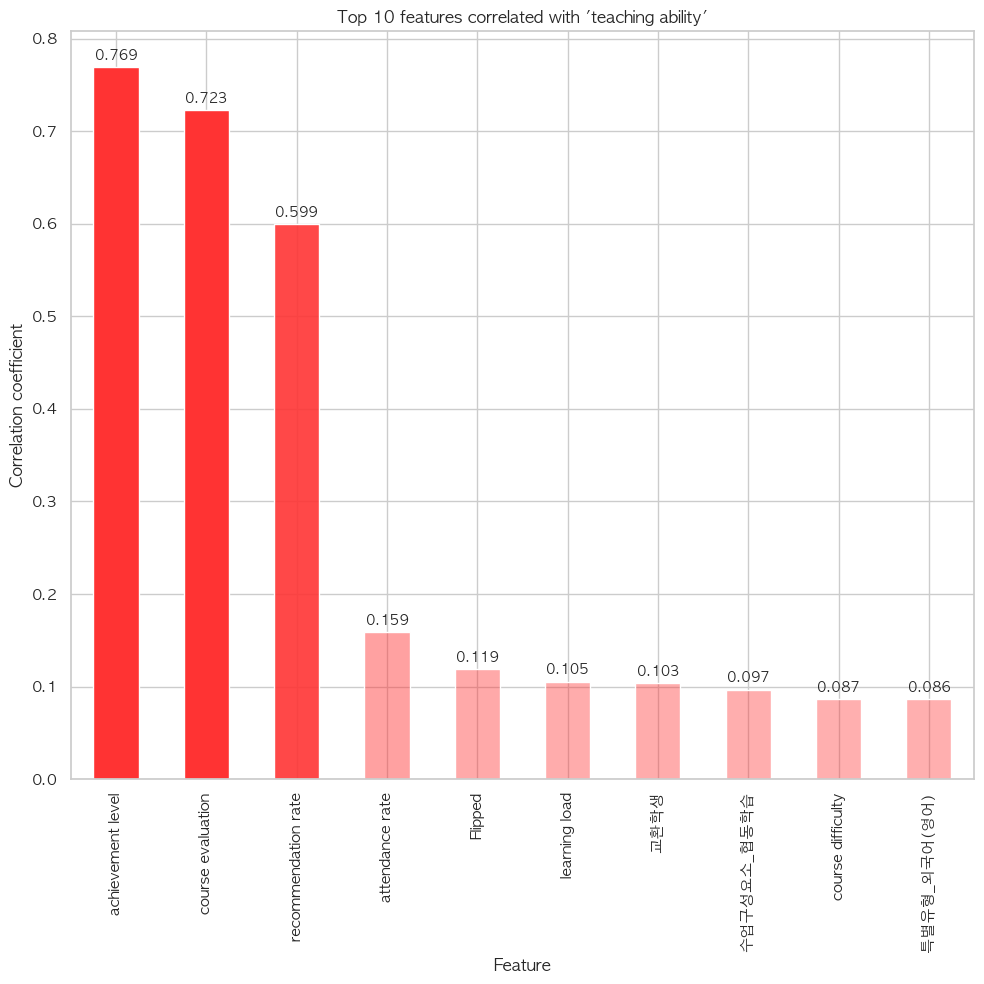

In [146]:
plot_top_k_correlations('teaching ability', data.corr())

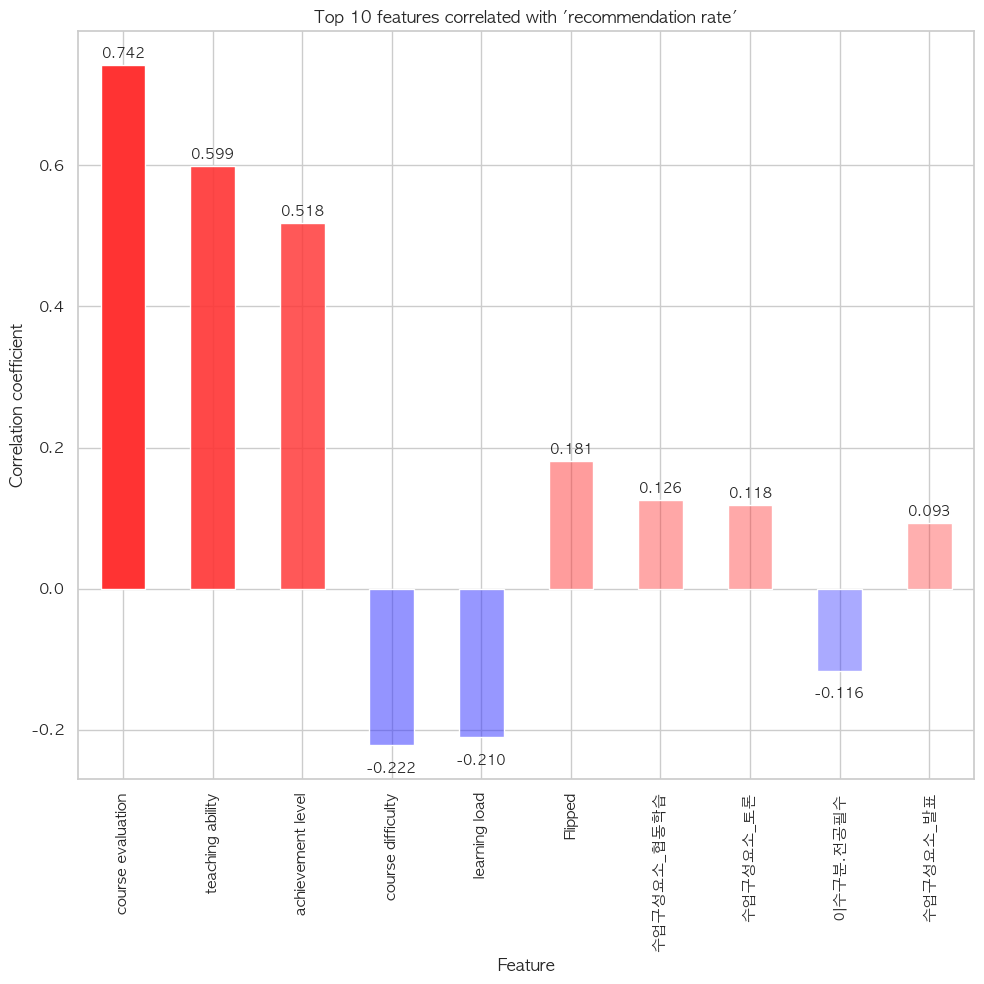

In [147]:
plot_top_k_correlations('recommendation rate', data.corr())

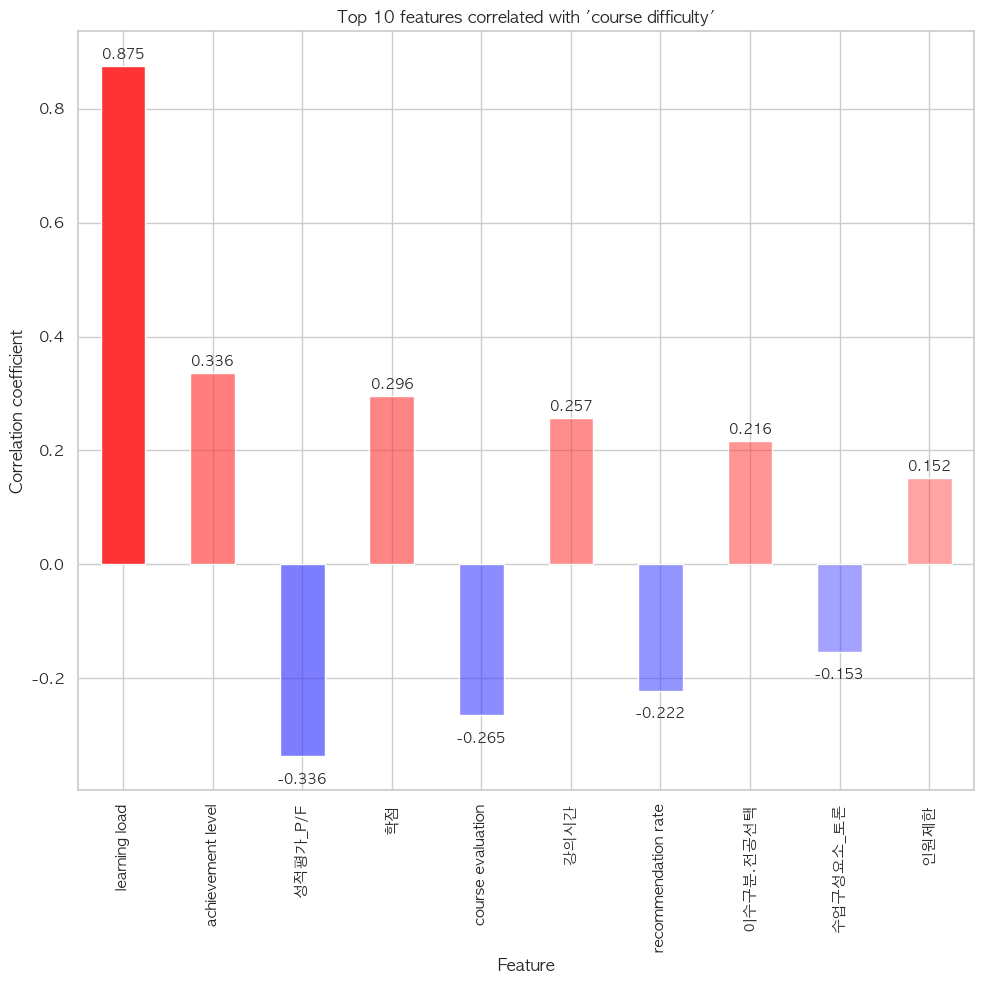

In [148]:
plot_top_k_correlations('course difficulty', data.corr())

In [149]:
features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']

for i in range(len(features)):
    t = [_ for _ in features if _ != features[i]]
    for covar in t:
        x, y = [_ for _ in t if _ != covar]
        print(f'x = {x}, y = {y}, covar = {covar}')
        print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'), data.corr()[x][y])
        print()

x = teaching ability, y = recommendation rate, covar = achievement level
             n         r         CI95%  p-val
pearson  15380  0.367172  [0.35, 0.38]    0.0 0.5994179659309934

x = achievement level, y = recommendation rate, covar = teaching ability
             n         r        CI95%         p-val
pearson  15380  0.111774  [0.1, 0.13]  6.011461e-44 0.5183805387726916

x = achievement level, y = teaching ability, covar = recommendation rate
             n         r         CI95%  p-val
pearson  15380  0.670209  [0.66, 0.68]    0.0 0.7694800159967551

x = teaching ability, y = recommendation rate, covar = course evaluation
             n         r         CI95%         p-val
pearson  15380  0.136484  [0.12, 0.15]  7.676577e-65 0.5994179659309934

x = course evaluation, y = recommendation rate, covar = teaching ability
             n         r         CI95%  p-val
pearson  15380  0.557475  [0.55, 0.57]    0.0 0.7416433340334134

x = course evaluation, y = teaching ability, cova

In [115]:
# features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']
features = ['course evaluation', 'achievement level', 'recommendation rate']

for i in range(len(features)):
    x, y = [_ for _ in features if _ != features[i]]
    covar = 'teaching ability'
    # x, y = [_ for _ in t if _ != covar]
    print(f'x = {x}, y = {y}, covar = {covar}')
    print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'), data.corr()[x][y])
    print()

x = achievement level, y = recommendation rate, covar = teaching ability
             n         r        CI95%         p-val
pearson  15380  0.111774  [0.1, 0.13]  6.011461e-44 0.5183805387726916

x = course evaluation, y = recommendation rate, covar = teaching ability
             n         r         CI95%  p-val
pearson  15380  0.557475  [0.55, 0.57]    0.0 0.7416433340334134

x = course evaluation, y = achievement level, covar = teaching ability
             n         r         CI95%          p-val
pearson  15380  0.174297  [0.16, 0.19]  3.582459e-105 0.6331984760749707



# Check Correlation with More Covariant variables

In [18]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)

# draw_correlation_matrix(data.corr())

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/1584387021.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


### PartialCorr(course evaluation, achievement level | C)

In [19]:
# features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']
# features = ['course evaluation', 'achievement level', 'recommendation rate']

# for i in range(len(features)):
#     x, y = [_ for _ in features if _ != features[i]]
#     covar = 'teaching ability'
#     # x, y = [_ for _ in t if _ != covar]

x = 'course evaluation'
y = 'achievement level'

covars = [f for f in data.columns if (f != x and f != y)]

table = pt.PrettyTable(['covariant variable', 'partial correlation'])
table._title = 'Partial Correlation between "course evaluation" & "teaching ability"'

par_corrs = {}

for covar in covars:
    # print(f'x = {x}, y = {y}, covar = {covar}')
    # print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))
    res = pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson')
    # print(res['r'][0])
    table.add_row([covar, res['r'].iloc[0]])
    par_corrs[covar] = res['r'].iloc[0]

print(table)

+----------------------------------------------------------------------+
| Partial Correlation between "course evaluation" & "teaching ability" |
+------------------------------------+---------------------------------+
|         covariant variable         |       partial correlation       |
+------------------------------------+---------------------------------+
|          attendance rate           |        0.6293587184718548       |
|           learning load            |        0.7853950257891692       |
|         course difficulty          |        0.7952146042854266       |
|          teaching ability          |       0.17429714584442743       |
|        recommendation rate         |        0.4336332681931282       |
|              인원제한              |        0.6441148045843936       |
|                NeMo                |        0.6335101490921499       |
|                영강                |        0.6331779074495838       |
|              튜토리얼              |        0.6336656290779

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/2337569785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(values), palette='viridis')


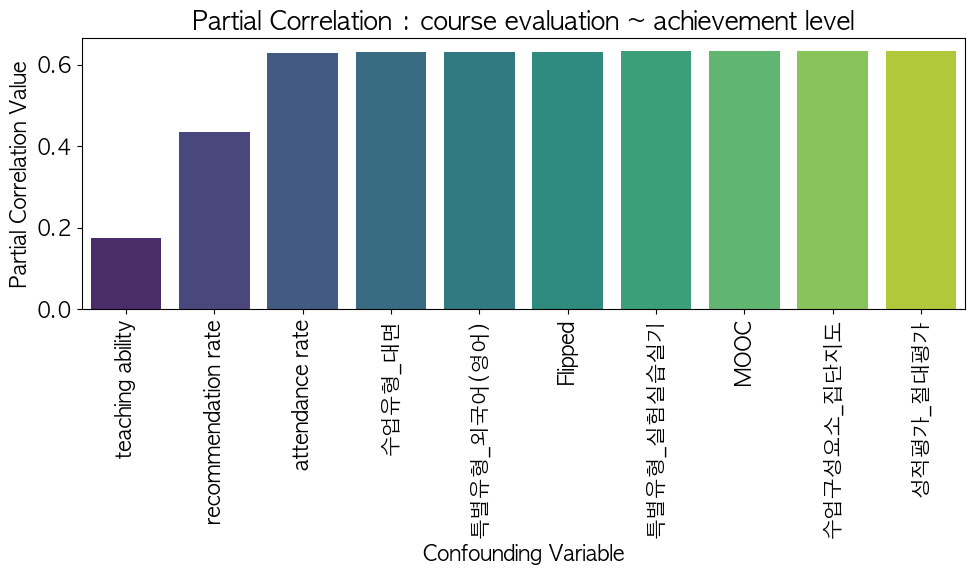

In [22]:
plot_top_k_partialcorr(par_corrs, x, y)

### PartialCorr(course evaluation, recommendation rate | C)

In [27]:
# features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']
# features = ['course evaluation', 'achievement level', 'recommendation rate']

# for i in range(len(features)):
#     x, y = [_ for _ in features if _ != features[i]]
#     covar = 'teaching ability'
#     # x, y = [_ for _ in t if _ != covar]

x = 'course evaluation'
y = 'recommendation rate'

covars = [f for f in data.columns if (f != x and f != y)]

par_corrs = {}

for covar in covars:
    # print(f'x = {x}, y = {y}, covar = {covar}')
    # print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))
    res = pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson')
    # print(res['r'][0])
    table.add_row([covar, res['r'].iloc[0]])
    par_corrs[covar] = res['r'].iloc[0]

# print(table)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/2337569785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(values), palette='viridis')


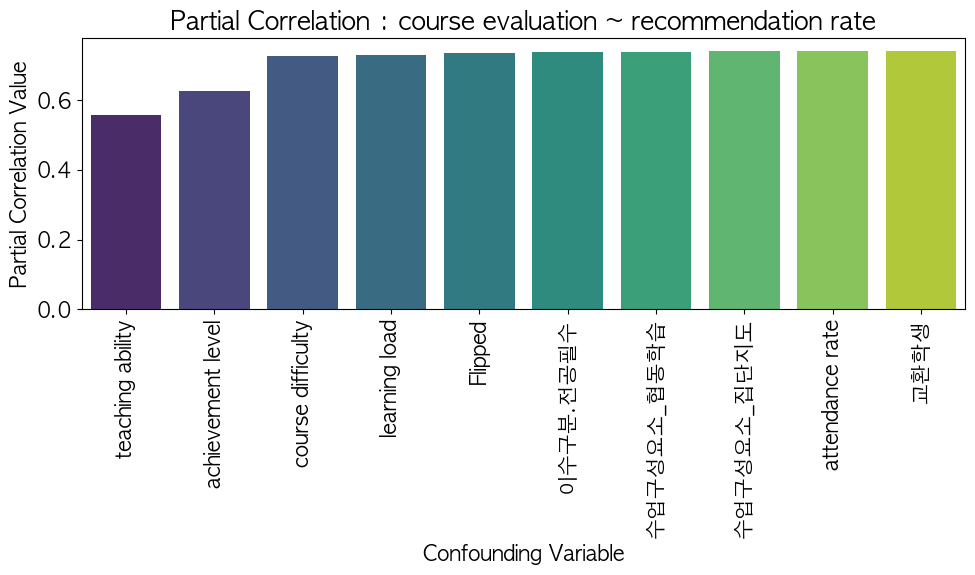

In [28]:
plot_top_k_partialcorr(par_corrs, x, y)

### PartialCorr(course evaluation, teaching ability | C)

In [29]:
# features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']
# features = ['course evaluation', 'achievement level', 'recommendation rate']

# for i in range(len(features)):
#     x, y = [_ for _ in features if _ != features[i]]
#     covar = 'teaching ability'
#     # x, y = [_ for _ in t if _ != covar]

x = 'course evaluation'
y = 'teaching ability'

covars = [f for f in data.columns if (f != x and f != y)]

par_corrs = {}

for covar in covars:
    # print(f'x = {x}, y = {y}, covar = {covar}')
    # print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'))
    res = pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson')
    # print(res['r'][0])
    table.add_row([covar, res['r'].iloc[0]])
    par_corrs[covar] = res['r'].iloc[0]

# print(table)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/2337569785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(values), palette='viridis')


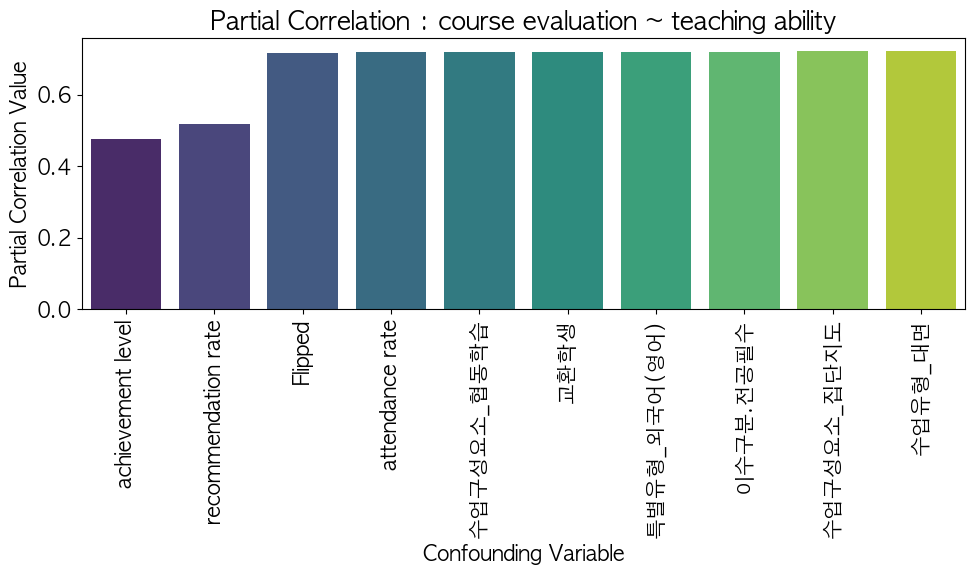

In [30]:
plot_top_k_partialcorr(par_corrs, x, y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_80028/2337569785.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(values), palette='viridis')


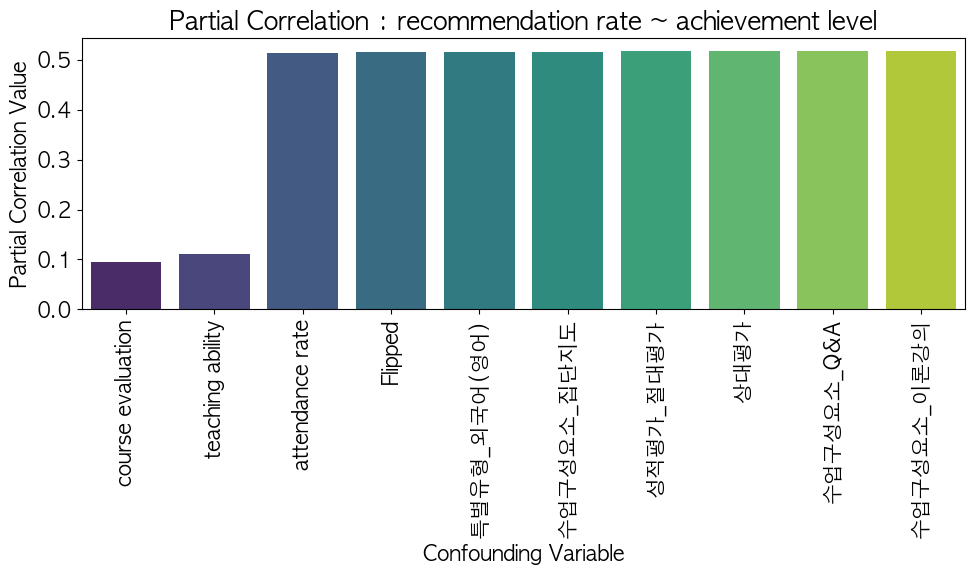

In [32]:
x = 'recommendation rate'
y = 'achievement level'

covars = [f for f in data.columns if (f != x and f != y)]

par_corrs = {}

for covar in covars:
    res = pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson')
    table.add_row([covar, res['r'].iloc[0]])
    par_corrs[covar] = res['r'].iloc[0]

plot_top_k_partialcorr(par_corrs, x, y)

# Check Correaltion (variations)

## Check Correlation (with Normalized Values, 전공선택 & 전공필수)

In [91]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
data = data[(data['이수구분.전공선택'] == 1.0) | (data['이수구분.전공필수'] == 1.0)]

print(data.shape)

# data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)
data.iloc[0][features]

(8215, 61)


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/2337612916.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


course evaluation      0.840
attendance rate        0.500
learning load          0.800
course difficulty      0.740
teaching ability       0.820
achievement level      0.740
recommendation rate    0.409
Name: 921, dtype: float64

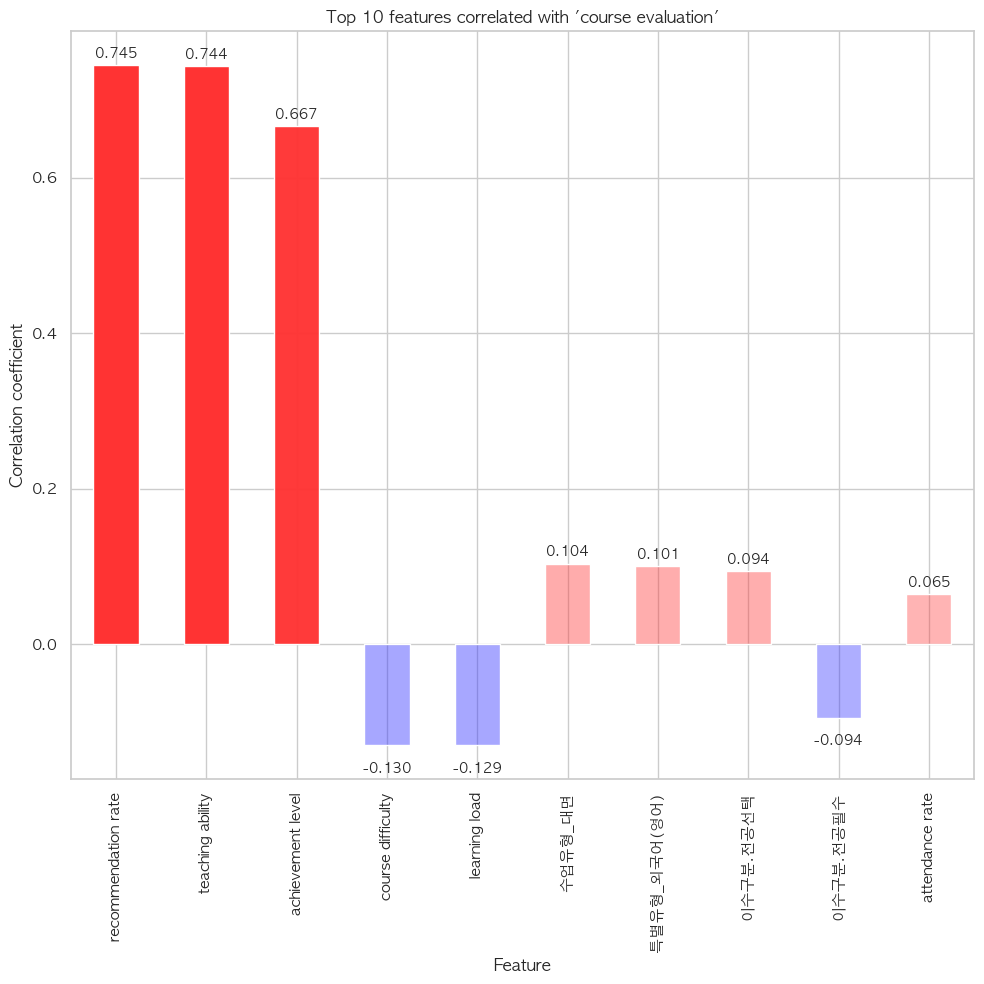

In [83]:
plot_top_k_correlations('course evaluation', data.corr())

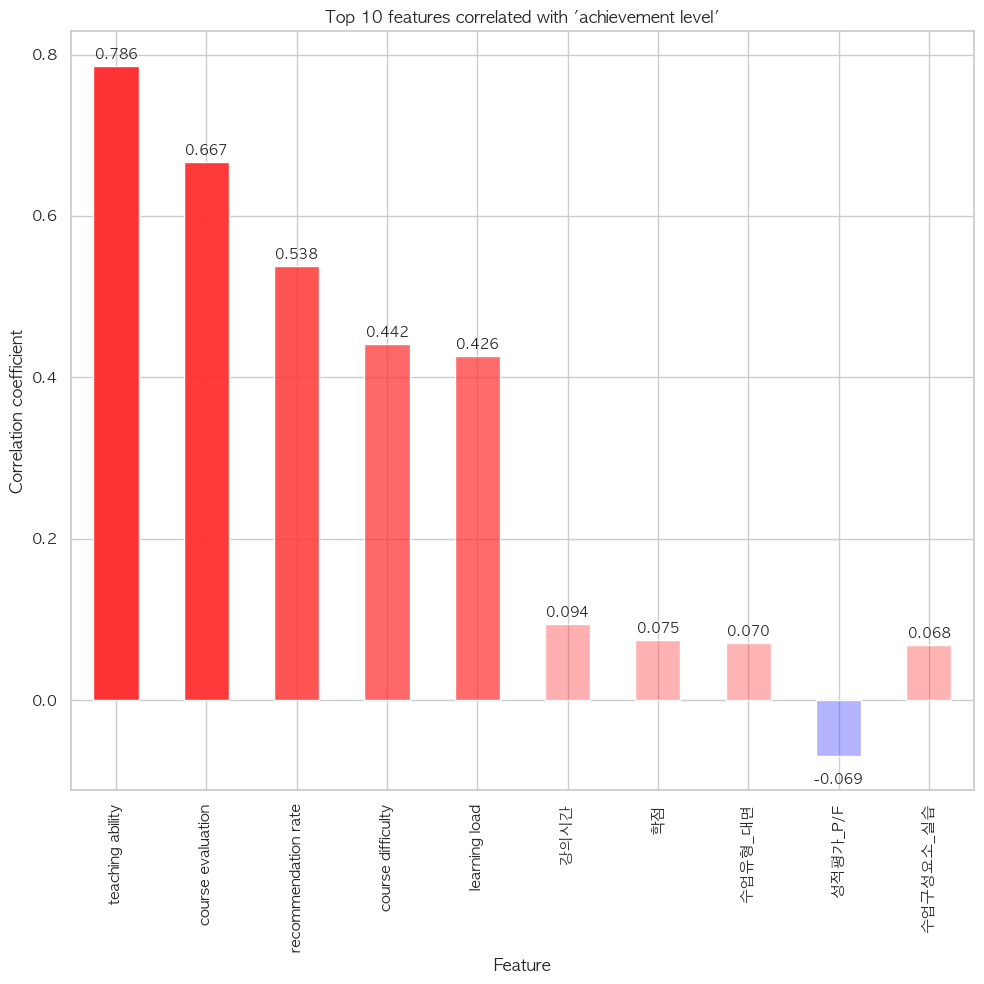

In [84]:
plot_top_k_correlations('achievement level', data.corr())

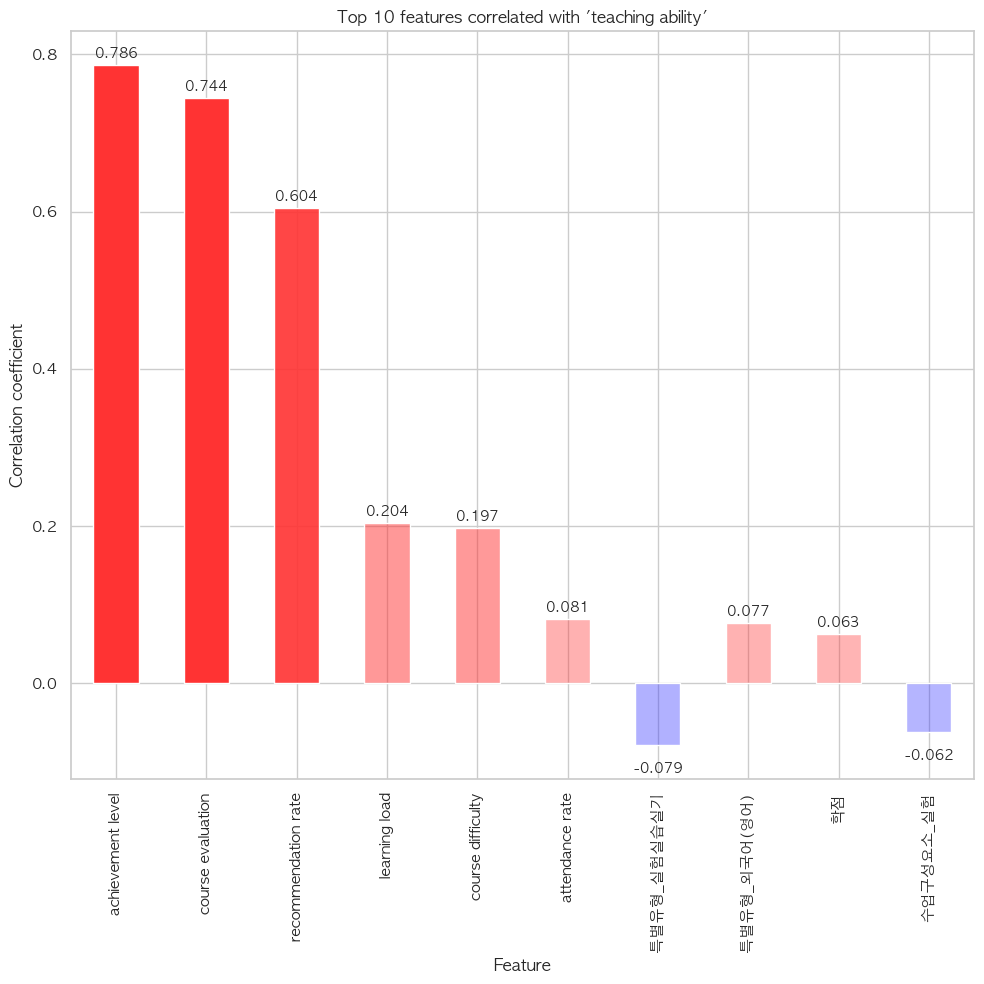

In [85]:
plot_top_k_correlations('teaching ability', data.corr())

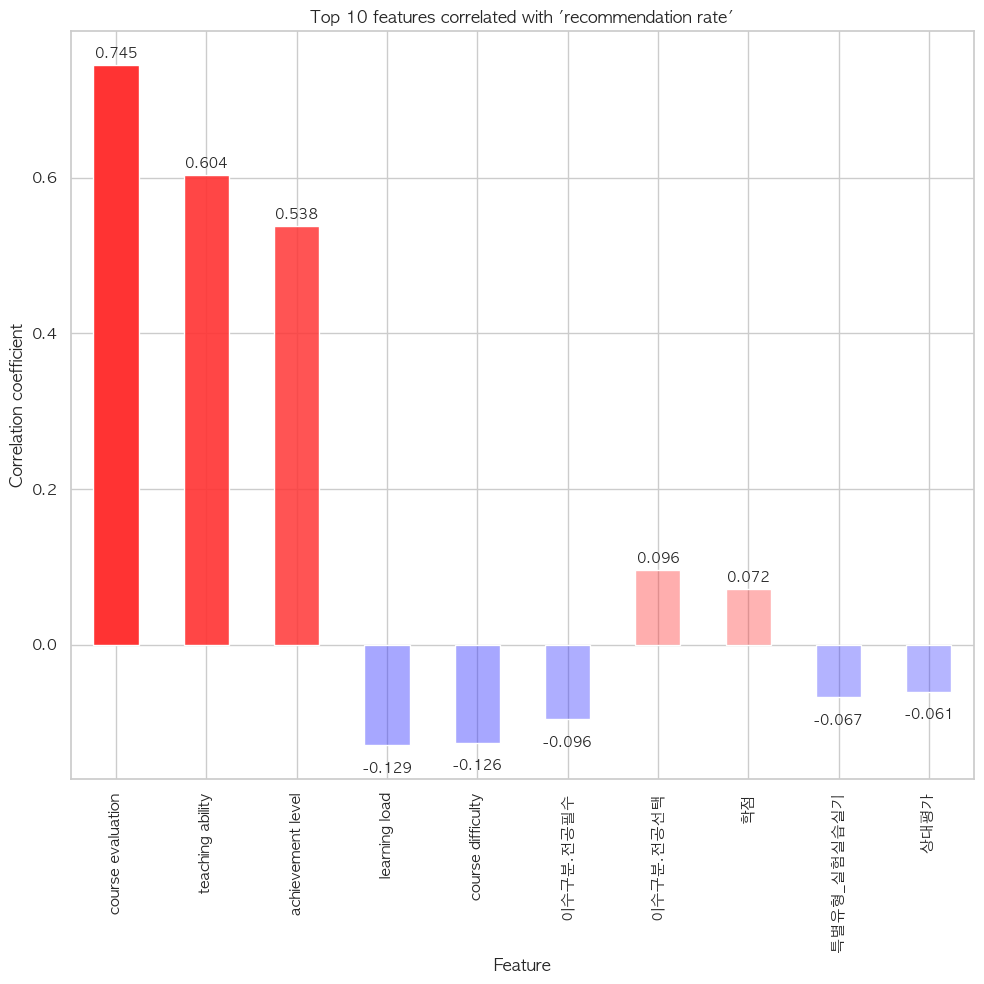

In [86]:
plot_top_k_correlations('recommendation rate', data.corr())

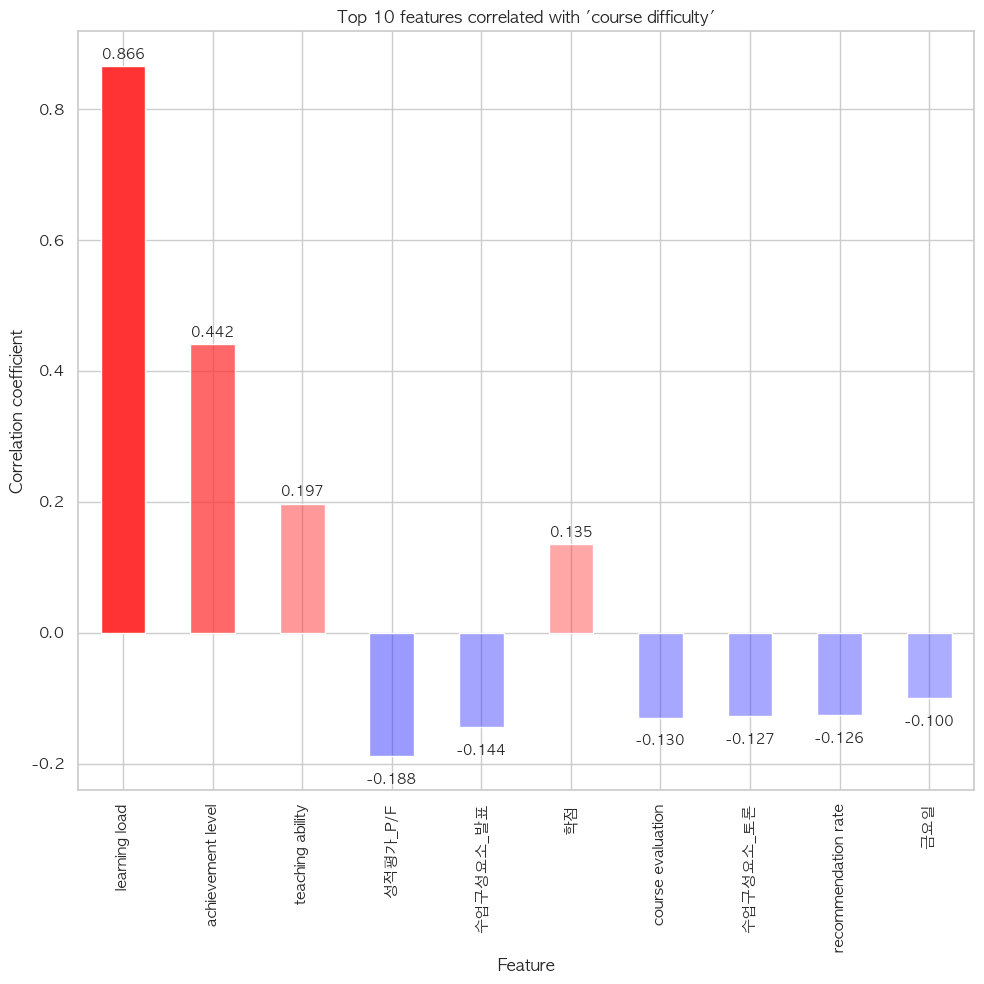

In [87]:
plot_top_k_correlations('course difficulty', data.corr())

In [92]:
features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']

for i in range(len(features)):
    t = [_ for _ in features if _ != features[i]]
    for covar in t:
        x, y = [_ for _ in t if _ != covar]
        print(f'x = {x}, y = {y}, covar = {covar}')
        print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'), data.corr()[x][y])
        print()

x = teaching ability, y = recommendation rate, covar = achievement level
            n         r         CI95%          p-val
pearson  8215  0.348205  [0.33, 0.37]  8.325471e-233 0.604106780089562

x = achievement level, y = recommendation rate, covar = teaching ability
            n         r         CI95%         p-val
pearson  8215  0.127449  [0.11, 0.15]  4.299400e-31 0.5376442922801884

x = achievement level, y = teaching ability, covar = recommendation rate
            n         r        CI95%  p-val
pearson  8215  0.686476  [0.67, 0.7]    0.0 0.7860561461989536

x = teaching ability, y = recommendation rate, covar = course evaluation
            n         r         CI95%         p-val
pearson  8215  0.112102  [0.09, 0.13]  2.185982e-24 0.604106780089562

x = course evaluation, y = recommendation rate, covar = teaching ability
            n         r         CI95%  p-val
pearson  8215  0.554623  [0.54, 0.57]    0.0 0.7447790966727421

x = course evaluation, y = teaching ability, 

## Check Correlation (with Normalized Values, 전공선택)

In [101]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
data = data[(data['이수구분.전공선택'] == 1.0)]

print(data.shape)

# data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)
data.iloc[0][features]

(5862, 61)


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/2949299737.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


course evaluation      0.840
attendance rate        0.500
learning load          0.800
course difficulty      0.740
teaching ability       0.820
achievement level      0.740
recommendation rate    0.409
Name: 921, dtype: float64

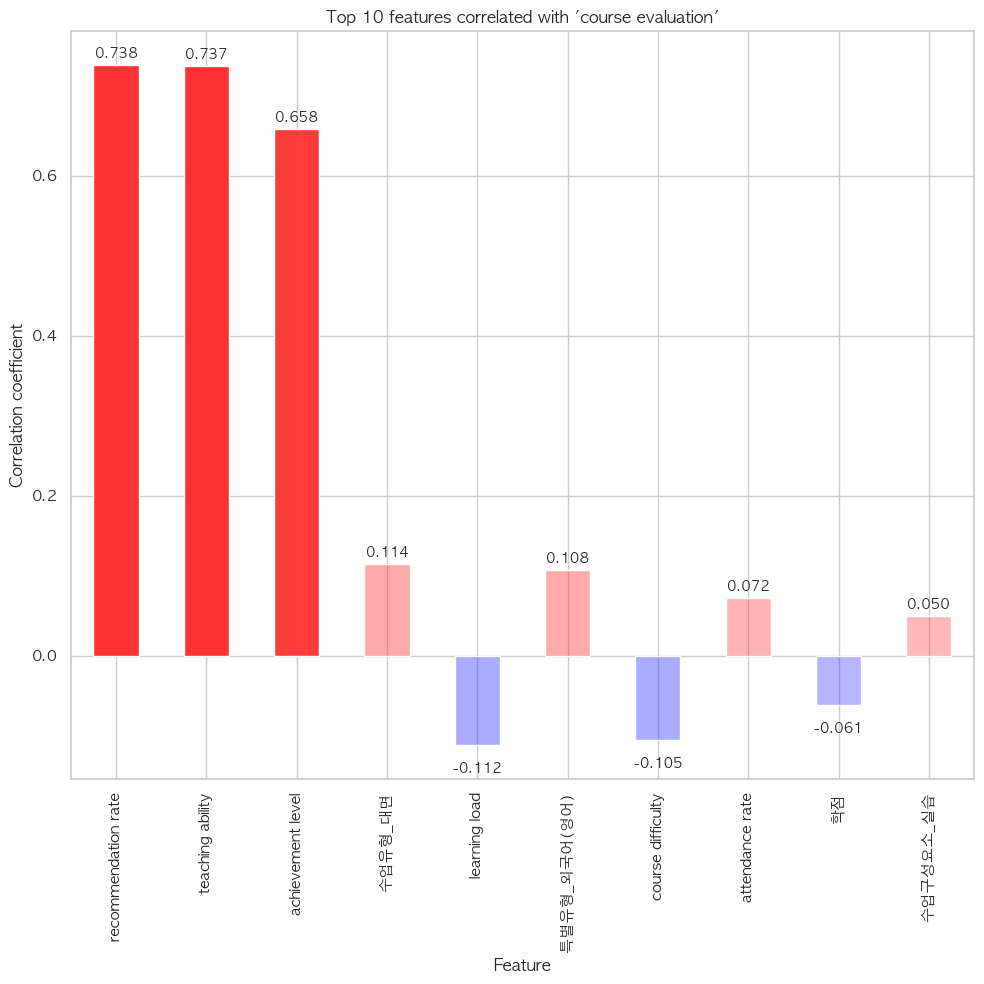

In [102]:
plot_top_k_correlations('course evaluation', data.corr())

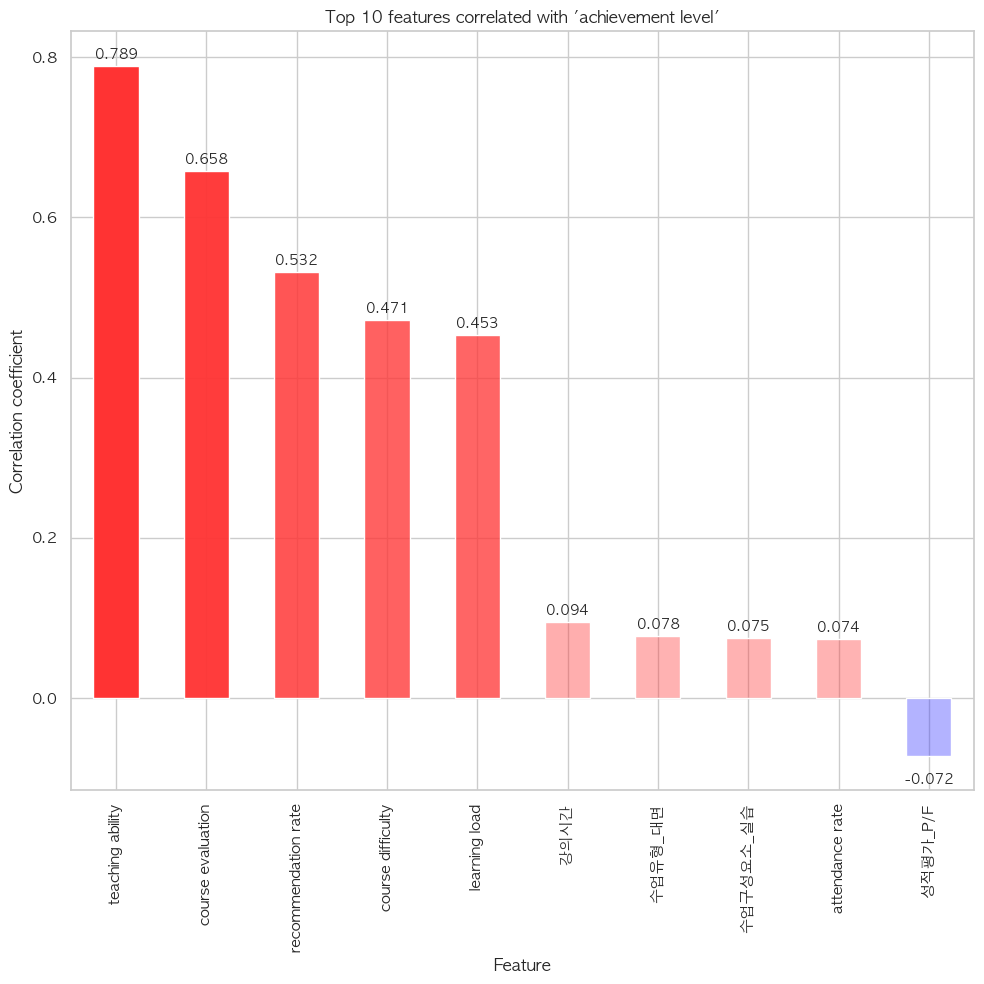

In [103]:
plot_top_k_correlations('achievement level', data.corr())

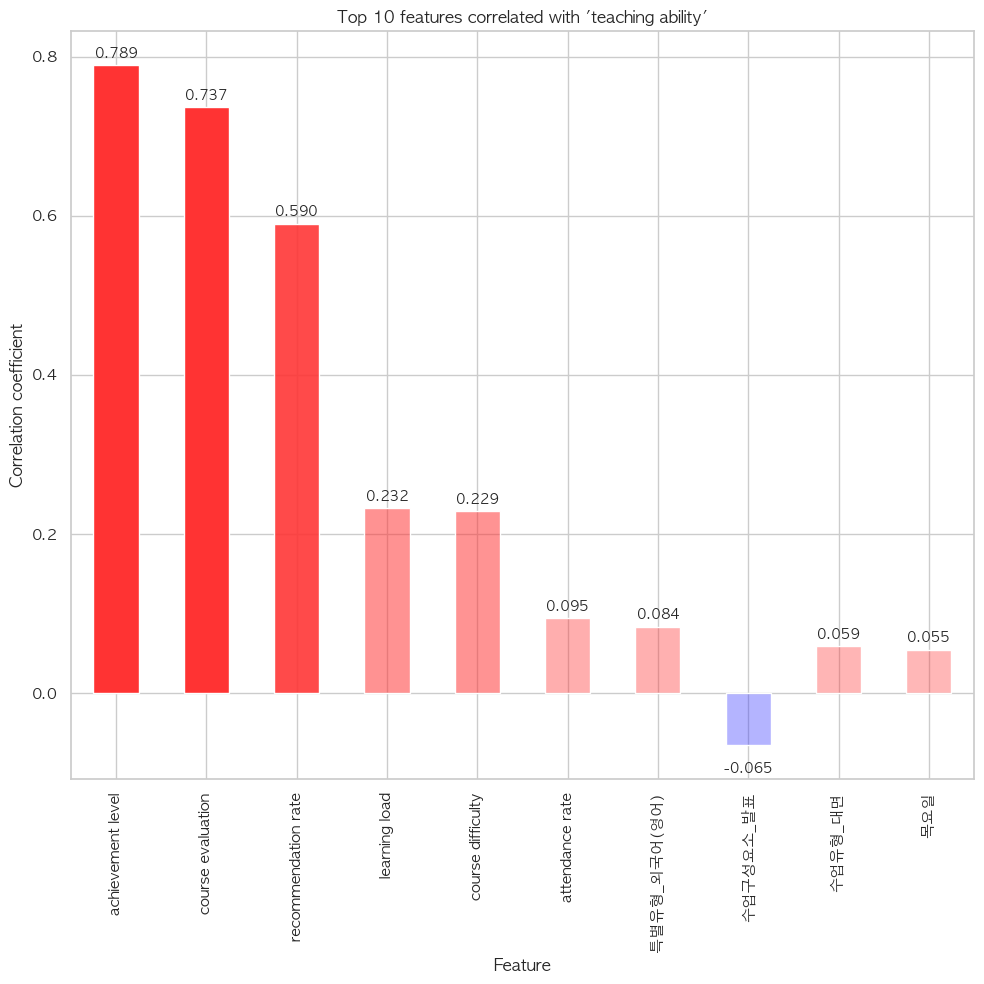

In [105]:
plot_top_k_correlations('teaching ability', data.corr())

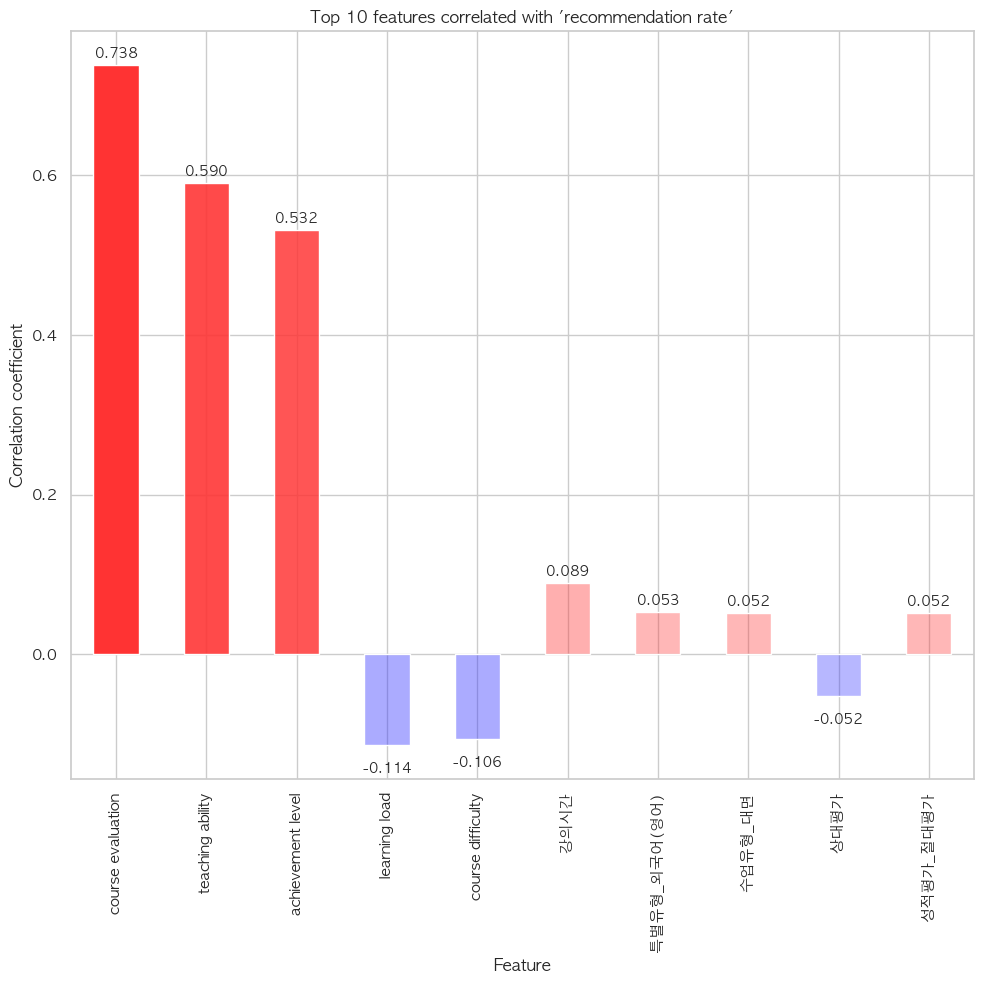

In [106]:
plot_top_k_correlations('recommendation rate', data.corr())

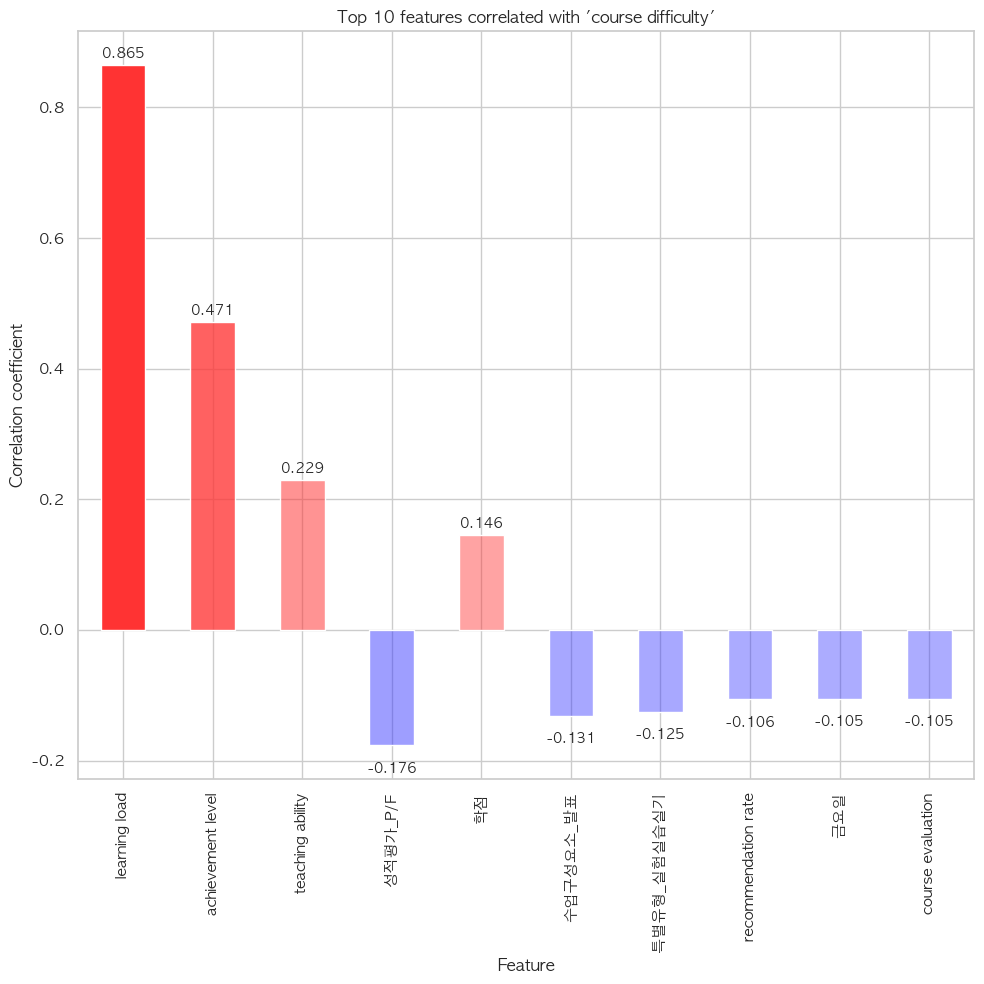

In [107]:
plot_top_k_correlations('course difficulty', data.corr())

In [108]:
features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']

for i in range(len(features)):
    t = [_ for _ in features if _ != features[i]]
    for covar in t:
        x, y = [_ for _ in t if _ != covar]
        print(f'x = {x}, y = {y}, covar = {covar}')
        print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'), data.corr()[x][y])
        print()

x = teaching ability, y = recommendation rate, covar = achievement level
            n         r        CI95%          p-val
pearson  5862  0.327965  [0.3, 0.35]  5.265365e-147 0.5900445372858424

x = achievement level, y = recommendation rate, covar = teaching ability
            n         r         CI95%         p-val
pearson  5862  0.133005  [0.11, 0.16]  1.519951e-24 0.5315167395759035

x = achievement level, y = teaching ability, covar = recommendation rate
            n         r         CI95%  p-val
pearson  5862  0.695107  [0.68, 0.71]    0.0 0.7889896976691313

x = teaching ability, y = recommendation rate, covar = course evaluation
            n         r         CI95%         p-val
pearson  5862  0.102019  [0.08, 0.13]  4.915922e-15 0.5900445372858424

x = course evaluation, y = recommendation rate, covar = teaching ability
            n         r         CI95%  p-val
pearson  5862  0.555106  [0.54, 0.57]    0.0 0.7377477298743605

x = course evaluation, y = teaching ability

## Check Correlation (with Normalized Values, 전공필수)

In [93]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
data = data[(data['이수구분.전공필수'] == 1.0)]

print(data.shape)

# data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)
data.iloc[0][features]

(2353, 61)


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/576374325.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


course evaluation      0.840
attendance rate        0.500
learning load          0.920
course difficulty      0.820
teaching ability       0.840
achievement level      0.800
recommendation rate    0.357
Name: 922, dtype: float64

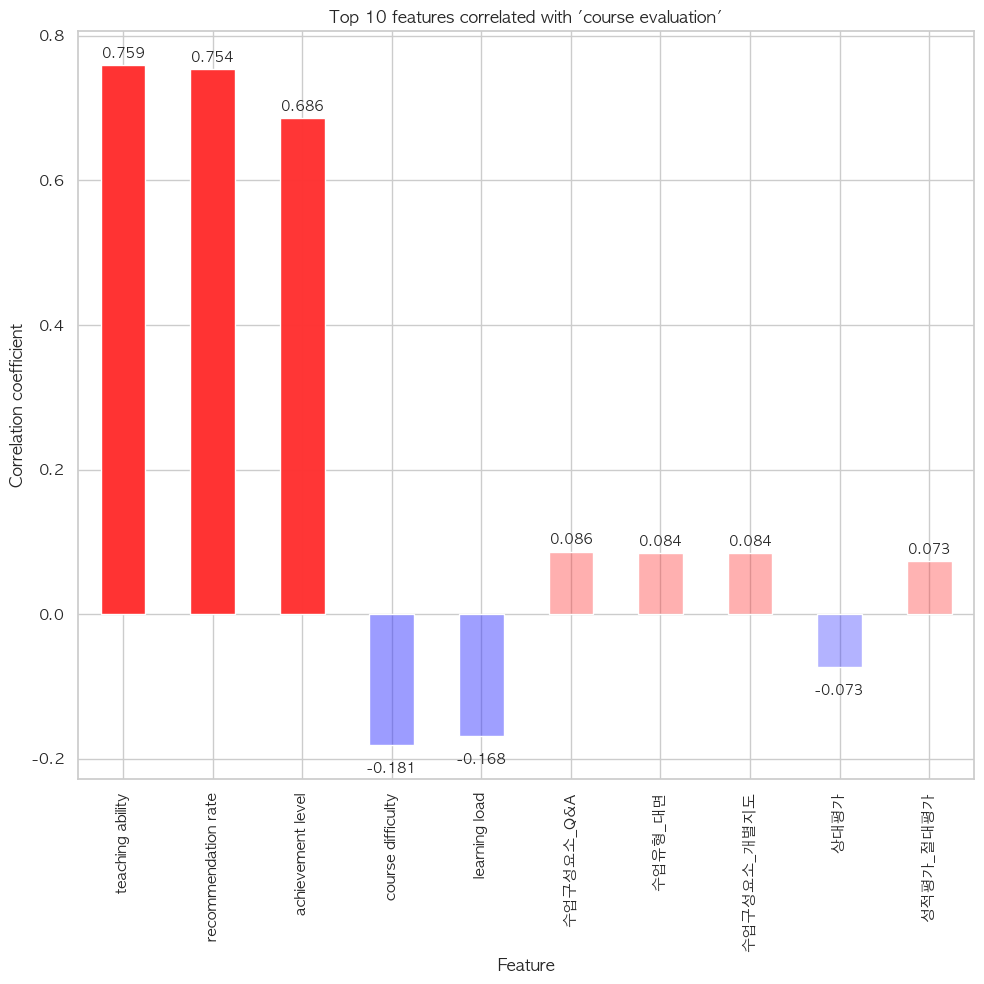

In [94]:
plot_top_k_correlations('course evaluation', data.corr())

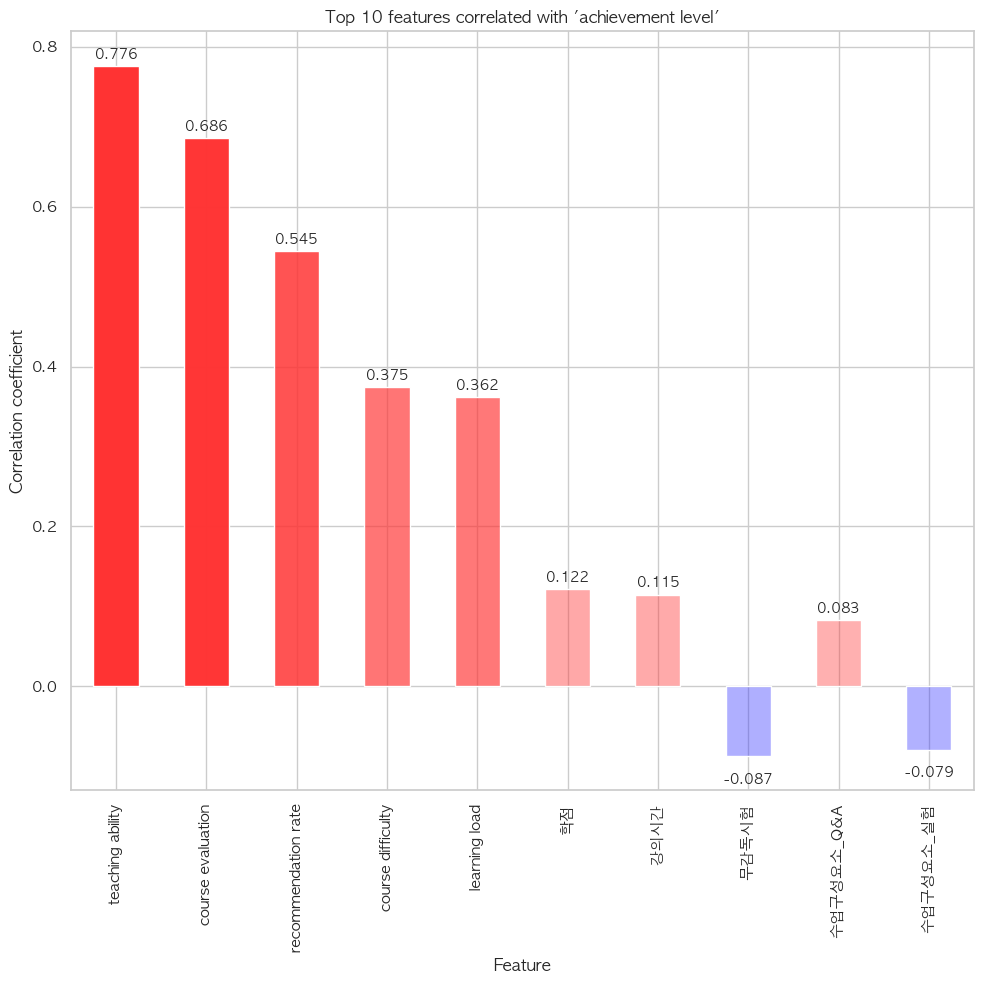

In [95]:
plot_top_k_correlations('achievement level', data.corr())

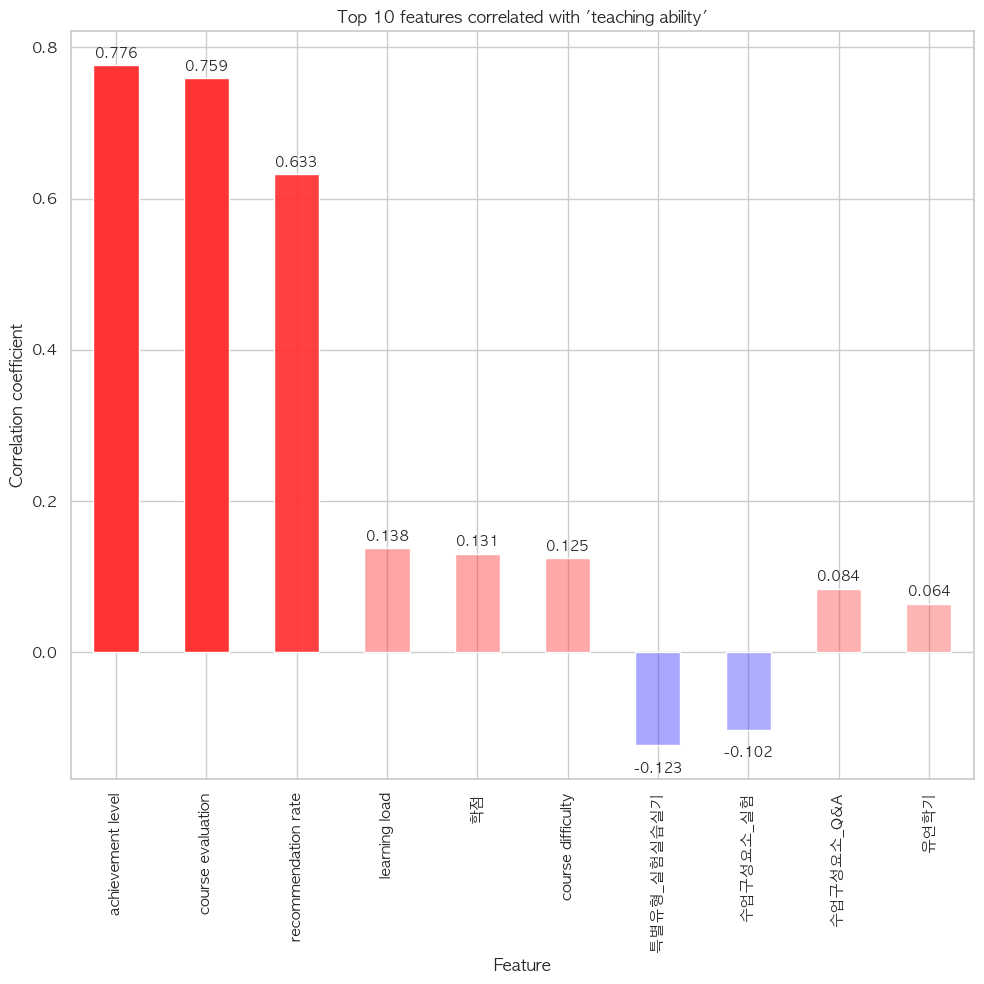

In [96]:
plot_top_k_correlations('teaching ability', data.corr())

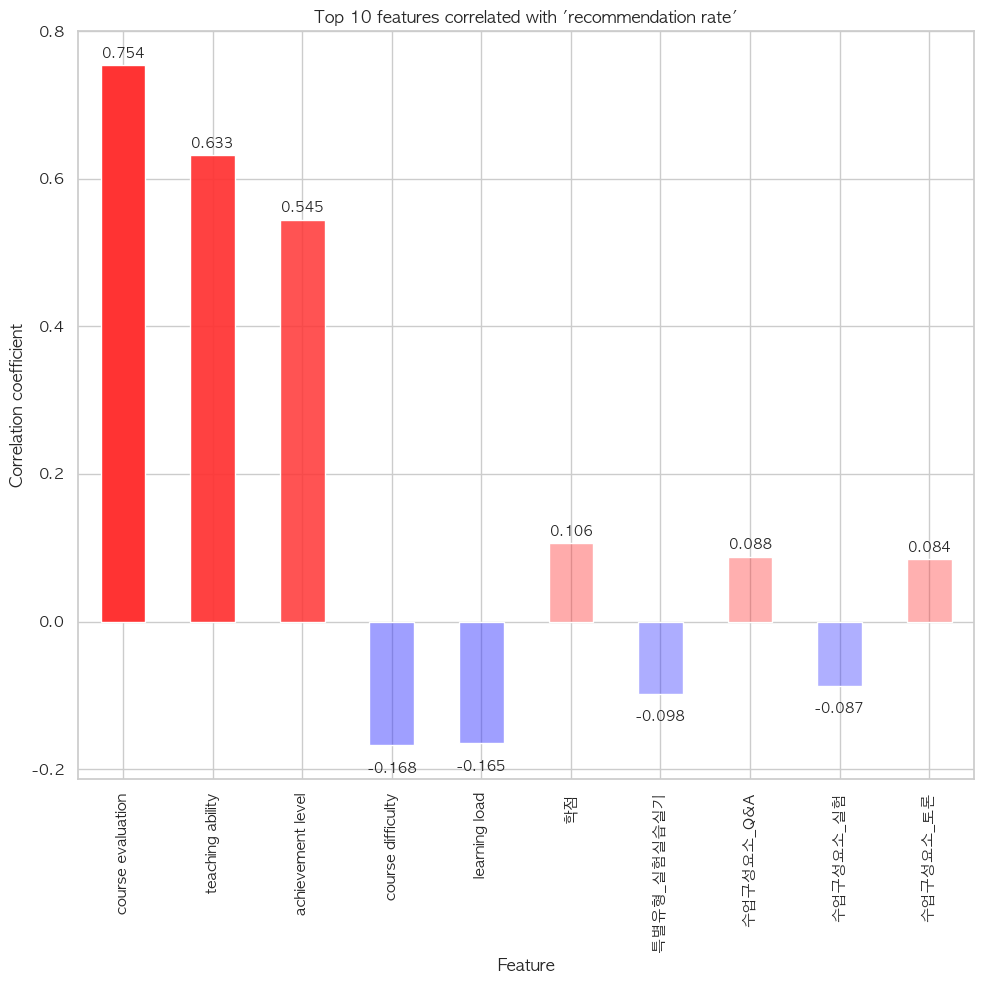

In [98]:
plot_top_k_correlations('recommendation rate', data.corr())

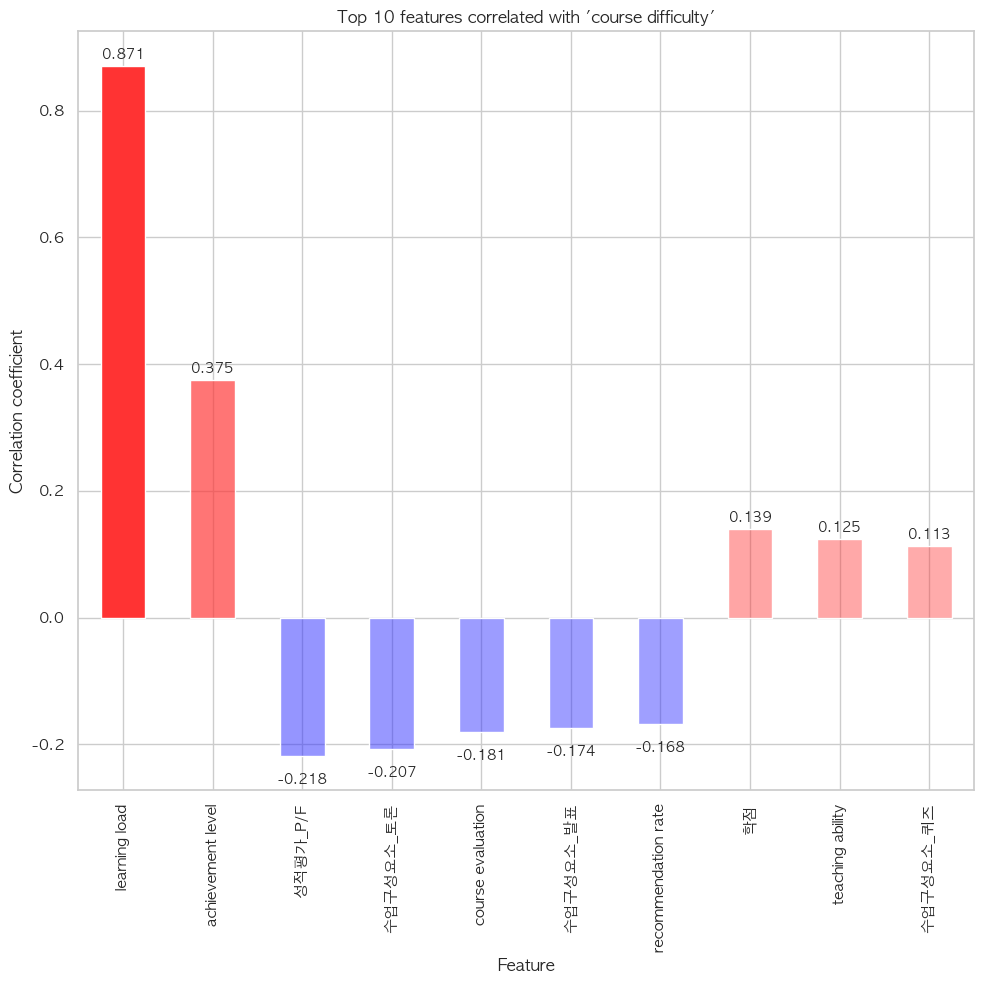

In [99]:
plot_top_k_correlations('course difficulty', data.corr())

In [100]:
features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']

for i in range(len(features)):
    t = [_ for _ in features if _ != features[i]]
    for covar in t:
        x, y = [_ for _ in t if _ != covar]
        print(f'x = {x}, y = {y}, covar = {covar}')
        print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'), data.corr()[x][y])
        print()

x = teaching ability, y = recommendation rate, covar = achievement level
            n         r         CI95%         p-val
pearson  2353  0.396764  [0.36, 0.43]  1.618320e-89 0.6326660565753023

x = achievement level, y = recommendation rate, covar = teaching ability
            n         r         CI95%         p-val
pearson  2353  0.109998  [0.07, 0.15]  8.891035e-08 0.5448198486396397

x = achievement level, y = teaching ability, covar = recommendation rate
            n         r         CI95%          p-val
pearson  2353  0.664586  [0.64, 0.69]  9.702481e-300 0.7762683834161769

x = teaching ability, y = recommendation rate, covar = course evaluation
            n         r        CI95%         p-val
pearson  2353  0.140659  [0.1, 0.18]  7.280035e-12 0.6326660565753023

x = course evaluation, y = recommendation rate, covar = teaching ability
            n         r         CI95%          p-val
pearson  2353  0.543099  [0.51, 0.57]  1.363358e-180 0.7540736926423034

x = course ev

## Check Correlation (with Normalized Values, 학문의기초 & 교양)

In [ ]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
data = data[(data['이수구분.전공선택'] == 1.0) | (data['이수구분.전공필수'] == 1.0)]

print(data.shape)

# data = load_data()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)
data.iloc[0][features]

(8215, 61)


/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_23704/2337612916.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


course evaluation      0.840
attendance rate        0.500
learning load          0.800
course difficulty      0.740
teaching ability       0.820
achievement level      0.740
recommendation rate    0.409
Name: 921, dtype: float64

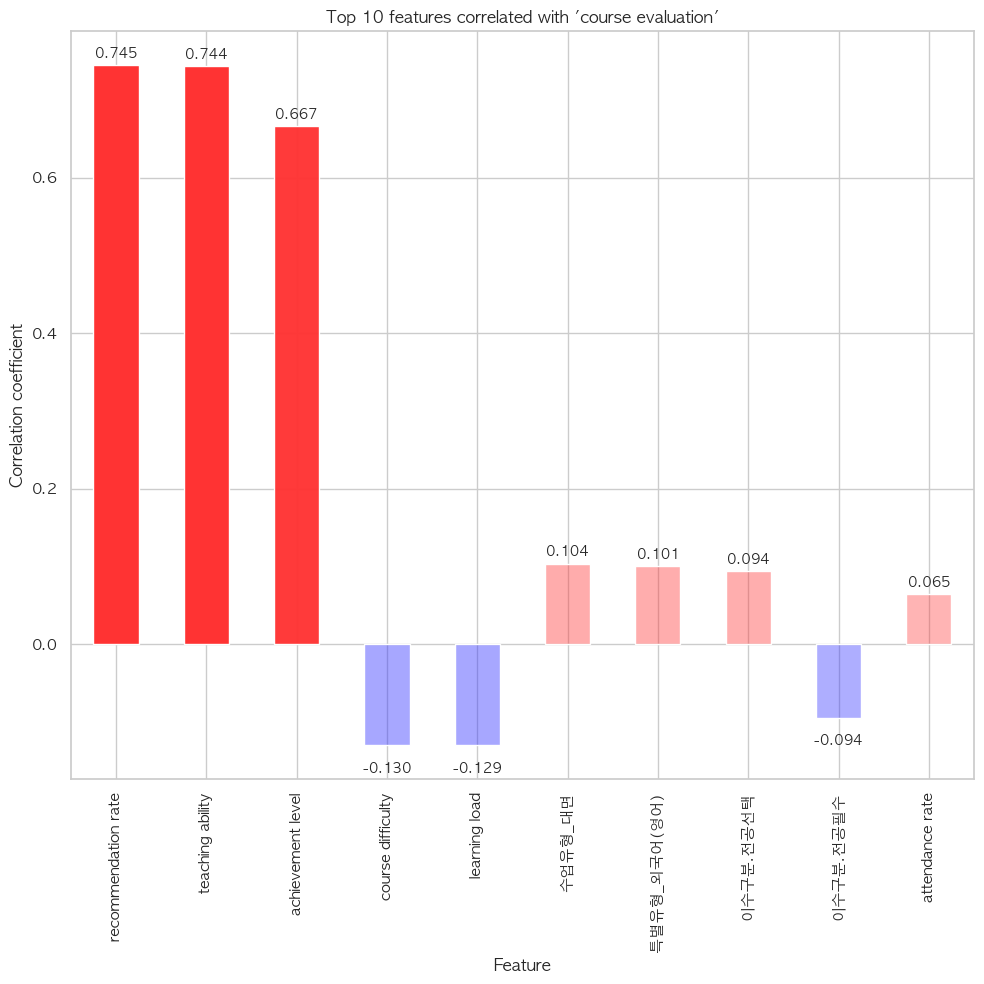

In [ ]:
plot_top_k_correlations('course evaluation', data.corr())

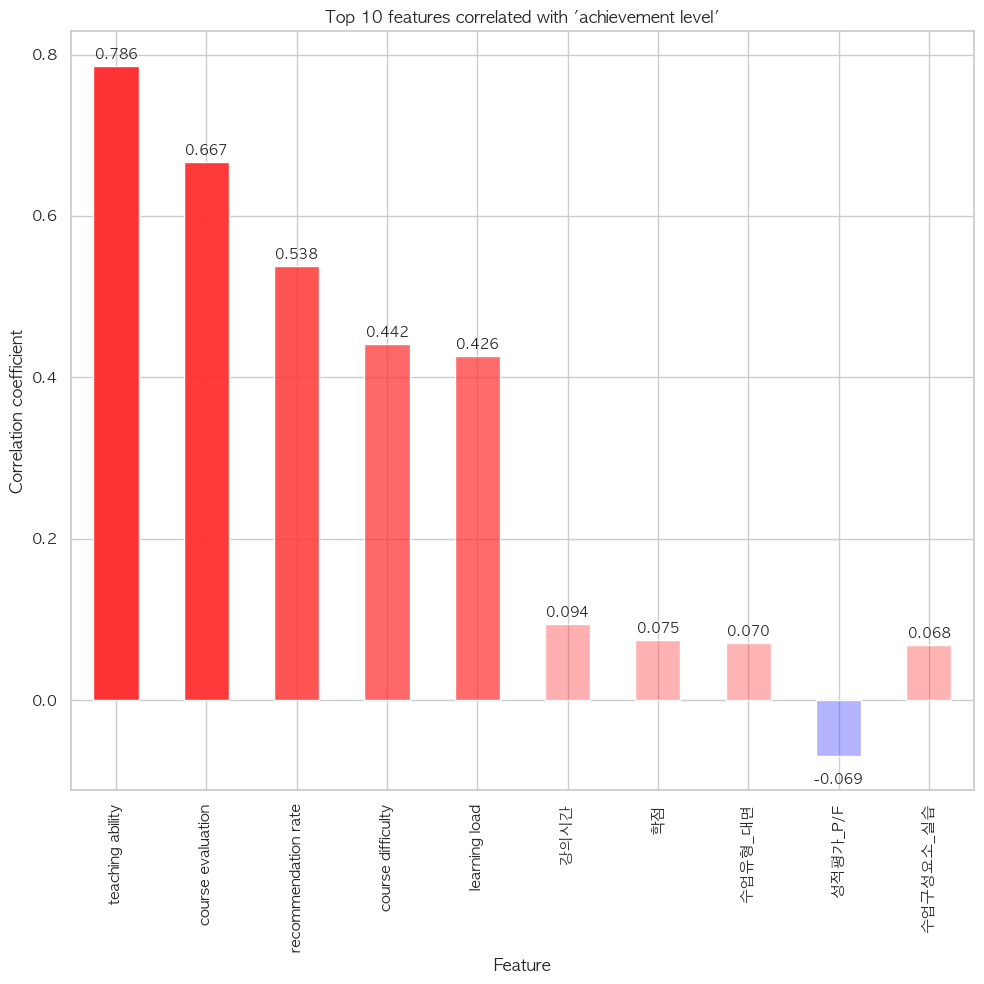

In [ ]:
plot_top_k_correlations('achievement level', data.corr())

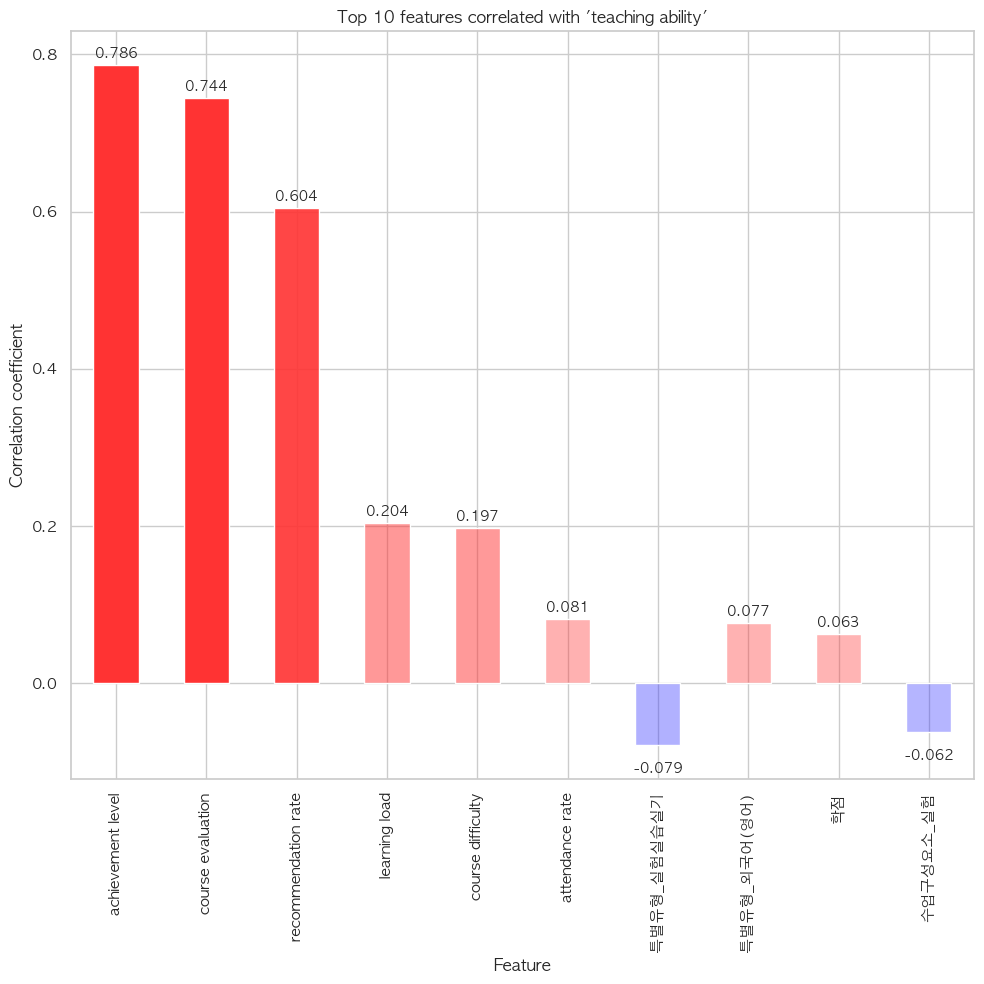

In [ ]:
plot_top_k_correlations('teaching ability', data.corr())

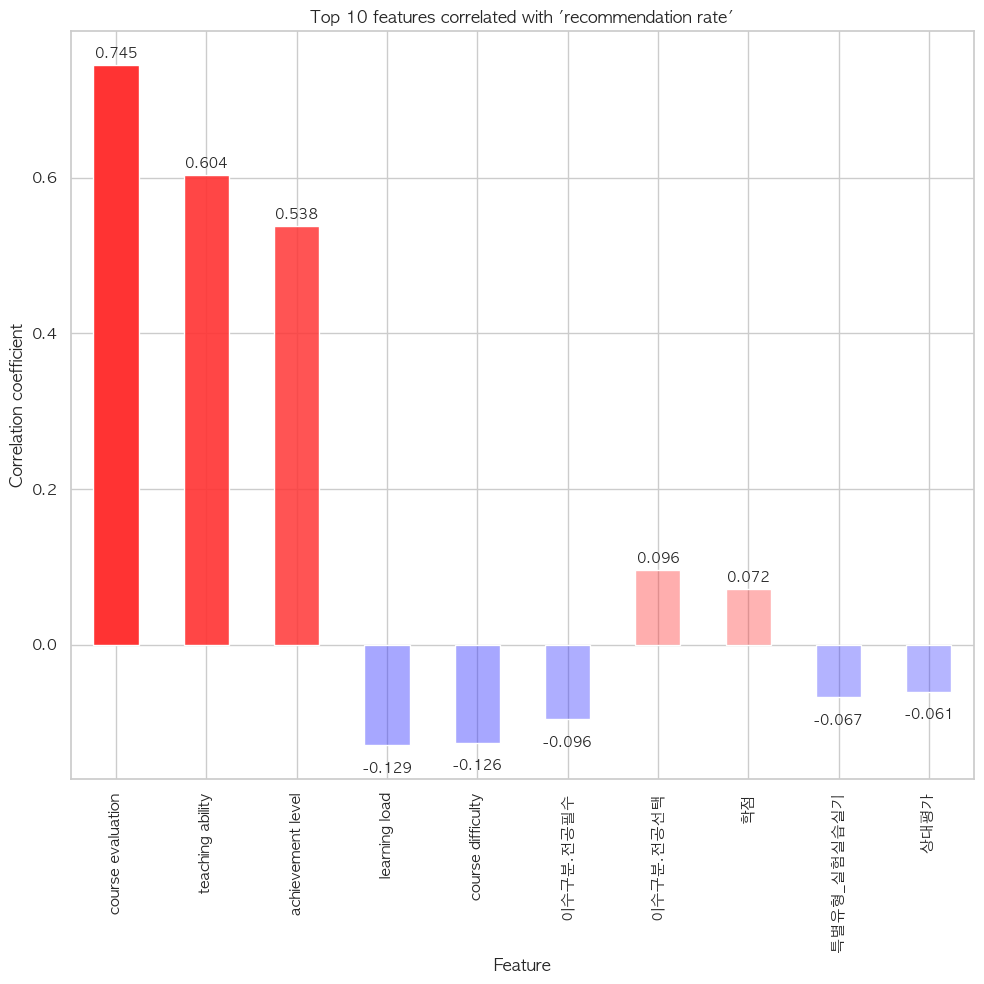

In [ ]:
plot_top_k_correlations('recommendation rate', data.corr())

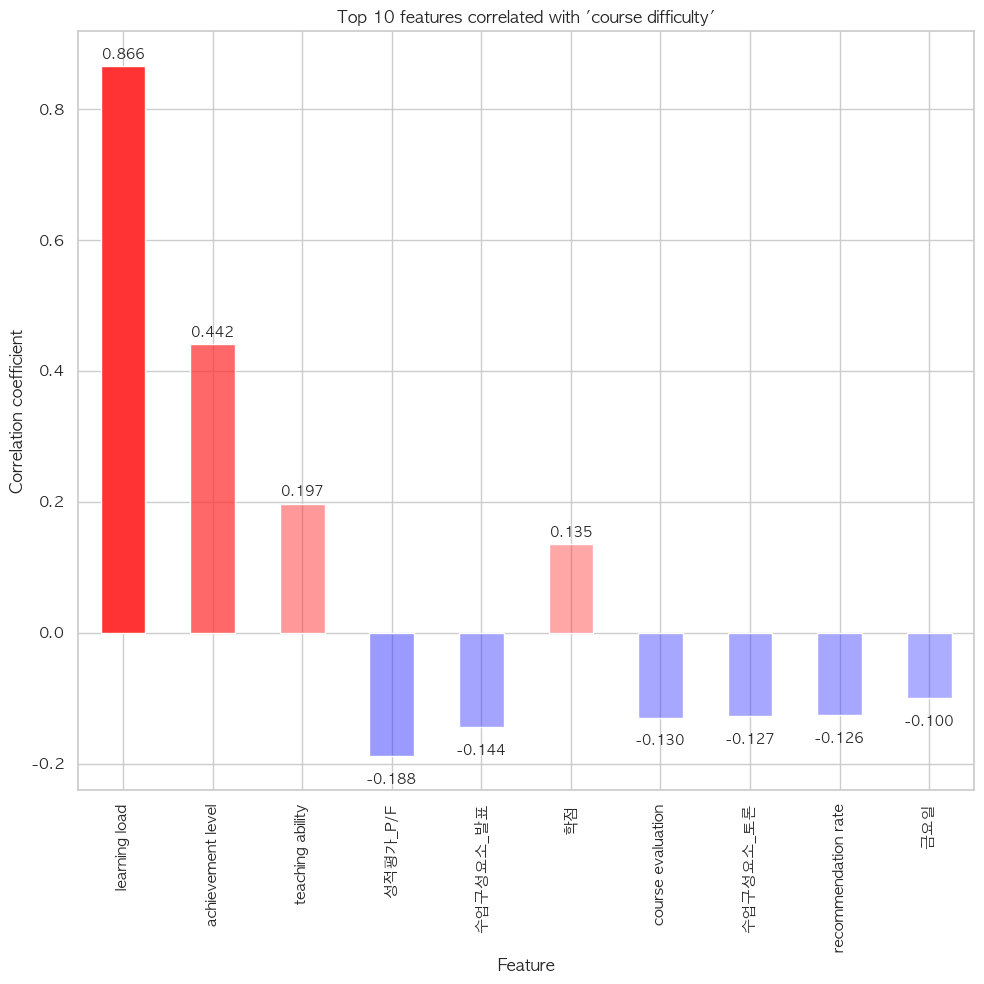

In [ ]:
plot_top_k_correlations('course difficulty', data.corr())

In [ ]:
features = ['course evaluation', 'achievement level', 'teaching ability', 'recommendation rate']

for i in range(len(features)):
    t = [_ for _ in features if _ != features[i]]
    for covar in t:
        x, y = [_ for _ in t if _ != covar]
        print(f'x = {x}, y = {y}, covar = {covar}')
        print(pg.partial_corr(data=data, x=x, y=y, covar=covar, method='pearson'), data.corr()[x][y])
        print()

x = teaching ability, y = recommendation rate, covar = achievement level
            n         r         CI95%          p-val
pearson  8215  0.348205  [0.33, 0.37]  8.325471e-233 0.604106780089562

x = achievement level, y = recommendation rate, covar = teaching ability
            n         r         CI95%         p-val
pearson  8215  0.127449  [0.11, 0.15]  4.299400e-31 0.5376442922801884

x = achievement level, y = teaching ability, covar = recommendation rate
            n         r        CI95%  p-val
pearson  8215  0.686476  [0.67, 0.7]    0.0 0.7860561461989536

x = teaching ability, y = recommendation rate, covar = course evaluation
            n         r         CI95%         p-val
pearson  8215  0.112102  [0.09, 0.13]  2.185982e-24 0.604106780089562

x = course evaluation, y = recommendation rate, covar = teaching ability
            n         r         CI95%  p-val
pearson  8215  0.554623  [0.54, 0.57]    0.0 0.7447790966727421

x = course evaluation, y = teaching ability, 

# Regression & Residuals

In [14]:
# data = load_data()
data = pd.read_csv('../data/uptodate_numerical.csv')
data = data.dropna()
features = ['course evaluation','attendance rate','learning load','course difficulty','teaching ability','achievement level','recommendation rate']
# data = data[features]
for f in features:
    if f == 'attendance rate' or f == 'recommendation rate':
        continue
    data[f] = data[f] / 5
data['recommendation rate'] = [float(d[:d.index('%')]) / 100 for d in data['recommendation rate']]
data = preprocess(data)

/var/folders/41/g_k82x_s2vj932yp1t4s78r80000gn/T/ipykernel_37734/1495549595.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/uptodate_numerical.csv')


Slope of the regression line (residual of course evaluation ~ residual of achievement level): 0.1878


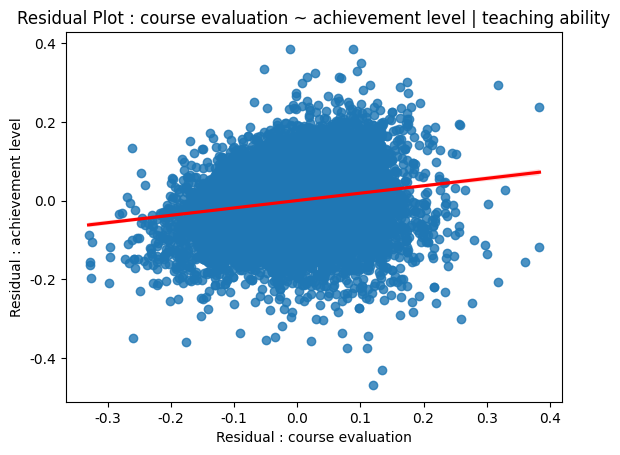

In [25]:
import statsmodels.api as sm

df = copy.deepcopy(data)

feat_A = 'course evaluation'
feat_B = 'achievement level'
feat_C = 'teaching ability'

# Step 1: Residuals of A ~ C
X = sm.add_constant(df[feat_C])
resid_A = sm.OLS(df[feat_A], X).fit().resid

# Step 2: Residuals of B ~ C
resid_B = sm.OLS(df[feat_B], X).fit().resid

X_resid_A = sm.add_constant(resid_A)
model = sm.OLS(resid_B, X_resid_A).fit()
slope = model.params[0]

print(f"Slope of the regression line (residual of {feat_A} ~ residual of {feat_B}): {slope:.4f}")

# Step 3: Plot the residuals
sns.regplot(x=resid_A, y=resid_B, line_kws={"color": "red"})
# plt.xlabel(f"Residual {feat_A} ({feat_A} ~ {feat_C})")
plt.xlabel(f"Residual : {feat_A}")
# plt.ylabel(f"Residual {feat_B} ({feat_B} ~ {feat_C})")
plt.ylabel(f"Residual : {feat_B}")
# plt.title(f"Partial Correlation: Residuals of {feat_A} and {feat_B} after controlling for {feat_C}")
plt.title(f"Residual Plot : {feat_A} ~ {feat_B} | {feat_C}")
plt.show()

Slope of the regression line (residual of teaching ability ~ residual of achievement level): 0.5532


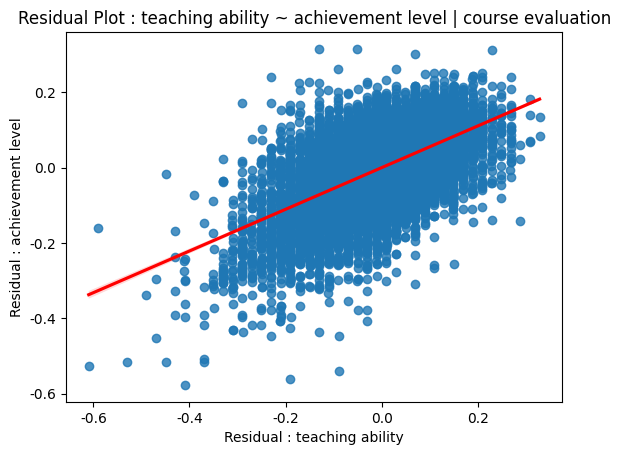

In [26]:
import statsmodels.api as sm

df = copy.deepcopy(data)

feat_C = 'course evaluation'
feat_B = 'achievement level'
feat_A = 'teaching ability'

# Step 1: Residuals of A ~ C
X = sm.add_constant(df[feat_C])
resid_A = sm.OLS(df[feat_A], X).fit().resid

# Step 2: Residuals of B ~ C
resid_B = sm.OLS(df[feat_B], X).fit().resid

X_resid_A = sm.add_constant(resid_A)
model = sm.OLS(resid_B, X_resid_A).fit()
slope = model.params[0]

print(f"Slope of the regression line (residual of {feat_A} ~ residual of {feat_B}): {slope:.4f}")

# Step 3: Plot the residuals
sns.regplot(x=resid_A, y=resid_B, line_kws={"color": "red"})
# plt.xlabel(f"Residual {feat_A} ({feat_A} ~ {feat_C})")
plt.xlabel(f"Residual : {feat_A}")
# plt.ylabel(f"Residual {feat_B} ({feat_B} ~ {feat_C})")
plt.ylabel(f"Residual : {feat_B}")
# plt.title(f"Partial Correlation: Residuals of {feat_A} and {feat_B} after controlling for {feat_C}")
plt.title(f"Residual Plot : {feat_A} ~ {feat_B} | {feat_C}")
plt.show()

Slope of the regression line (residual of course evaluation ~ residual of teaching ability): 0.5415


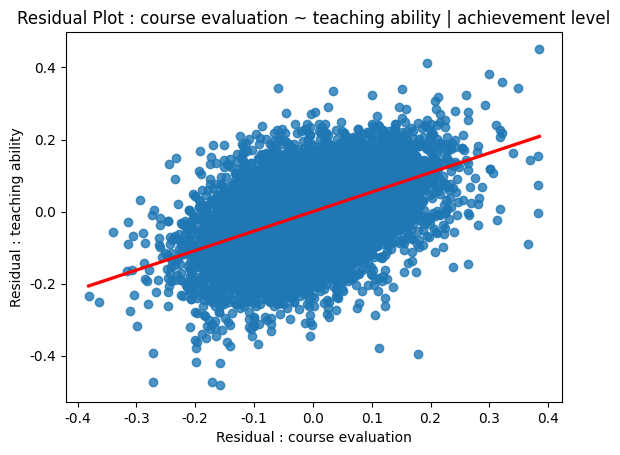

In [27]:
import statsmodels.api as sm

df = copy.deepcopy(data)

feat_A = 'course evaluation'
feat_C = 'achievement level'
feat_B = 'teaching ability'

# Step 1: Residuals of A ~ C
X = sm.add_constant(df[feat_C])
resid_A = sm.OLS(df[feat_A], X).fit().resid

# Step 2: Residuals of B ~ C
resid_B = sm.OLS(df[feat_B], X).fit().resid

X_resid_A = sm.add_constant(resid_A)
model = sm.OLS(resid_B, X_resid_A).fit()
slope = model.params[0]

print(f"Slope of the regression line (residual of {feat_A} ~ residual of {feat_B}): {slope:.4f}")

# Step 3: Plot the residuals
sns.regplot(x=resid_A, y=resid_B, line_kws={"color": "red"})
# plt.xlabel(f"Residual {feat_A} ({feat_A} ~ {feat_C})")
plt.xlabel(f"Residual : {feat_A}")
# plt.ylabel(f"Residual {feat_B} ({feat_B} ~ {feat_C})")
plt.ylabel(f"Residual : {feat_B}")
# plt.title(f"Partial Correlation: Residuals of {feat_A} and {feat_B} after controlling for {feat_C}")
plt.title(f"Residual Plot : {feat_A} ~ {feat_B} | {feat_C}")
plt.show()

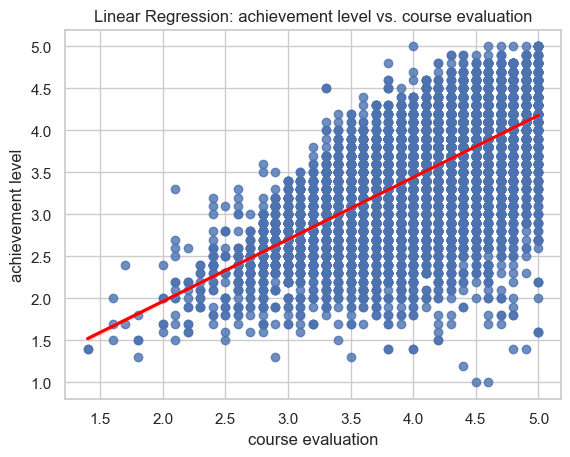

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = copy.deepcopy(data)

feat_A = 'course evaluation'
feat_B = 'achievement level'
feat_C = 'teaching ability'


# Plot with regression line
sns.set(style="whitegrid")
sns.regplot(x=feat_A, y=feat_B, data=df, line_kws={"color": "red"})
plt.xlabel(feat_A)
plt.ylabel(feat_B)
plt.title(f"Linear Regression: {feat_B} vs. {feat_A}")
plt.show()

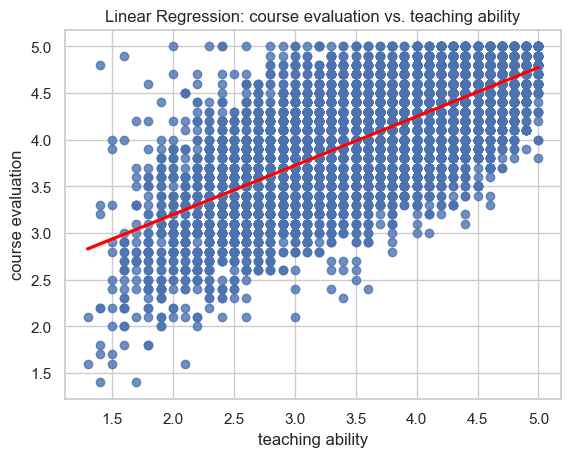

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = copy.deepcopy(data)

feat_B = 'course evaluation'
feat_C = 'achievement level'
feat_A = 'teaching ability'


# Plot with regression line
sns.set(style="whitegrid")
sns.regplot(x=feat_A, y=feat_B, data=df, line_kws={"color": "red"})
plt.xlabel(feat_A)
plt.ylabel(feat_B)
plt.title(f"Linear Regression: {feat_B} vs. {feat_A}")
plt.show()

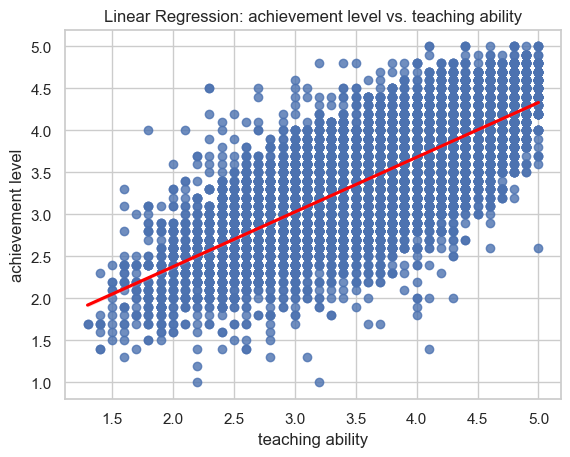

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = copy.deepcopy(data)

feat_C = 'course evaluation'
feat_B = 'achievement level'
feat_A = 'teaching ability'


# Plot with regression line
sns.set(style="whitegrid")
sns.regplot(x=feat_A, y=feat_B, data=df, line_kws={"color": "red"})
plt.xlabel(feat_A)
plt.ylabel(feat_B)
plt.title(f"Linear Regression: {feat_B} vs. {feat_A}")
plt.show()

# Archive

In [1]:
import numpy as np

feature_category = {
    'nominal' : ['idx', 'ID', 'Title', '담당교수', '교과목명'],
    'categorical' : ['Class', 'Semester', '개설학과', '유연학기'],
    'ordinal' : ['Year', ],
    'numerical' : ['course evaluation', 'attendance rate', 'learning load', 'course difficulty', 'teaching ability', 'achievement level', 'recommendation rate', '학점', '강의시간'],
    'etc' : [],
    'binary' : []
}

class Instance:
    def __init__(self, features, id, feature_category2idx):
        self.features = {}
        self.id = id
        self.label = None
        self.feature_category2idx = feature_category2idx
        self.split_features(features)

    def split_features(self, features):
        self.feature_types = feature_category.keys()
        for ftype in self.feature_types:
            self.features[ftype] = np.array([])
        for ftype in self.feature_types:
            self.features[ftype] = np.append(self.features[ftype], features.iloc[self.feature_category2idx[ftype]])

In [8]:
import os
import csv
import copy
from queue import Queue
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from tqdm import tqdm

# from kmodes.kmodes import KModes

feature_category = {
    'nominal' : ['idx', 'ID', 'Title', '담당교수', '교과목명'],
    'categorical' : ['Class', 'Semester', '개설학과', '유연학기'],
    'ordinal' : ['Year', ],
    'numerical' : ['course evaluation', 'attendance rate', 'learning load', 'course difficulty', 'teaching ability', 'achievement level', 'recommendation rate', '학점', '강의시간'],
    'etc' : [],
    'binary' : []
}

class Clustering:
    def __init__(self, file_name, metric='binary'):
        self.instances = {}
        self.clusters = {}
        self.cluster_cnt = 0
        self.num_clusters = 0
        self.neighbor_ids = {}

        self.load_data(file_name)

        self.metric = metric
        if metric == 'binary':
            self.dissimilarity = self.binary_dissimilarity
        elif metric == 'gower':
            self.dissimilarity = self.gower_dissimilarity

    def binary_feature_index(self, features):
        self.binary_feature_indices = []
        for i, f in enumerate(features):
            if type(f) == np.bool:
                self.binary_feature_indices.append(i)

    def key_to_index(self, features):
        feature_keys = list(features.index)
        for f in feature_keys:
            is_binary = True
            for category in feature_category.keys():
                if f in feature_category[category]:
                    is_binary = False
                    break
            if is_binary:
                feature_category['binary'].append(f)

        self.feature_category2idx = {}
        for category, key in feature_category.items():
                self.feature_category2idx[category] = [feature_keys.index(k) for k in key]

    def load_data(self, file_name):
        # data 위치할 파일 임의로 /data로 설정, 추후 수정 가능
        # data_path = os.path.abspath('../') + '/data/' + file_name
        data_path = f'./{file_name}'
        data = pd.read_csv(data_path)
        data = data[(data['이수구분.전공선택'] == True) | (data['이수구분.전공필수'] == True)]
        data = data[data['Year'] > 2021]
        # data = data.iloc[:1000]
        # print(data.head())
        print(len(data))

        self.key_to_index(data.iloc[0])

        for i in range(len(data)):
            self.instances[data.iloc[i, 0]] = Instance(data.iloc[i], data.iloc[i, 0], self.feature_category2idx)
        self.feature_types = feature_category.keys()

    def binary_dissimilarity(self, inst1, inst2):
        '''
        calculates dissimilarity based on binary features between two distinct data instances

        :param inst1: first data instance
        :param inst2: second data instance
        '''
        assert inst1 != inst2

        diff_cnt = 0
        for bf in range(len(inst1.features['binary'])):
            if inst1.features['binary'][bf] != inst2.features['binary'][bf]:
                diff_cnt += 1
        return diff_cnt / len(inst1.features['binary'])

        # diff_cnt = sum(inst1.features['binary'] != inst2.features['binary'])
        # binary_features_cnt = len(inst1.features['binary'])

        # dissim = diff_cnt / binary_features_cnt
        # return dissim

    def gower_dissimilarity(self, inst1, inst2, ranges=None, ordinals=None):
        """
        calculates gower dissimilarity based on various features between two distinct data instances

        :param inst1: first data instance
        :param inst2: second data instance
        :param ranges: list of (min, max) for each numerical/ordinal feature
        :param ordinals: list of lists specifying the order for each ordinal feature (optional)
        """
        assert inst1 != inst2

        x = inst1.features
        y = inst2.features

        assert len(x) == len(y) == len(self.feature_types)
        dissim = 0.0
        valid = 0

        for ftype in self.feature_types:
            if ftype == 'numerical':
                if ranges is not None and ranges[ftype] is not None:
                    min_, max_ = ranges[ftype]
                    denom = max_ - min_
                    if denom == 0:
                        continue
                    dissim += sum(abs(x[ftype] - y[ftype])) / denom
                else:
                    dissim += sum(abs(x[ftype] - y[ftype])) / (np.nanmax([x[ftype], y[ftype]]) - np.nanmin([x[ftype], y[ftype]]) + 1e-9)
                valid += 1
            elif ftype == 'binary':
                dissim += sum(x[ftype] != y[ftype])
                valid += 1
            elif ftype == 'categorical':
                dissim += sum(x[ftype] != y[ftype])
                valid += 1
            elif ftype == 'ordinal':
                if ordinals is not None and ordinals[ftype] is not None:
                    order = ordinals[ftype]
                    xi = order.index(x[ftype])
                    yi = order.index(y[ftype])
                    denom = len(order) - 1
                    if denom == 0:
                        continue
                    dissim += sum(abs(xi - yi)) / denom
                    valid += 1
                elif ranges is not None and ranges[ftype] is not None:
                    min_, max_ = ranges[ftype]
                    denom = max_ - min_
                    if denom == 0:
                        continue
                    dissim += sum(abs(x[ftype] - y[ftype])) / denom
                    valid += 1
                else:
                    dissim += sum(x[ftype] != y[ftype])
                    valid += 1
            else:
                pass

        return dissim / valid if valid > 0 else 0.0

    def get_neighbor_ids(self, center, radius):
        if center.id in self.neighbor_ids.keys():
            return self.neighbor_ids[center.id]
        neighbor_ids = []
        for idx in self.instances.keys():
            inst = self.instances[idx]
            if inst == center:
                continue
            if self.dissimilarity(center, inst) <= radius:
                neighbor_ids.append(inst.id)
        self.neighbor_ids[center.id] = neighbor_ids
        return neighbor_ids

    def dbscan(self, radius, minPts):
        print('Start DBSCAN')
        self.radius = radius
        self.minPts = minPts

        label_set_cnt = 0
        percentage = 10
        for idx in tqdm(self.instances.keys()):
            # if idx / len(self.instances) * 100 > checkpoint:
            #     print(idx / len(self.instances) * 100)
            #     checkpoint += 10
            inst = self.instances[idx]

            if inst.label is not None:
                continue
            neighbor_ids = self.get_neighbor_ids(inst, radius)
            if len(neighbor_ids) < minPts:
                inst.label = -1 # denotes noise instance
                continue
            self.cluster_cnt += 1
            self.clusters[self.cluster_cnt] = []
            inst.label = self.cluster_cnt
            self.clusters[self.cluster_cnt].append(inst)

            seed_set = Queue()
            for neighbor_id in neighbor_ids:
                seed_set.put(neighbor_id)

            # label_set_cnt += 1
            # if label_set_cnt / len(self.instances) * 100 > percentage:
                # print(f'{label_set_cnt / len(self.instances) * 100} % done.')
                # percentage += 10
            while not seed_set.empty():
                curr_id = seed_set.get()
                curr_instance = self.instances[curr_id]

                if curr_instance.label == -1:
                    curr_instance.label = self.cluster_cnt
                    # label_set_cnt += 1
                    # if label_set_cnt / len(self.instances) * 100 > percentage:
                    #     print(f'{label_set_cnt / len(self.instances) * 100} % done.')
                    #     percentage += 10
                    self.clusters[self.cluster_cnt].append(curr_instance)
                elif curr_instance.label is None:
                    curr_instance.label = self.cluster_cnt
                    # label_set_cnt += 1
                    # if label_set_cnt / len(self.instances) * 100 > percentage:
                    #     print(f'{label_set_cnt / len(self.instances) * 100} % done.')
                    #     percentage += 10
                    self.clusters[self.cluster_cnt].append(curr_instance)

                    n_neighbor_ids = self.get_neighbor_ids(curr_instance, radius)

                    if len(n_neighbor_ids) >= minPts:
                        for n_neighbor_id in n_neighbor_ids:
                            if self.instances[n_neighbor_id].label is None or self.instances[n_neighbor_id].label == -1:
                                seed_set.put(n_neighbor_id)

In [9]:
c = Clustering('uptodate_binary.csv')
c.dbscan(0.05, 20)

<ipython-input-8-d957f1927e3e>:65: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


4791
Start DBSCAN


  0%|          | 0/4791 [02:31<?, ?it/s]


KeyboardInterrupt: 

In [28]:
c.instances[921].features

{'nominal': array([np.int64(921), 'JURA424', '조세법', '박종수', '조세법'], dtype=object),
 'categorical': array(['0', '2R', '법학전문대학원', np.int64(0)], dtype=object),
 'ordinal': array([np.int64(2023)], dtype=object),
 'numerical': array([np.float64(4.2), np.float64(0.5), np.float64(4.0), np.float64(3.7),
        np.float64(4.1), np.float64(3.7), '40.9%', np.float64(3.0),
        np.float64(3.0)], dtype=object),
 'etc': array([], dtype=object),
 'binary': array([np.True_, np.False_, np.False_, np.False_, np.False_, np.False_,
        np.False_, np.False_, np.False_, np.False_, np.False_, np.False_,
        np.False_, np.False_, np.True_, np.False_, np.False_, np.False_,
        np.True_, np.False_, np.True_, np.False_, np.False_, np.False_,
        np.True_, np.False_, np.False_, np.False_, np.False_, np.False_,
        np.False_, np.False_, np.True_, np.False_, np.False_, np.True_,
        np.False_, np.True_, np.True_, np.False_, np.False_, np.True_],
       dtype=object)}

In [6]:
len(c.clusters[1])

83

In [7]:
len(c.clusters[2])

65

In [17]:
data = pd.read_csv('./uptodate_binary.csv')
for row in data.itertuples():
    print(row)
    break

Pandas(Index=0, idx=0, ID='SEDU330', Class='4', Title='학교폭력예방및학생의이해*Course not open for foreign exchange students', Year=2023, Semester='2R', _7=3.8, _8=0.75, _9=3.2, _10=2.6, _11=2.8, _12=3.3, _13='8.3%', 인원제한=True, NeMo=False, 영강=False, 튜토리얼=False, MOOC=False, 학점=2.0, 개설학과='교직팀', 출석확인자율화=False, 유연학기=0, Flipped=False, 상대평가=True, 담당교수='양준영', 교과목명='학교폭력예방및학생의이해', 수강포기제한=False, 강의시간=2.0, 교환학생=False, 무감독시험=False, _31=True, _32=False, _33=False, _34=False, _35=False, _36=False, _37=False, 월요일=False, 화요일=False, 수요일=False, 목요일=True, 금요일=False, 토요일=False, 수업유형_대면=False, 특별유형_실험실습실기=False, _46=False, 특별유형_캡스톤디자인=False, 특별유형_팀티칭=False, 특별유형_현장실습=False, _50=True, 수업구성요소_개별지도=False, 수업구성요소_발표=True, 수업구성요소_실습=True, 수업구성요소_실험=False, 수업구성요소_이론강의=True, 수업구성요소_집단지도=True, 수업구성요소_퀴즈=True, 수업구성요소_토론=True, 수업구성요소_협동학습=True, _60=False, 성적평가_절대평가=False)


<ipython-input-17-30c7aa40fcaa>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./uptodate_binary.csv')


In [18]:
data.iloc[0]

idx                                                            0
ID                                                       SEDU330
Class                                                          4
Title          학교폭력예방및학생의이해*Course not open for foreign excha...
Year                                                        2023
                                     ...                        
수업구성요소_퀴즈                                                   True
수업구성요소_토론                                                   True
수업구성요소_협동학습                                                 True
성적평가_P/F                                                   False
성적평가_절대평가                                                  False
Name: 0, Length: 61, dtype: object